#### Setup in Paperspace

In [1]:
%pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 1.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 39.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install matplotlib imageio scikit-learn tqdm


Note: you may need to restart the kernel to use updated packages.


# Data Processing

In [3]:
import numpy as np
import pandas as pd

import os
import psutil
import time
import tempfile
from tqdm import tqdm

import math
import random
from random import randint

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from scipy.stats import multivariate_normal
from scipy.sparse.linalg import eigsh
from scipy.sparse import csgraph

import seaborn as sns
import matplotlib.pyplot as plt
import imageio.v2 as imageio

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.nn.modules.module import Module

import torch_geometric
from torch_geometric.nn import GCNConv

In [4]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(f'using {device}')

# Set random seeds for reproducibility
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)  

using cuda


In [5]:
# Antivectorize given vector into adjacency matrix
def antiVectorize(vec, m):
    M = np.zeros((m,m))
    M[np.tril_indices(m,k=-1)] = vec
    M= M.transpose()
    M[np.tril_indices(m,k=-1)] = vec
    return M

# Vectorize graph adjacency matrix into a vector
def vectorize(M):
    return M[np.tril_indices(M.shape[0], k=-1)]

## Load Dataset

In [6]:
# dataset_path = '/Users/gitaayusalsabila/Documents/0thesis/code/sandbox/dataset/'
dataset_path = '/notebooks/dataset/'

### Load Simulated Dataset

In [7]:
def multivariate_simulate(datapath, n_samples=200,n_time=2,n_views=4):
    # Note that changing the node count is not provided right now, since we use correlation matrix
    # and the mean values of connectivities from real data and it is for 35 nodes.
    
    # Import all required statistical information.
    allstats = np.load(datapath + "stats/REAL_TIME_DIFF.npy") # Connectivity mean values of LH. You can also try with RH.
    allcorrs = np.load(datapath + "stats/REAL_TIME_DIFF.npy") # Correlation matrix in LH. You can also try with RH.
    all_diffs = np.load(datapath + "stats/REAL_TIME_DIFF.npy") # This is an overall representation of time differences in both (LH and RH) datasets.
    
    times = []
    for t in range(n_time):
        views = []
        for v in range(n_views):
            # Note that we randomly assign a new random state to ensure it will generate a different dataset at each run.
            # Generate data with the correlations and mean values at the current timepoint.
            if t < 2:
                connectomic_means = allstats[t,v]
                data = multivariate_normal.rvs(connectomic_means,allcorrs[t,v],n_samples,random_state=randint(1,9999))
            # If the requested timepoints are more than we have in real data, use the correlation information from the last timepoint.
            else:
                connectomic_means = allstats[-1,v]
                data = multivariate_normal.rvs(connectomic_means,allcorrs[-1,v],n_samples,random_state=randint(1,9999))

            adj = []
            for idx, sample in enumerate(data):
                # Create adjacency matrix.
                matrix = antiVectorize(sample,35)
                # Perturb the real time difference with nonlinear tanh function.
                noise = np.tanh( t / n_time )
                # Further timepoints will have more significant difference from the baseline (t=6 >> t=1).
                matrix = matrix + all_diffs[:,:,v] * ( noise + 1 )
                adj.append(matrix)
            views.append(np.array(adj))

        times.append(np.array(views))
    
    alldata=np.array(times)
    alldata = np.transpose(alldata,(2,0,3,4,1))
    return alldata 

def prepare_data(datapath, new_data=False, n_samples=200, n_times=6):
    # Note that data with 200 samples and 6 timepoints is very large (5.8M data points),
    # check your GPU memory to make sure there is enough space to allocate. If not, try:
    # - to reduce dataset size by changing n_samples or n_times.
    # - on CPU (this will allocate memory on RAM) --> This might work for example if you have 1GB GPU memory but 16GB RAM.
    # - on another computer with a better NVIDIA graphics card. --> 2GB GPU memory will not be enough for 5.8M data.
    try:
        if new_data:
            samples = multivariate_simulate(datapath, n_samples, n_times)
            np.save(datapath + 'simulated_adj.npy',samples)
        else:
            samples = np.load(datapath + 'simulated_adj.npy')
    except:
        samples = multivariate_simulate(datapath, n_samples, n_times)
        np.save(datapath + 'simulated_adj.npy',samples)
    return samples

In [8]:
simulated_data = prepare_data(dataset_path, new_data=False, n_samples=100, n_times=3)
simulated_data.shape

(100, 3, 35, 35, 4)

### Load SLIM Dataset

In [9]:
slim160 = np.load(dataset_path + 'slim160_adj.npy')
print(slim160.shape)

slim268 = np.load(dataset_path + 'slim268_adj.npy')
print(slim268.shape)


(121, 3, 160, 160)
(121, 3, 268, 268)


## Cleansing & Features Initialization

### Negative and NaN values cleansing

In [10]:
def data_cleansing(dataset):
    # Replace negative values with 0
    dataset[dataset < 0] = 0
    
    # Replace NaN values with 0
    dataset = np.nan_to_num(dataset, nan=0)
    
    return dataset

#### Simulated Dataset

In [11]:
simulated_cleaned = data_cleansing(simulated_data)
simulated_cleaned.shape

(100, 3, 35, 35, 4)

#### SLIM Dataset

In [12]:
slim160_cleaned = data_cleansing(slim160)
print(slim160_cleaned.shape)
slim268_cleaned = data_cleansing(slim268)
print(slim268_cleaned.shape)

(121, 3, 160, 160)
(121, 3, 268, 268)


### Node Feature Initialization

#### Initialize

In [11]:
from scipy.sparse.linalg import eigsh, ArpackError
from concurrent.futures import ThreadPoolExecutor

def laplacian_positional_encoding(adj_matrix, dim, ncv=None):
    laplacian = csgraph.laplacian(adj_matrix, normed=True)
    try:
        eigvals, eigvecs = eigsh(laplacian, k=dim + 1, which='SM', ncv=ncv)
        encoding = torch.tensor(eigvecs[:, 1:], dtype=torch.float)  # Skip the first eigenvector
    except ArpackError as e:
        print(f"ARPACK error for matrix with shape {adj_matrix.shape}: {e}")
        encoding = torch.zeros((adj_matrix.shape[0], dim), dtype=torch.float)  # Fallback to zero encoding
    return encoding

def process_graph_multiple_domain(args):
    i, t, d, graphs, num_nodes, feature_dim = args
    adj_matrix = graphs[i, t, :, :, d]
    return (i, t, d, laplacian_positional_encoding(adj_matrix, feature_dim).numpy())

def process_graph_single_domain(args):
    i, t, graphs, num_nodes, feature_dim = args
    adj_matrix = graphs[i, t, :, :]
    return (i, t, laplacian_positional_encoding(adj_matrix, feature_dim).numpy())

def node_feature_initialization(graphs, num_graphs, num_timepoints, num_domains, num_nodes, feature_dim=16):
    if num_domains > 1:
        node_features = np.zeros((num_graphs, num_timepoints, num_nodes, feature_dim, num_domains))
        tasks = [(i, t, d, graphs, num_nodes, feature_dim) for i in range(num_graphs) for t in range(num_timepoints) for d in range(num_domains)]
        with ThreadPoolExecutor() as executor:
            for i, t, d, encoding in tqdm(executor.map(process_graph_multiple_domain, tasks), total=len(tasks)):
                node_features[i, t, :, :, d] = encoding
    else:
        node_features = np.zeros((num_graphs, num_timepoints, num_nodes, feature_dim))
        tasks = [(i, t, graphs, num_nodes, feature_dim) for i in range(num_graphs) for t in range(num_timepoints)]
        with ThreadPoolExecutor() as executor:
            for i, t, encoding in tqdm(executor.map(process_graph_single_domain, tasks), total=len(tasks)):
                node_features[i, t, :, :] = encoding

    return node_features

##### Simulated Dataset

In [18]:
num_graphs, num_timepoints, num_nodes, _, num_domains = simulated_cleaned.shape
node_features_simulated = node_feature_initialization(simulated_cleaned, num_graphs, num_timepoints, num_domains, num_nodes)
print(node_features_simulated.shape)

np.save(dataset_path + 'simulated_features.npy', node_features_simulated)

100%|██████████| 1200/1200 [00:02<00:00, 487.78it/s]

(100, 3, 35, 16, 4)


##### SLIM Dataset

In [39]:
num_graphs, num_time_points, num_nodes, _= slim160_cleaned.shape
num_domains = 1
node_features_slim160 = node_feature_initialization(slim160_cleaned, num_graphs, num_timepoints, num_domains, num_nodes, feature_dim=32)
print(node_features_slim160.shape)

np.save(dataset_path + 'slim160_features.npy', node_features_slim160)

100%|██████████| 363/363 [00:23<00:00, 15.43it/s]

(121, 3, 160, 32)


In [40]:
num_graphs, num_time_points, num_nodes, _= slim268_cleaned.shape
num_domains = 1
node_features_slim268 = node_feature_initialization(slim268_cleaned, num_graphs, num_timepoints, num_domains, num_nodes, feature_dim=32)
print(node_features_slim268.shape)

np.save(dataset_path + 'slim268_features.npy', node_features_slim268)

 30%|███       | 110/363 [00:12<00:17, 14.46it/s]

ARPACK error for matrix with shape (268, 268): ARPACK error 3: No shifts could be applied during a cycle of the Implicitly restarted Arnoldi iteration. One possibility is to increase the size of NCV relative to NEV. 


 68%|██████▊   | 246/363 [00:26<00:14,  8.06it/s]

ARPACK error for matrix with shape (268, 268): ARPACK error 3: No shifts could be applied during a cycle of the Implicitly restarted Arnoldi iteration. One possibility is to increase the size of NCV relative to NEV. 


 80%|███████▉  | 290/363 [00:31<00:07,  9.81it/s]

ARPACK error for matrix with shape (268, 268): ARPACK error 3: No shifts could be applied during a cycle of the Implicitly restarted Arnoldi iteration. One possibility is to increase the size of NCV relative to NEV. 


100%|██████████| 363/363 [00:37<00:00,  9.62it/s]


(121, 3, 268, 32)


#### Load

In [13]:
node_features_simulated = np.load(dataset_path + 'simulated_features.npy') 
print(node_features_simulated.shape)

node_features_slim160 = np.load(dataset_path + 'slim160_features.npy') 
print(node_features_slim160.shape)

node_features_slim268 = np.load(dataset_path + 'slim268_features.npy') 
print(node_features_slim268.shape)

(100, 3, 35, 16, 4)
(121, 3, 160, 32)
(121, 3, 268, 32)


## PCA

In [15]:
def pca_variance_analysis(flattened_data, domain, threshold=0.95):
    # Perform PCA
    pca = PCA()
    pca.fit(flattened_data)

    # Explained variance
    explained_variance = np.cumsum(pca.explained_variance_ratio_)

    # Plot explained variance
    plt.figure(figsize=(10, 6))
    plt.plot(explained_variance, marker='o', linestyle='--')
    plt.xlabel('Number of Principal Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title(f'Explained Variance vs. Number of Principal Components for Domain {domain}')
    plt.grid(True)
    plt.show()

    num_components = np.argmax(explained_variance >= threshold) + 1

    print(f'Number of principal components to capture {threshold * 100}% variance: {num_components}')
    return num_components

### Simulated Dataset

#### Adjacency Matrix

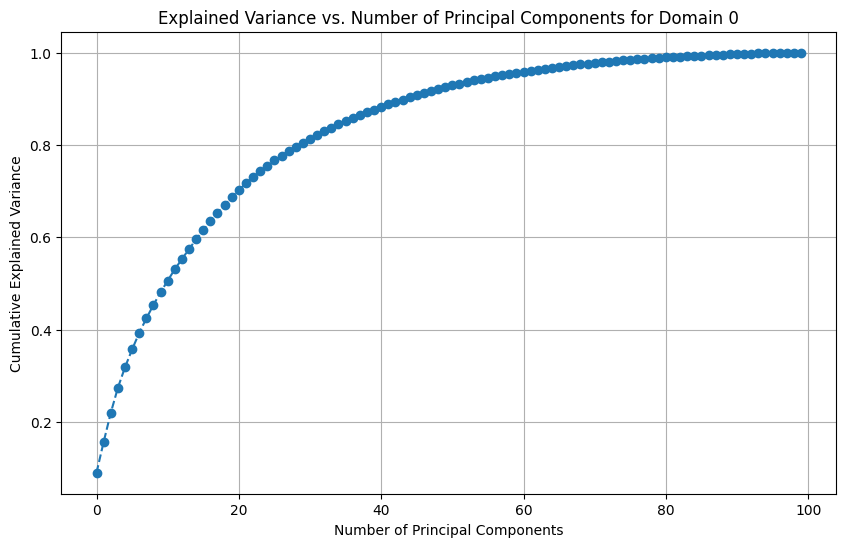

Number of principal components to capture 95.0% variance: 58


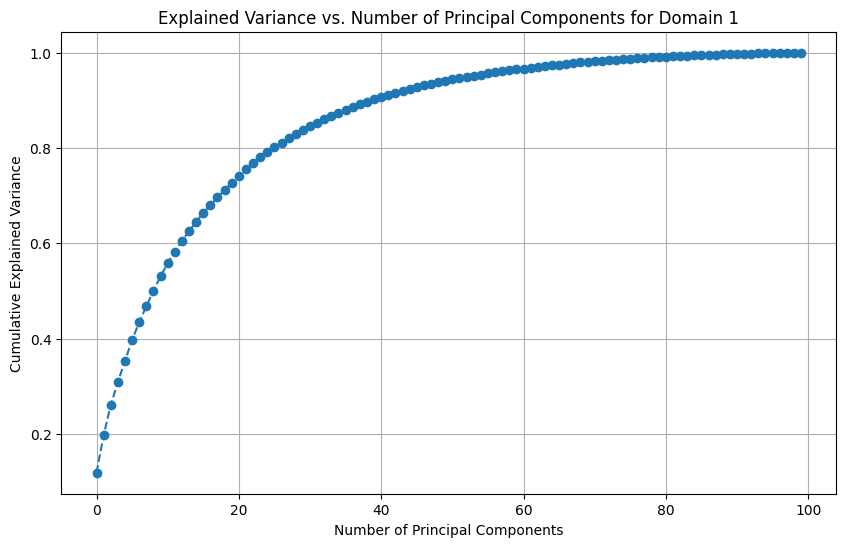

Number of principal components to capture 95.0% variance: 54


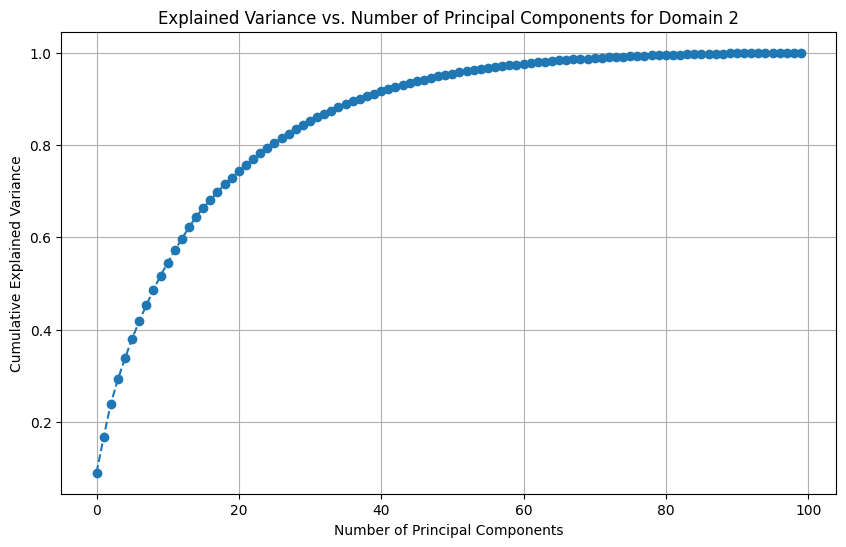

Number of principal components to capture 95.0% variance: 50


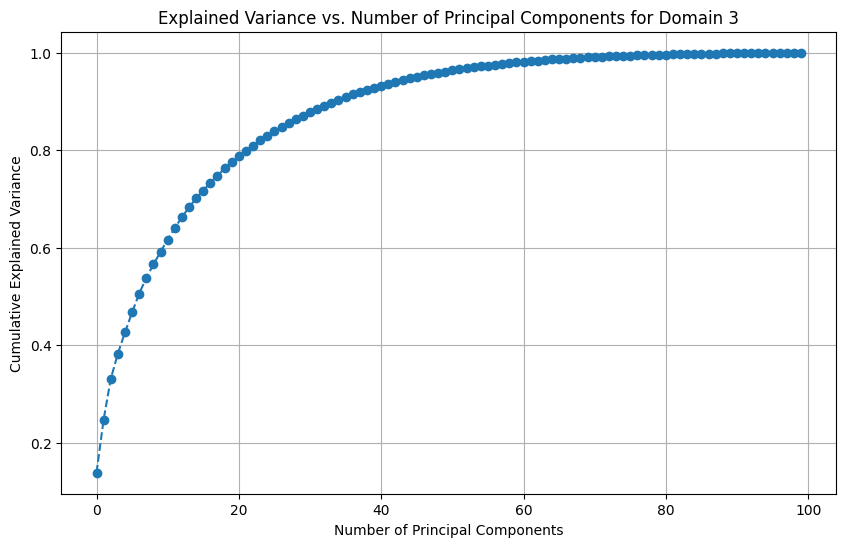

Number of principal components to capture 95.0% variance: 46
Mean of The number of Principal Components with the Highest Variance:  52.0


In [16]:
num_pca_components = []
for d in range(4):
    adjacency_pca_set = simulated_cleaned[:,:,:,:,d]

    # Reshape and flatten the data
    num_graphs, num_time_points, num_nodes, _ = adjacency_pca_set.shape
    flattened_data = adjacency_pca_set.reshape(num_graphs, num_time_points * num_nodes * num_nodes)
    num_pca_components.append(pca_variance_analysis(flattened_data, d))

print("Mean of The number of Principal Components with the Highest Variance: ", np.mean(num_pca_components))

#### Node Features

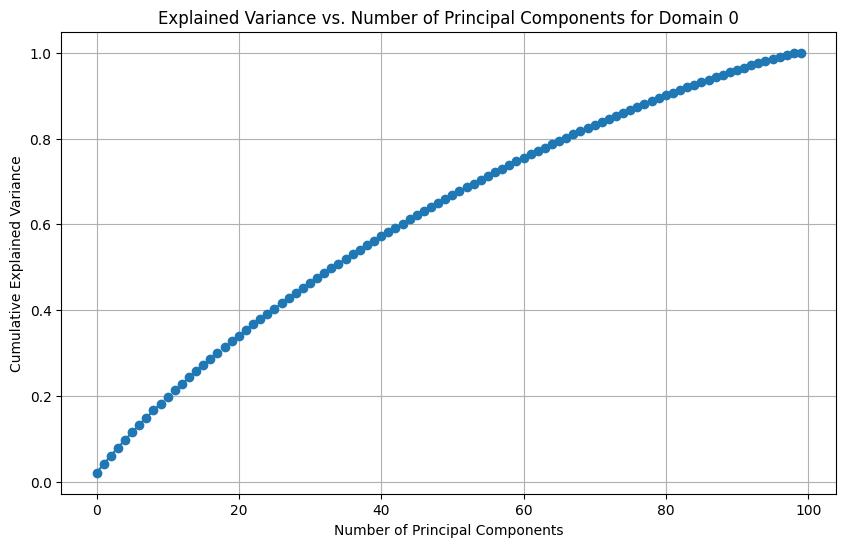

Number of principal components to capture 95.0% variance: 90


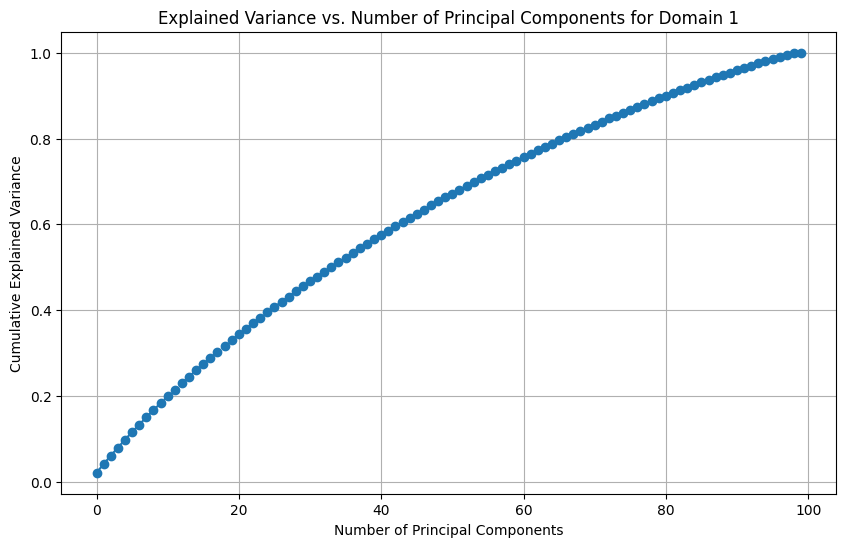

Number of principal components to capture 95.0% variance: 90


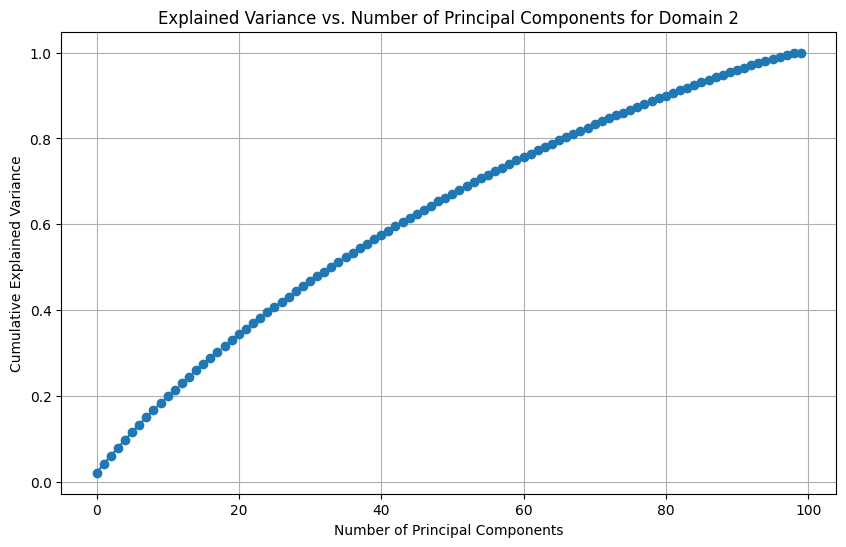

Number of principal components to capture 95.0% variance: 90


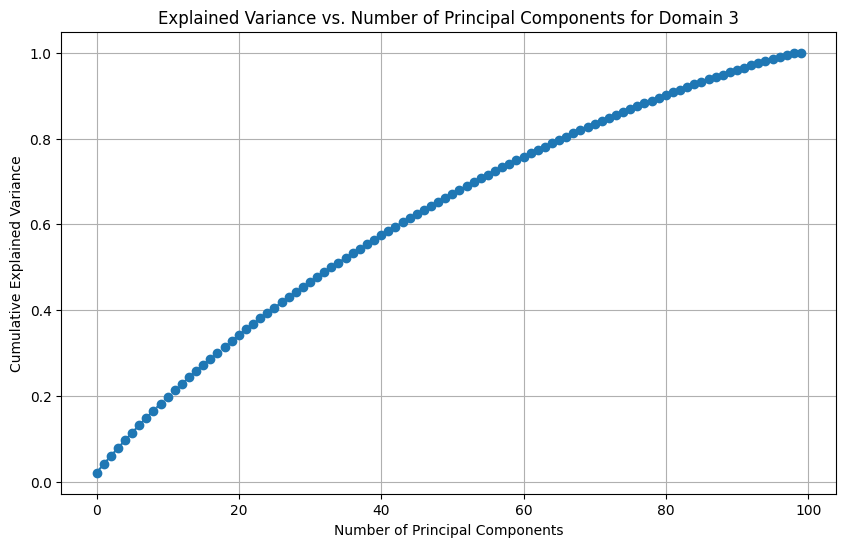

Number of principal components to capture 95.0% variance: 90
Mean of The number of Principal Components with the Highest Variance:  90.0


In [26]:
num_pca_components = []
for d in range(4):
    features_pca_set = node_features_simulated[:,:,:,:,d]

    # Reshape and flatten the data
    num_graphs, num_time_points, num_nodes, num_features = features_pca_set.shape
    flattened_data = features_pca_set.reshape(num_graphs, num_time_points * num_nodes * num_features)
    num_pca_components.append(pca_variance_analysis(flattened_data, d))

print("Mean of The number of Principal Components with the Highest Variance: ", np.mean(num_pca_components))

### SLIM Dataset

#### Adjacency Matrix

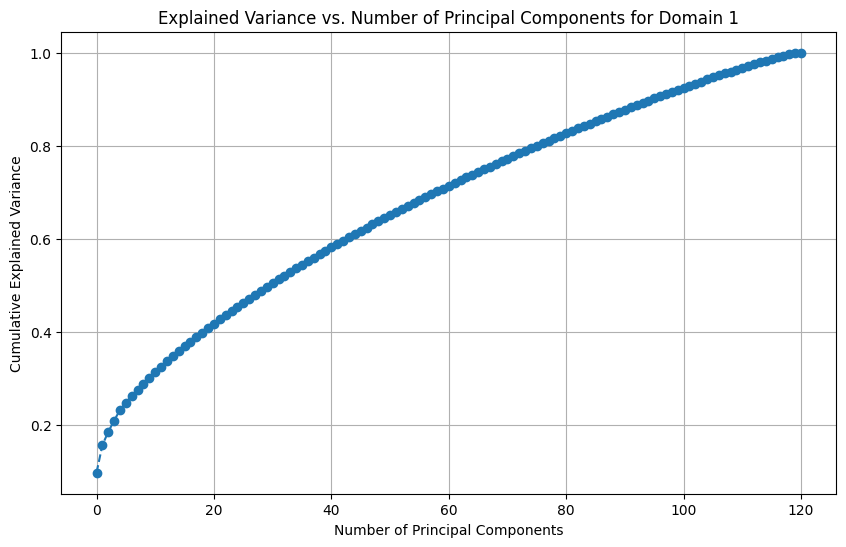

Number of principal components to capture 95.0% variance: 107


107

In [25]:
adjacency_pca = slim160_cleaned

# Reshape and flatten the data
num_graphs, num_time_points, num_nodes, _ = adjacency_pca.shape
flattened_data = adjacency_pca.reshape(num_graphs, num_time_points * num_nodes * num_nodes)
pca_variance_analysis(flattened_data, 1)


In [ ]:
adjacency_pca = slim268_cleaned
num_graphs, num_time_points, num_nodes, _ = adjacency_pca.shape
flattened_data = adjacency_pca.reshape(num_graphs, num_time_points * num_nodes * num_nodes)
pca_variance_analysis(flattened_data, 2)

#### Node Features

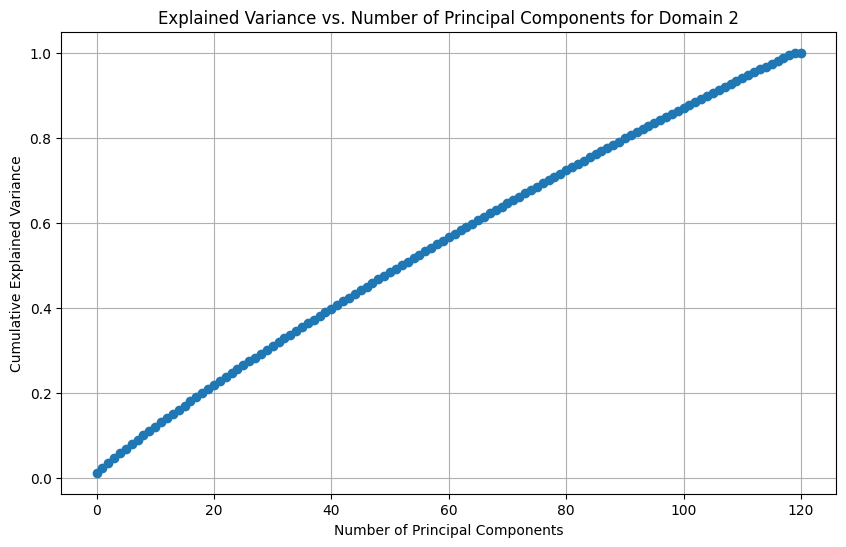

Number of principal components to capture 95.0% variance: 113


113

In [28]:
features_pca = node_features_slim160
num_graphs, num_time_points, num_nodes, num_features = features_pca.shape
flattened_data = features_pca.reshape(num_graphs, num_time_points * num_nodes * num_features)
pca_variance_analysis(flattened_data, 2)

## Graph Normalization

In [14]:
def normalize_adj_matrix(adj):
    # Calculate the degree matrix
    degrees = np.sum(adj, axis=1) # Sum of weights for each node
    degrees[degrees == 0] = 1
    D_hat_inv_sqrt = np.diag(1.0 / np.sqrt(degrees))
    
    # Perform the normalization
    normalized_adj = D_hat_inv_sqrt.dot(adj).dot(D_hat_inv_sqrt)
    
    return normalized_adj

def normalize_graph_dataset(dataset, single=False):
    normalized_dataset = np.zeros_like(dataset)

    if single==False:
        num_graphs, num_timepoints, _, _, num_domain = dataset.shape
        
        for i in range(num_graphs):
            for t in range(num_timepoints):
                for d in range(num_domain):
                    adjacency_matrix = dataset[i, t, :, :, d]
                    normalized_adjacency_matrix = normalize_adj_matrix(adjacency_matrix)
                    normalized_dataset[i, t, :, :, d] = normalized_adjacency_matrix
    else:
        num_graphs, num_timepoints, _, _ = dataset.shape
        
        for i in range(num_graphs):
            for t in range(num_timepoints):
                adjacency_matrix = dataset[i, t, :, :]
                normalized_adjacency_matrix = normalize_adj_matrix(adjacency_matrix)
                normalized_dataset[i, t, :, :] = normalized_adjacency_matrix
    
    return normalized_dataset

### Simulated Dataset

In [15]:
simulated_normalized = normalize_graph_dataset(simulated_cleaned)
simulated_normalized.shape

(100, 3, 35, 35, 4)

### SLIM Dataset

In [16]:
slim160_normalized = normalize_graph_dataset(slim160_cleaned, single=True)
print(slim160_normalized.shape)

slim268_normalized = normalize_graph_dataset(slim268_cleaned, single=True)
print(slim268_normalized.shape)

(121, 3, 160, 160)
(121, 3, 268, 268)


## Data Visualization (Check)

In [77]:
# Visualizing Adjacency Matrices for Each Graph, Time Point, and View
def plot_heatmaps(X, single=False, num_samples=3):
    if single == False:
        num_graphs, num_timepoints, num_nodes, _, num_views = X.shape
        fig, axs = plt.subplots(num_samples * num_views, num_timepoints, figsize=(15, 5 * num_samples * num_views))
        
        for i in range(num_samples):
            for v in range(num_views):
                for t in range(num_timepoints):
                    ax = axs[i * num_views + v, t]
                    sns.heatmap(X[i, t, :, :, v], ax=ax, cmap="YlGnBu")
                    ax.set_title(f"Graph {i+1}, View {v+1}, Timepoint {t+1}")
                    ax.axis('off')
        
        plt.tight_layout()
        plt.show()
    
    else:
        num_graphs, num_timepoints, num_nodes, _ = X.shape
        fig, axs = plt.subplots(num_samples, num_timepoints, figsize=(15, 5 * num_samples))
        
        for i in range(num_samples):
            for t in range(num_timepoints):
                ax = axs[t]
                sns.heatmap(X[i, t, :, :], ax=ax, cmap="YlGnBu")
                ax.set_title(f"Graph {i+1}, Timepoint {t+1}")
                ax.axis('off')
        
        plt.tight_layout()
        plt.show()

### Simulated Dataset

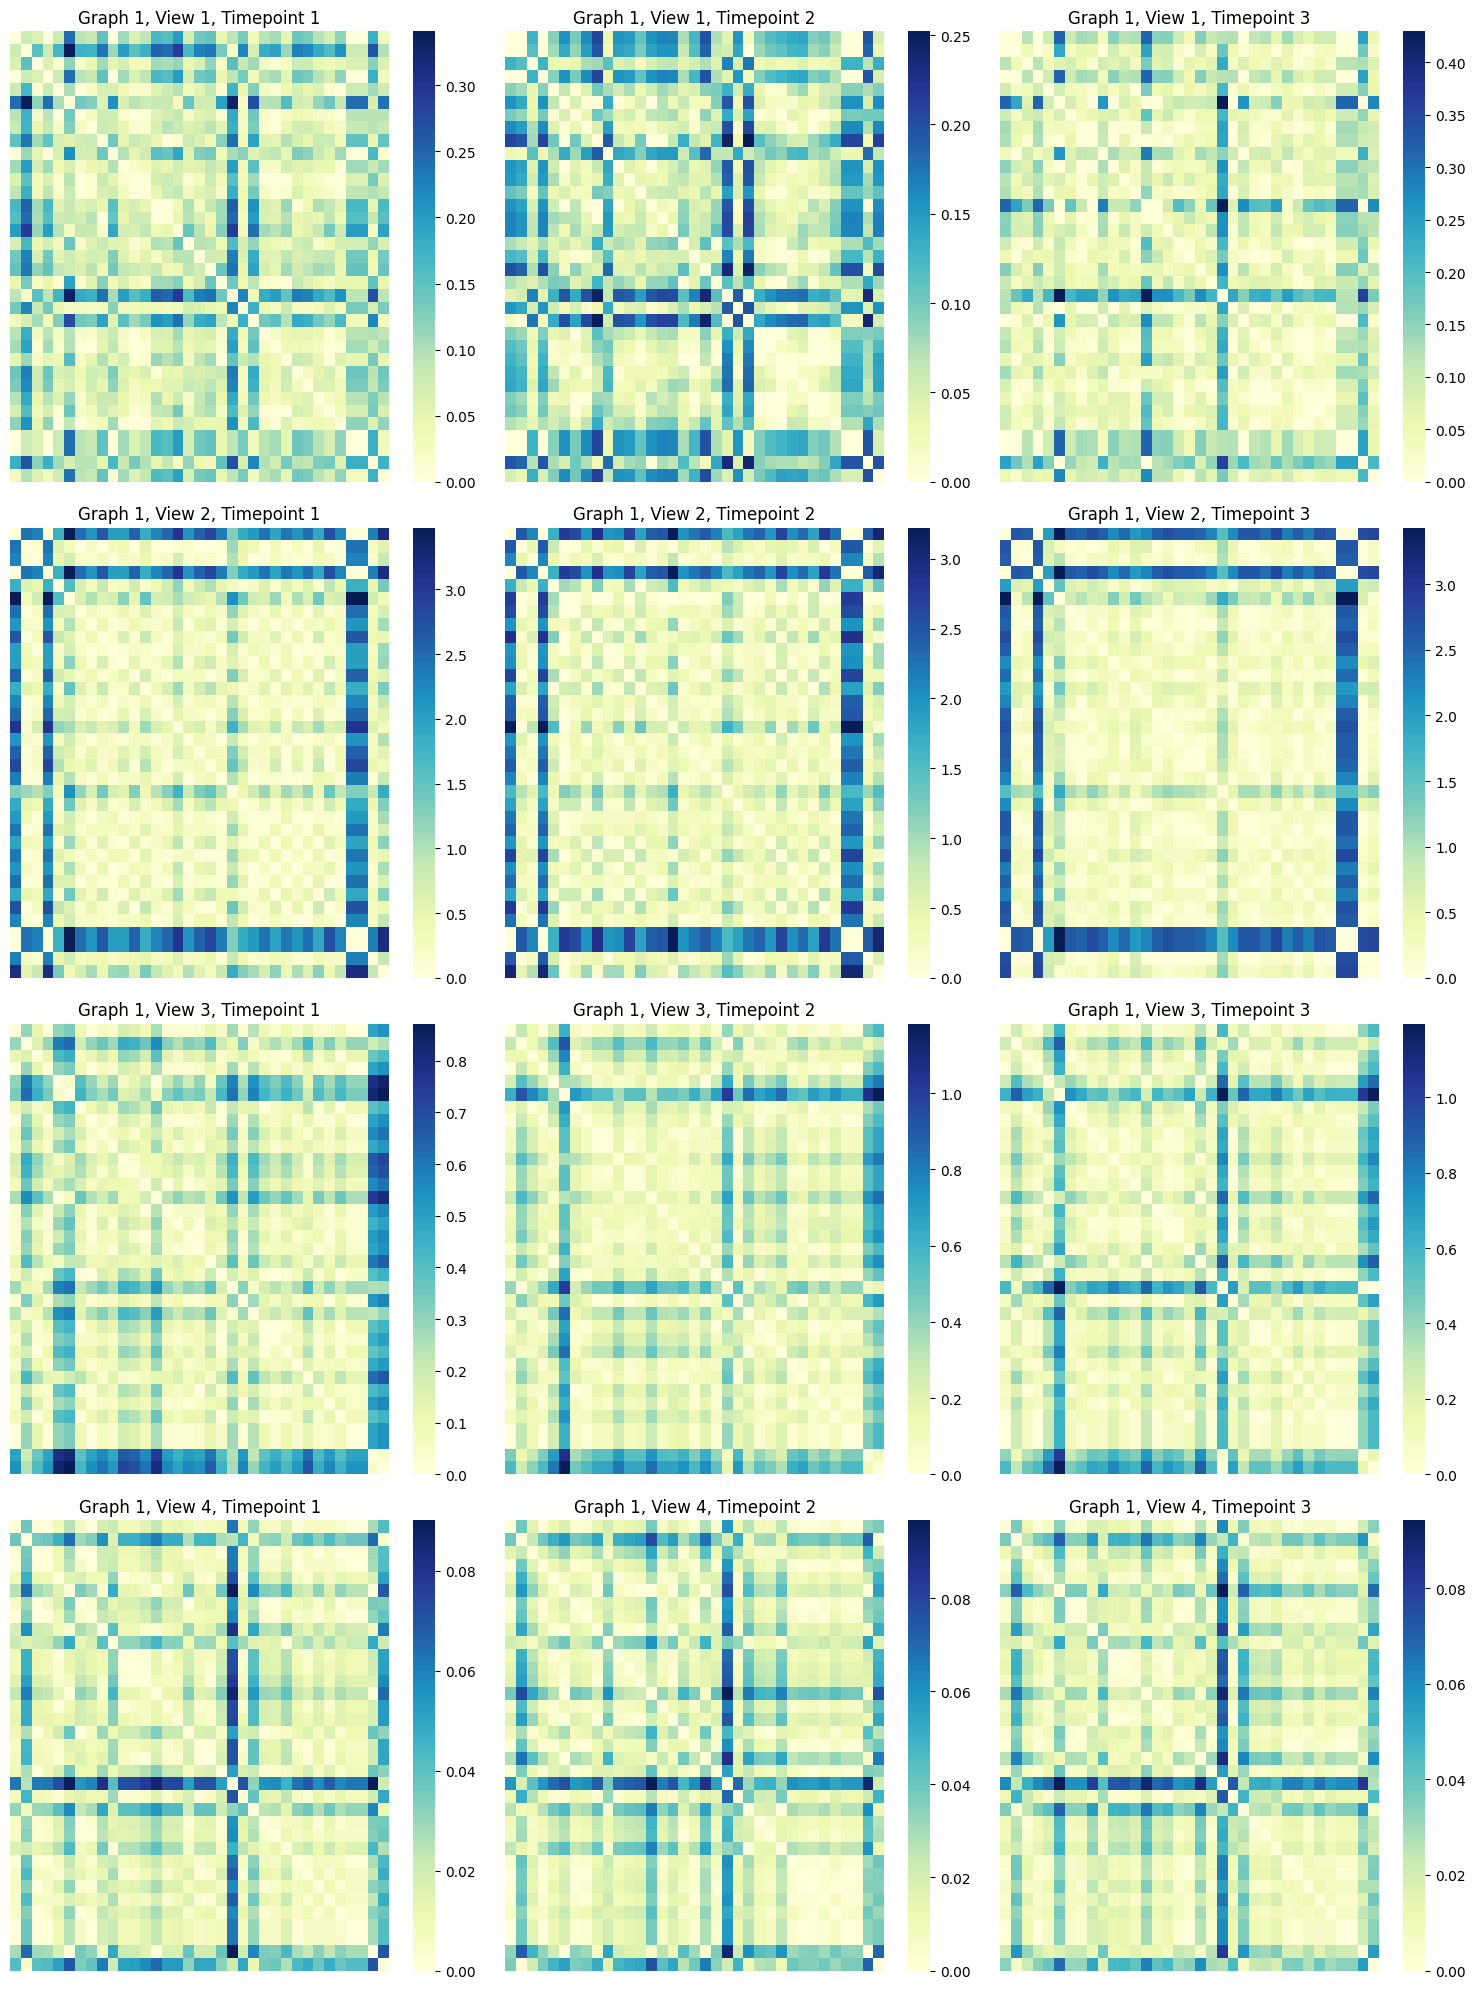

In [72]:
plot_heatmaps(simulated_data, single=False, num_samples=1)


In [ ]:
plot_heatmaps(simulated_cleaned, single=False, num_samples=1)


In [ ]:
plot_heatmaps(simulated_normalized, single=False, num_samples=1)

### SLIM Dataset

original graph data


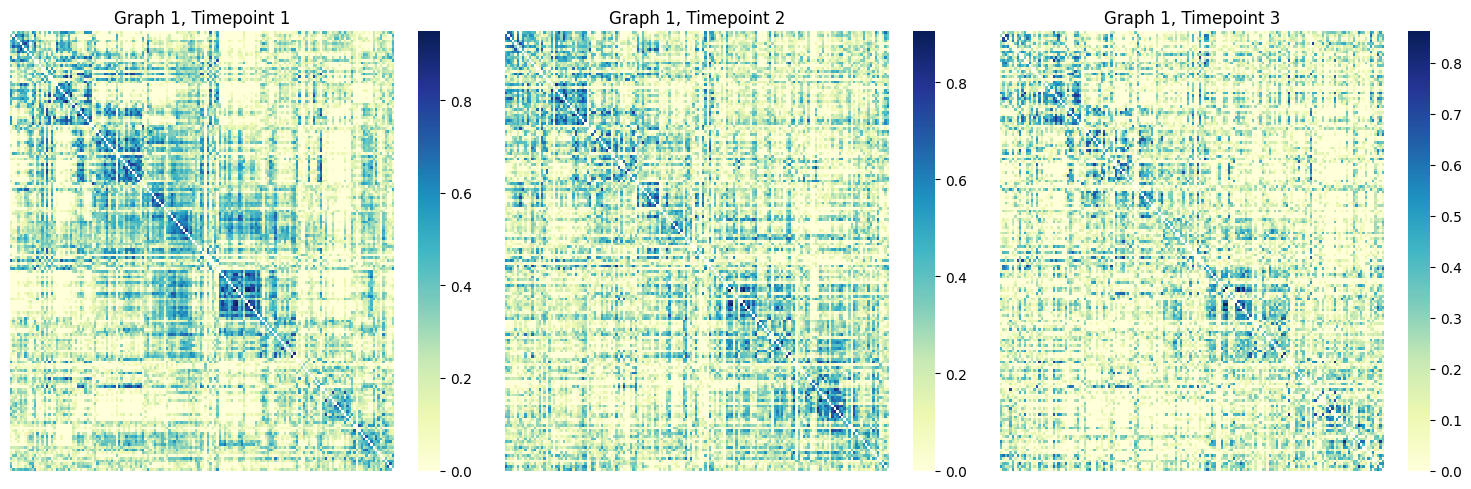


cleaned graph data


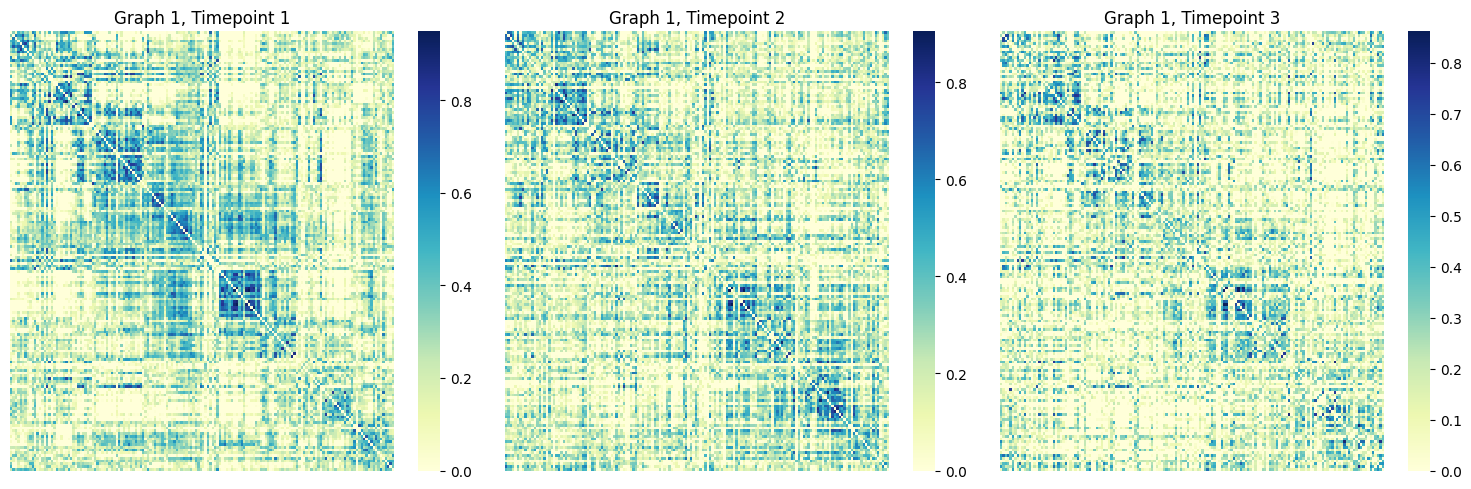


normalized graph data


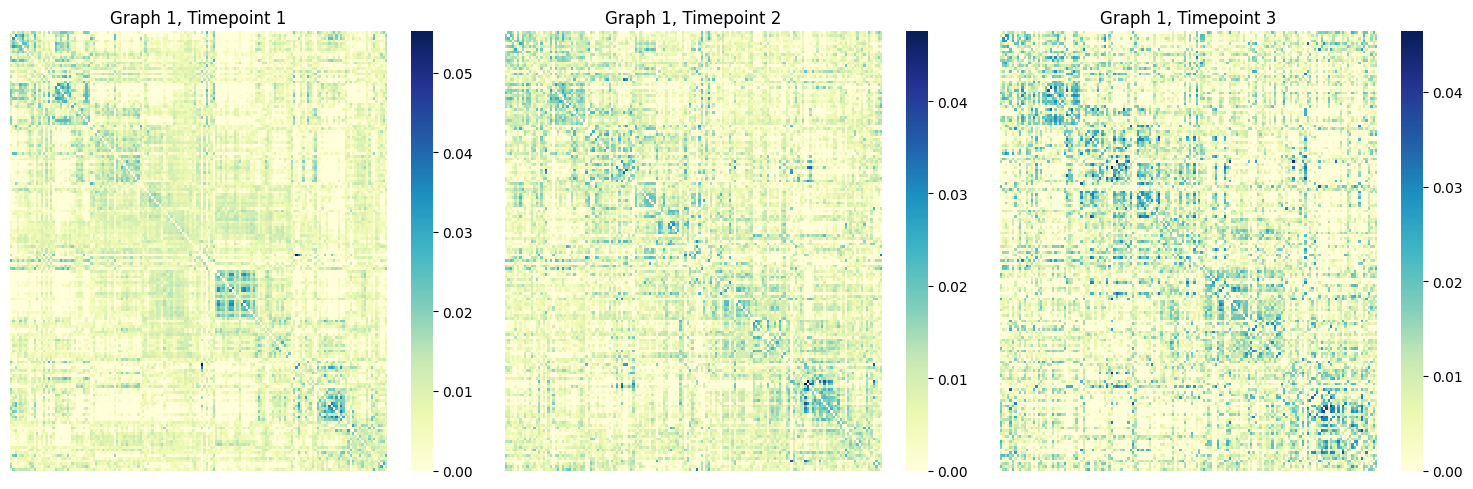

In [80]:
print("original graph data")
plot_heatmaps(slim160, single=True, num_samples=1)

print("\ncleaned graph data")
plot_heatmaps(slim160_cleaned, single=True, num_samples=1)

print("\nnormalized graph data")
plot_heatmaps(slim160_normalized, single=True, num_samples=1)

original graph data


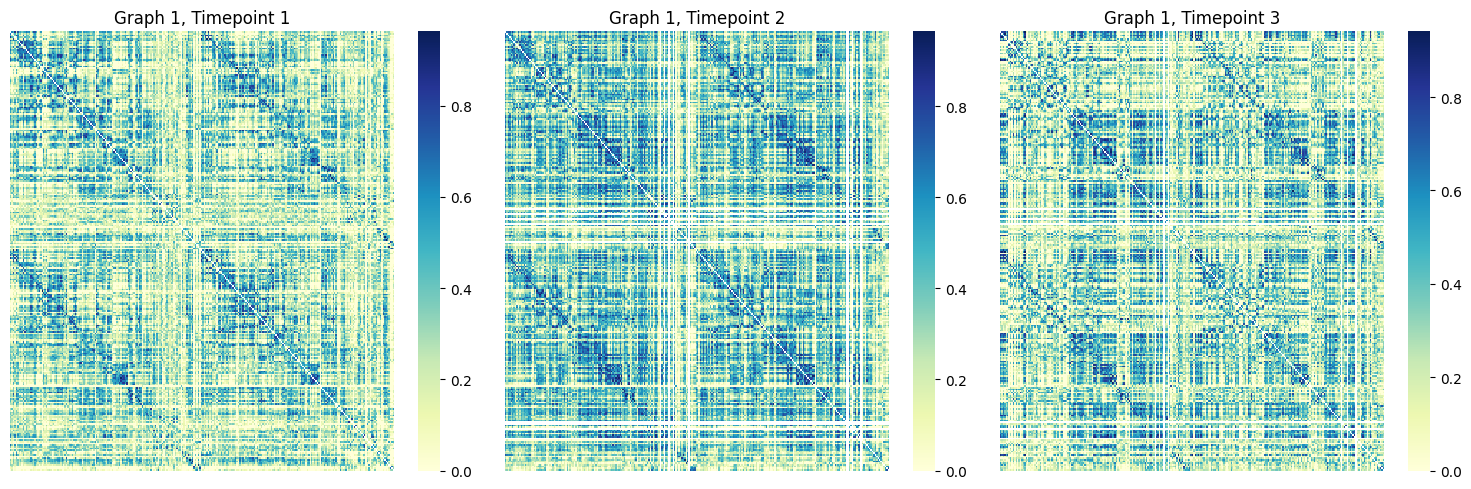


cleaned graph data


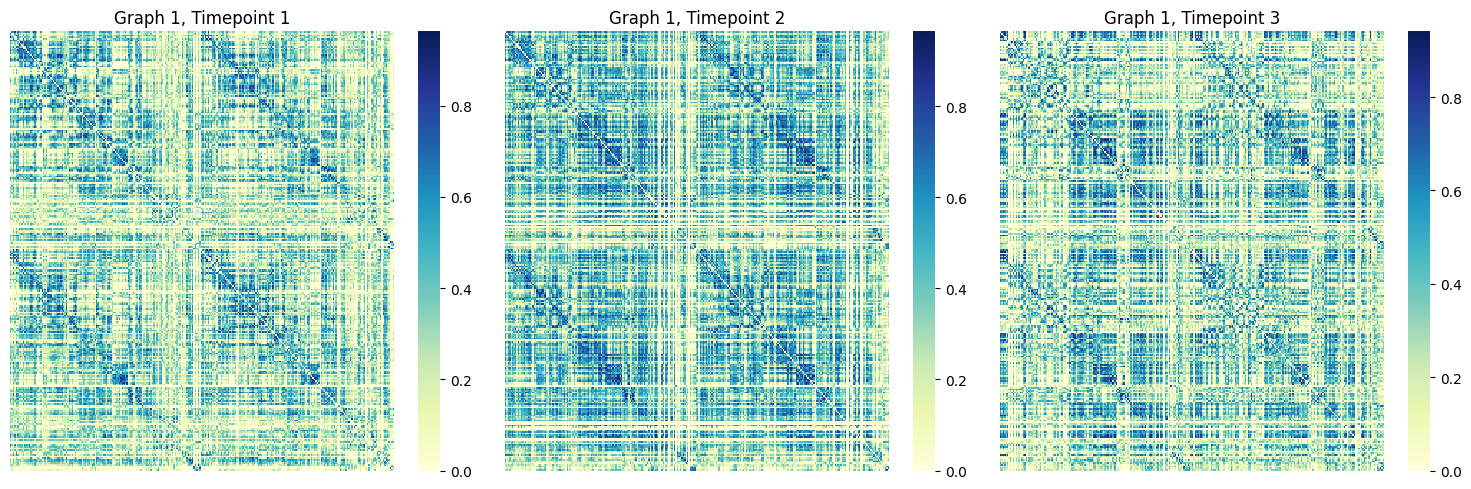


normalized graph data


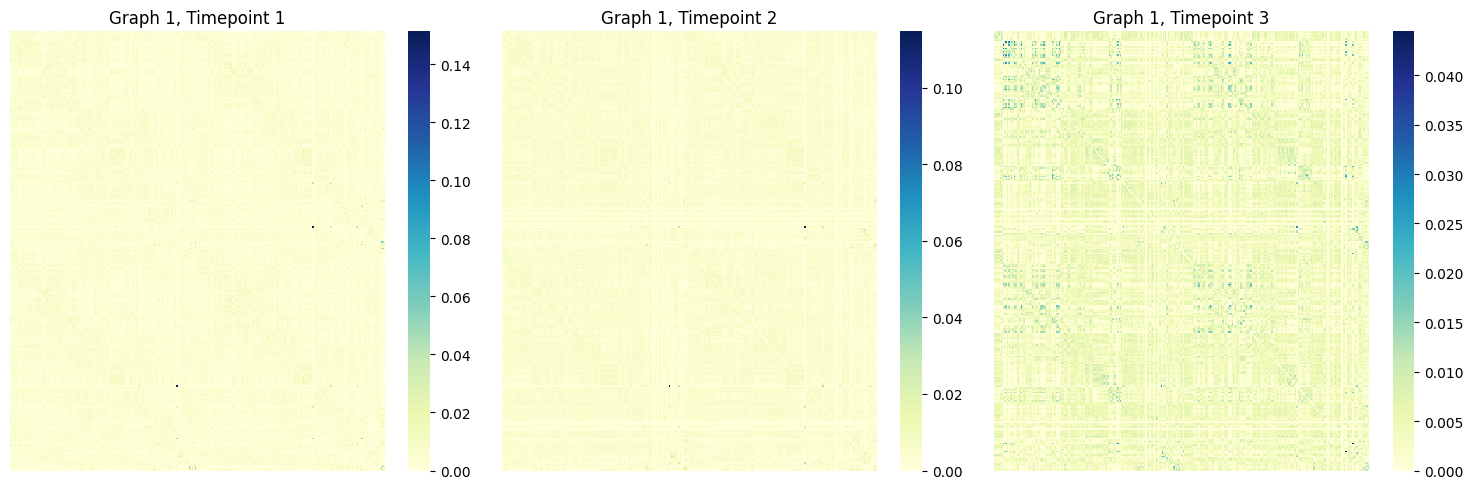

In [81]:
print("original graph data")
plot_heatmaps(slim268, single=True, num_samples=1)

print("\ncleaned graph data")
plot_heatmaps(slim268_cleaned, single=True, num_samples=1)

print("\nnormalized graph data")
plot_heatmaps(slim268_normalized, single=True, num_samples=1)

## Split Train and Test Set

In [17]:
def split_graph_dataset(adj_matrix, node_feature, test_size=0.2, random_state=42):
    # Get the number of graphs
    num_graphs = adj_matrix.shape[0]
    
    # Generate indices for splitting
    indices = np.arange(num_graphs)
    
    # Split the indices
    train_indices, test_indices = train_test_split(indices, test_size=test_size, random_state=random_state)
    
    # Split the adjacency matrices and node features based on the indices
    adj_train, adj_test = adj_matrix[train_indices], adj_matrix[test_indices]
    features_train, features_test = node_feature[train_indices], node_feature[test_indices]
    
    return adj_train, adj_test, features_train, features_test

# Function to split the dataset into training and test sets for each domain
def split_dataset_by_domain(adj_matrix, node_features, test_size=0.2, random_state=42):
    num_subjects, num_timepoints, num_nodes, num_features, num_domains = node_features.shape
    
    # Initialize lists to store train and test sets for each domain
    adj_train_sets, adj_test_sets = [], []
    features_train_sets, features_test_sets = [], []
    
    for domain in range(num_domains):
        # Extract data for the current domain
        adj_domain = adj_matrix[..., domain]
        features_domain = node_features[..., domain]
        
        # Generate subject labels
        subject_labels = np.arange(num_subjects)
        
        # Split the dataset for the current domain
        train_idx, test_idx = train_test_split(subject_labels, test_size=test_size, random_state=random_state)
        
        # Create train and test sets for the current domain
        adj_train, adj_test = adj_domain[train_idx], adj_domain[test_idx]
        features_train, features_test = features_domain[train_idx], features_domain[test_idx]
        
        # Append the train and test sets to the lists
        adj_train_sets.append(adj_train)
        adj_test_sets.append(adj_test)
        features_train_sets.append(features_train)
        features_test_sets.append(features_test)
    
    return adj_train_sets, adj_test_sets, features_train_sets, features_test_sets


#### Simulated Dataset

In [18]:
adj_matrix = simulated_normalized
node_features = node_features_simulated
num_domains = 4
# Split the dataset by domain
adj_train_sets, adj_test_sets, features_train_sets, features_test_sets = split_dataset_by_domain(adj_matrix, node_features)

adj_train_domains = []
features_train_domains = []
adj_test_domains = []
features_test_domains = []

for domain in range(num_domains):
    print(f'Domain {domain+1} - Adjacency Train set shape: {adj_train_sets[domain].shape}, Test set shape: {adj_test_sets[domain].shape}')
    print(f'Domain {domain+1} - Node Features Train set shape: {features_train_sets[domain].shape}, Test set shape: {features_test_sets[domain].shape}')
    
    adj_train_domains.append(torch.tensor(adj_train_sets[domain], dtype=torch.float32))
    features_train_domains.append(torch.tensor(features_train_sets[domain], dtype=torch.float32))
    adj_test_domains.append(torch.tensor(adj_test_sets[domain], dtype=torch.float32))
    features_test_domains.append(torch.tensor(features_test_sets[domain], dtype=torch.float32))

Domain 1 - Adjacency Train set shape: (80, 3, 35, 35), Test set shape: (20, 3, 35, 35)
Domain 1 - Node Features Train set shape: (80, 3, 35, 16), Test set shape: (20, 3, 35, 16)
Domain 2 - Adjacency Train set shape: (80, 3, 35, 35), Test set shape: (20, 3, 35, 35)
Domain 2 - Node Features Train set shape: (80, 3, 35, 16), Test set shape: (20, 3, 35, 16)
Domain 3 - Adjacency Train set shape: (80, 3, 35, 35), Test set shape: (20, 3, 35, 35)
Domain 3 - Node Features Train set shape: (80, 3, 35, 16), Test set shape: (20, 3, 35, 16)
Domain 4 - Adjacency Train set shape: (80, 3, 35, 35), Test set shape: (20, 3, 35, 35)
Domain 4 - Node Features Train set shape: (80, 3, 35, 16), Test set shape: (20, 3, 35, 16)


In [19]:
## Training with simulated data
adj_train_domain_1 = adj_train_domains[0]
adj_train_domain_2 = adj_train_domains[1]
adj_train_domain_3 = adj_train_domains[2]
adj_train_domain_4 = adj_train_domains[3] 

x_train_domain_1 = features_train_domains[0]
x_train_domain_2 = features_train_domains[1]
x_train_domain_3 = features_train_domains[2]
x_train_domain_4 = features_train_domains[3]


## Testing with simulated data
adj_test_domain_1 = adj_test_domains[0]
adj_test_domain_2 = adj_test_domains[1]
adj_test_domain_3 = adj_test_domains[2]
adj_test_domain_4 = adj_test_domains[3] 

x_test_domain_1 = features_test_domains[0]
x_test_domain_2 = features_test_domains[1]
x_test_domain_3 = features_test_domains[2]
x_test_domain_4 = features_test_domains[3]

#### SLIM Dataset

In [57]:
adj_train_slim160, adj_test_slim160, features_train_slim160, features_test_slim160 = split_graph_dataset(slim160_normalized, node_features_slim160)

# Print shapes to verify
print(f'adj_train_slim160 shape: {adj_train_slim160.shape}')
print(f'adj_test_slim160 shape: {adj_test_slim160.shape}')
print(f'features_train_160 shape: {features_train_slim160.shape}')
print(f'features_test_slim160 shape: {features_test_slim160.shape}')

adj_train_slim268, adj_test_slim268, features_train_slim268, features_test_slim268 = split_graph_dataset(slim268_normalized, node_features_slim268)

# Print shapes to verify
print(f'\nadj_train_slim268 shape: {adj_train_slim268.shape}')
print(f'adj_test_slim268 shape: {adj_test_slim268.shape}')
print(f'features_train_268 shape: {features_train_slim268.shape}')
print(f'features_test_slim268 shape: {features_test_slim268.shape}')

adj_train_slim160 shape: (96, 3, 160, 160)
adj_test_slim160 shape: (25, 3, 160, 160)
features_train_160 shape: (96, 3, 160, 32)
features_test_slim160 shape: (25, 3, 160, 32)

adj_train_slim268 shape: (96, 3, 268, 268)
adj_test_slim268 shape: (25, 3, 268, 268)
features_train_268 shape: (96, 3, 268, 32)
features_test_slim268 shape: (25, 3, 268, 32)


In [58]:
adj_train_slim160 = torch.tensor(adj_train_slim160, dtype=torch.float32) 
x_train_slim160 = torch.tensor(features_train_slim160, dtype=torch.float32)  
adj_test_slim160 = torch.tensor(adj_test_slim160, dtype=torch.float32)  
x_test_slim160 = torch.tensor(features_test_slim160, dtype=torch.float32)  

adj_train_slim268 = torch.tensor(adj_train_slim268, dtype=torch.float32)
x_train_slim268 = torch.tensor(features_train_slim268, dtype=torch.float32)
adj_test_slim268 = torch.tensor(adj_test_slim268, dtype=torch.float32)
x_test_slim268 = torch.tensor(features_test_slim268, dtype=torch.float32)

# Model

### Building Blocks

In [22]:
class GCN(nn.Module):
    def __init__(self, in_features, out_features, bias=True):
        super(GCN, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = nn.Parameter(torch.FloatTensor(in_features, out_features))
        # print("gcn weight init:",self.weight.size())
        if bias:
            self.bias = nn.Parameter(torch.FloatTensor(out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.uniform_(-stdv, stdv)

    def forward(self, input, adj):
        # print("gcn weight forward:",self.weight.size())
        support = torch.mm(input, self.weight)
        output = torch.spmm(adj, support)
        if self.bias is not None:
            return output + self.bias
        else:
            return output

    def __repr__(self):
        return self.__class__.__name__ + ' (' \
               + str(self.in_features) + ' -> ' \
               + str(self.out_features) + ')'

class GCNEncoder(nn.Module):
    def __init__(self, input_dim, feature_dim, latent_dim):
        super(GCNEncoder, self).__init__()
        self.num_nodes = input_dim
        self.feature_dim = feature_dim
        self.hidden_dim = 2 * feature_dim
        self.latent_dim = latent_dim
        
        # GCN layers
        self.conv1 = GCN(feature_dim, self.hidden_dim)
        self.bn1 = nn.BatchNorm1d(self.hidden_dim)
        self.conv2 = GCN(self.hidden_dim, self.latent_dim)
        self.bn2 = nn.BatchNorm1d(self.latent_dim)
        
        self.fc_mu = nn.Linear(self.latent_dim, self.latent_dim)
        self.fc_logvar = nn.Linear(self.latent_dim, self.latent_dim)

    def forward(self, x, adj):
        # GCN layers
        x = F.relu(self.bn1(self.conv1(x, adj)))
        x = F.dropout(x, training=self.training)
        x = F.relu(self.bn2(self.conv2(x, adj)))
        x = F.dropout(x, training=self.training)
        
        # Node features properties
        x_mean = x.mean(dim=0)
        mu = self.fc_mu(x_mean)
        logvar = self.fc_logvar(x_mean)

        # Reparameterization trick
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std

        return z, mu, logvar

class GCNDecoder(nn.Module):
    def __init__(self, latent_dim, num_nodes):
        super(GCNDecoder, self).__init__()
        self.latent_dim = latent_dim
        self.num_nodes = num_nodes
        
        # Fully connected layer to expand z to node features
        self.fc = nn.Linear(latent_dim, num_nodes * latent_dim)
        self.bn0 = nn.BatchNorm1d(latent_dim)

        # GCN layers
        self.conv1 = GCN(latent_dim, latent_dim * 2)
        self.bn1 = nn.BatchNorm1d(latent_dim * 2)
        self.conv2 = GCN(latent_dim * 2, num_nodes * 2)
        self.bn2 = nn.BatchNorm1d(num_nodes * 2)
        self.conv3 = GCN(num_nodes * 2, num_nodes)
        self.bn3 = nn.BatchNorm1d(num_nodes)
    
    def forward(self, z):
        # Expand z to node features
        x = self.bn0(self.fc(z).view(self.num_nodes, self.latent_dim))

        # Initial adjacency matrix (identity matrix)
        adj = torch.eye(self.num_nodes, device=z.device)

        # Pass through GCN layers
        x = F.relu(self.bn1(self.conv1(x, adj)))
        x = F.dropout(x, training=self.training)
        x = F.relu(self.bn2(self.conv2(x, adj)))
        x = F.dropout(x, training=self.training)
        x = F.relu(self.bn3(self.conv3(x, adj)))
        x = F.dropout(x, training=self.training)

        # Generate adjacency matrix
        adj_pred = x

        # Ensure symmetry of the adjacency matrix
        adj_pred = (adj_pred + adj_pred.t()) / 2
        
        # Set the diagonal elements to zero (no self-connections)
        adj_pred = adj_pred - torch.diag(torch.diag(adj_pred))
        return adj_pred


In [23]:
class GCRN_gcn(nn.Module):
    def __init__(self, input_dim, feature_dim, latent_dim, num_layers=2):
        super(GCRN_gcn, self).__init__()
        self.hidden_dim = latent_dim
        self.num_layers = num_layers

        self.encoder = GCNEncoder(input_dim, feature_dim, latent_dim)
        # Create a vanilla GRU layer with the specified number of layers
        self.gru = nn.GRU(latent_dim, self.hidden_dim, num_layers)
        self.decoder = GCNDecoder(latent_dim, input_dim)  

    def forward(self, x, adj):
        num_nodes, feature_dim = x.size()
        
        # Encode the current time point
        z, mu, logvar = self.encoder(x, adj)
        z = z.unsqueeze(0).unsqueeze(0) 
        
        # Initialize hidden states for GRU
        h = torch.zeros(self.num_layers, 1, self.hidden_dim, device=x.device)  

        # Update latent representation using the GRU
        z, h = self.gru(z, h)
        z = z.squeeze(0).squeeze(0) 
        
        # Decode the updated latent representation to predict the adjacency matrix for the next time point
        adj_pred = self.decoder(z)
        
        return adj_pred, mu, logvar, z
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)


### Loss Function

In [24]:
def loss_function(recon_adj, adj, mu, logvar, lambda_1=1.0, lambda_2=1):
    # Generative loss
    gen_loss = F.l1_loss(recon_adj, adj, reduction='sum')
    
    # Topological loss
    node_strength_recon = torch.sum(recon_adj, dim=1)
    node_strength_gt = torch.sum(adj, dim=1)
    top_loss = F.mse_loss(node_strength_recon, node_strength_gt, reduction='sum')
    
    # KLD loss
    kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    # Total loss
    loss = gen_loss + (lambda_1 * top_loss) + (lambda_2 * kld_loss)
    return loss

## Training

In [25]:
def train_model(model, train_features, train_adj, num_epochs=100, lr=0.001, save_path='models/gcrn_model.pth'):
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    training_loss = []

    epoch_time = []
    cpu_usage = []
    memory_usage = []
    
    images = []

    with tempfile.TemporaryDirectory() as tmp_dir:
        for epoch in range(num_epochs):
            model.train()
            epoch_loss = 0
            epoch_start_time = time.time()
            cpu_usage = []
            memory_usage = []

            latent_spaces = []
            time_labels = []

            for i in tqdm(range(train_features.size(0)), desc=f'Epoch {epoch+1}/{num_epochs}'):
                for t in range(train_features.size(1) - 1):
                    optimizer.zero_grad()
                    
                    x_t = train_features[i, t]
                    adj_t = train_adj[i, t]
                    adj_t_next = train_adj[i, t+1]
                    
                    recon_adj, mu, logvar, z = model(x_t, adj_t)
                    loss = loss_function(recon_adj, adj_t_next, mu, logvar)
                    loss.backward()
                    optimizer.step()
                    epoch_loss += loss.item()
                    
                    # latent_spaces.append(z.detach().cpu().numpy())
                    time_labels.append(t)

            epoch_end_time = time.time()
            epoch_time.append(epoch_end_time - epoch_start_time)
            cpu_usage.append(psutil.cpu_percent(interval=None))
            memory_usage.append(psutil.virtual_memory().percent)

            epoch_loss /= (train_features.size(0) * (train_features.size(1) - 1))
            training_loss.append(epoch_loss)
            
            # # Plotting t-SNE of the latent spaces for the current epoch
            # zs = np.vstack(latent_spaces)
            # ts = np.array(time_labels)
            # z_tsne = TSNE(n_components=2).fit_transform(zs)
            
            # plt.figure(figsize=(10, 8))
            
            # for t in np.unique(ts):
            #     idx = ts == t 
            #     plt.scatter(z_tsne[idx, 0], z_tsne[idx, 1], label=f'Time {t}', alpha=0.5)
        
            # plt.title(f't-SNE of VAE Latent Representations (Epoch {epoch+1})')
            # plt.xlabel('t-SNE Dimension 1')
            # plt.ylabel('t-SNE Dimension 2')
            # plt.legend(title='Time point', loc='best')

            # # Save the plot as an image file in the temporary directory
            # plot_filename = os.path.join(tmp_dir, f'tsne_epoch_{epoch+1}.png')
            # plt.savefig(plot_filename)
            # images.append(imageio.imread(plot_filename))
            # plt.close()
            
            print(f'Epoch {epoch + 1}, Loss: {epoch_loss}')
            print(f'Time: {epoch_time[-1]:.2f}s, CPU: {cpu_usage[-1]:.2f}%, Memory: {memory_usage[-1]:.2f}%\n')

        # Plot the training loss
        plt.plot(training_loss)
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training Loss')
        plt.show()

        # Save the trained model
        torch.save(model.state_dict(), save_path)
        print(f'Model saved to {save_path}')

        print(f'Average Time per Epoch: {np.mean(epoch_time):.2f}s')
        print(f'Average CPU Usage: {np.mean(cpu_usage):.2f}%')
        print(f'Average Memory Usage: {np.mean(memory_usage):.2f}%')

        print(f'\nSum Time per Epoch: {np.sum(epoch_time):.2f}s')
        print(f'Sum CPU Usage: {np.sum(cpu_usage):.2f}%')
        print(f'Sum Memory Usage: {np.sum(memory_usage):.2f}%')

        # # Create the gif animation
        # gif_filename = 'latent_space_analysis/latent_space_animation.gif'
        # imageio.mimsave(gif_filename, images, fps=2)
        # print(f'Animation saved to {gif_filename}')


#### Simulated Dataset

GCRN_gcn(
  (encoder): GCNEncoder(
    (conv1): GCN (16 -> 32)
    (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): GCN (32 -> 46)
    (bn2): BatchNorm1d(46, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (fc_mu): Linear(in_features=46, out_features=46, bias=True)
    (fc_logvar): Linear(in_features=46, out_features=46, bias=True)
  )
  (gru): GRU(46, 46, num_layers=2)
  (decoder): GCNDecoder(
    (fc): Linear(in_features=46, out_features=1610, bias=True)
    (bn0): BatchNorm1d(46, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv1): GCN (46 -> 92)
    (bn1): BatchNorm1d(92, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): GCN (92 -> 70)
    (bn2): BatchNorm1d(70, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): GCN (70 -> 35)
    (bn3): BatchNorm1d(35, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)
Total number o

Epoch 1/100: 100%|██████████| 80/80 [00:02<00:00, 39.82it/s]


Epoch 1, Loss: 6169.183624267578
Time: 2.01s, CPU: 15.90%, Memory: 11.60%



Epoch 2/100: 100%|██████████| 80/80 [00:02<00:00, 40.00it/s]


Epoch 2, Loss: 5558.427276611328
Time: 2.00s, CPU: 77.00%, Memory: 11.60%



Epoch 3/100: 100%|██████████| 80/80 [00:05<00:00, 13.42it/s]


Epoch 3, Loss: 4986.240686035157
Time: 5.97s, CPU: 86.10%, Memory: 11.60%



Epoch 4/100: 100%|██████████| 80/80 [00:08<00:00,  9.16it/s]


Epoch 4, Loss: 4354.279428100586
Time: 8.74s, CPU: 86.50%, Memory: 11.60%



Epoch 5/100: 100%|██████████| 80/80 [00:01<00:00, 42.01it/s]


Epoch 5, Loss: 3601.246469116211
Time: 1.91s, CPU: 77.80%, Memory: 11.70%



Epoch 6/100: 100%|██████████| 80/80 [00:02<00:00, 35.23it/s]


Epoch 6, Loss: 2909.461808013916
Time: 2.27s, CPU: 78.80%, Memory: 11.60%



Epoch 7/100: 100%|██████████| 80/80 [00:01<00:00, 46.22it/s]


Epoch 7, Loss: 2207.9527450561523
Time: 1.73s, CPU: 77.40%, Memory: 11.70%



Epoch 8/100: 100%|██████████| 80/80 [00:05<00:00, 14.26it/s]


Epoch 8, Loss: 1687.9311138153075
Time: 5.61s, CPU: 84.80%, Memory: 11.60%



Epoch 9/100: 100%|██████████| 80/80 [00:01<00:00, 43.36it/s]


Epoch 9, Loss: 1330.697110748291
Time: 1.85s, CPU: 76.40%, Memory: 11.60%



Epoch 10/100: 100%|██████████| 80/80 [00:02<00:00, 31.90it/s]


Epoch 10, Loss: 995.9394248962402
Time: 2.51s, CPU: 79.90%, Memory: 11.60%



Epoch 11/100: 100%|██████████| 80/80 [00:01<00:00, 40.24it/s]


Epoch 11, Loss: 790.1523271560669
Time: 1.99s, CPU: 77.00%, Memory: 11.70%



Epoch 12/100: 100%|██████████| 80/80 [00:06<00:00, 11.77it/s]


Epoch 12, Loss: 625.3775478363037
Time: 6.80s, CPU: 86.00%, Memory: 11.70%



Epoch 13/100: 100%|██████████| 80/80 [00:07<00:00, 10.17it/s]


Epoch 13, Loss: 481.0001135826111
Time: 7.87s, CPU: 85.60%, Memory: 11.60%



Epoch 14/100: 100%|██████████| 80/80 [00:02<00:00, 38.34it/s]


Epoch 14, Loss: 373.43284091949465
Time: 2.09s, CPU: 77.90%, Memory: 11.60%



Epoch 15/100: 100%|██████████| 80/80 [00:12<00:00,  6.22it/s]


Epoch 15, Loss: 309.013836812973
Time: 12.87s, CPU: 87.70%, Memory: 11.60%



Epoch 16/100: 100%|██████████| 80/80 [00:06<00:00, 11.96it/s]


Epoch 16, Loss: 241.0944143295288
Time: 6.69s, CPU: 85.80%, Memory: 11.60%



Epoch 17/100: 100%|██████████| 80/80 [00:01<00:00, 42.69it/s]


Epoch 17, Loss: 203.9697334766388
Time: 1.88s, CPU: 76.60%, Memory: 11.60%



Epoch 18/100: 100%|██████████| 80/80 [00:02<00:00, 37.10it/s]


Epoch 18, Loss: 172.42571535110474
Time: 2.16s, CPU: 78.30%, Memory: 11.60%



Epoch 19/100: 100%|██████████| 80/80 [00:02<00:00, 36.25it/s]


Epoch 19, Loss: 135.18923058509827
Time: 2.21s, CPU: 78.70%, Memory: 11.60%



Epoch 20/100: 100%|██████████| 80/80 [00:02<00:00, 38.68it/s]


Epoch 20, Loss: 120.34615819454193
Time: 2.07s, CPU: 76.10%, Memory: 11.60%



Epoch 21/100: 100%|██████████| 80/80 [00:02<00:00, 39.95it/s]


Epoch 21, Loss: 106.19708964824676
Time: 2.01s, CPU: 78.00%, Memory: 11.70%



Epoch 22/100: 100%|██████████| 80/80 [00:02<00:00, 38.28it/s]


Epoch 22, Loss: 95.01503043174743
Time: 2.09s, CPU: 78.00%, Memory: 11.70%



Epoch 23/100: 100%|██████████| 80/80 [00:02<00:00, 36.67it/s]


Epoch 23, Loss: 85.42356176376343
Time: 2.18s, CPU: 77.10%, Memory: 11.70%



Epoch 24/100: 100%|██████████| 80/80 [00:02<00:00, 30.97it/s]


Epoch 24, Loss: 75.06112387180329
Time: 2.59s, CPU: 78.20%, Memory: 11.70%



Epoch 25/100: 100%|██████████| 80/80 [00:02<00:00, 34.81it/s]


Epoch 25, Loss: 74.26950378417969
Time: 2.30s, CPU: 77.80%, Memory: 11.70%



Epoch 26/100: 100%|██████████| 80/80 [00:02<00:00, 34.06it/s]


Epoch 26, Loss: 69.07011334896087
Time: 2.35s, CPU: 79.80%, Memory: 11.60%



Epoch 27/100: 100%|██████████| 80/80 [00:02<00:00, 38.87it/s]


Epoch 27, Loss: 65.52603917121887
Time: 2.06s, CPU: 77.20%, Memory: 11.60%



Epoch 28/100: 100%|██████████| 80/80 [00:02<00:00, 39.34it/s]


Epoch 28, Loss: 63.30626525878906
Time: 2.04s, CPU: 78.00%, Memory: 11.60%



Epoch 29/100: 100%|██████████| 80/80 [00:02<00:00, 30.63it/s]


Epoch 29, Loss: 59.24609410762787
Time: 2.61s, CPU: 78.90%, Memory: 11.70%



Epoch 30/100: 100%|██████████| 80/80 [00:02<00:00, 34.11it/s]


Epoch 30, Loss: 58.42287127971649
Time: 2.36s, CPU: 77.40%, Memory: 11.70%



Epoch 31/100: 100%|██████████| 80/80 [00:02<00:00, 33.80it/s]


Epoch 31, Loss: 57.01557047367096
Time: 2.37s, CPU: 79.40%, Memory: 11.70%



Epoch 32/100: 100%|██████████| 80/80 [00:02<00:00, 36.59it/s]


Epoch 32, Loss: 54.87422139644623
Time: 2.19s, CPU: 77.80%, Memory: 11.70%



Epoch 33/100: 100%|██████████| 80/80 [00:02<00:00, 31.12it/s]


Epoch 33, Loss: 52.42475810050964
Time: 2.58s, CPU: 78.90%, Memory: 11.70%



Epoch 34/100: 100%|██████████| 80/80 [00:02<00:00, 32.67it/s]


Epoch 34, Loss: 51.01586833000183
Time: 2.46s, CPU: 77.90%, Memory: 11.60%



Epoch 35/100: 100%|██████████| 80/80 [00:02<00:00, 28.99it/s]


Epoch 35, Loss: 51.49598736763001
Time: 2.76s, CPU: 79.20%, Memory: 11.60%



Epoch 36/100: 100%|██████████| 80/80 [00:02<00:00, 29.14it/s]


Epoch 36, Loss: 49.99053127765656
Time: 2.75s, CPU: 79.50%, Memory: 11.60%



Epoch 37/100: 100%|██████████| 80/80 [00:02<00:00, 30.83it/s]


Epoch 37, Loss: 48.131687021255495
Time: 2.60s, CPU: 78.90%, Memory: 11.70%



Epoch 38/100: 100%|██████████| 80/80 [00:02<00:00, 39.09it/s]


Epoch 38, Loss: 50.87608540058136
Time: 2.05s, CPU: 76.80%, Memory: 11.70%



Epoch 39/100: 100%|██████████| 80/80 [00:05<00:00, 13.42it/s]


Epoch 39, Loss: 47.013604807853696
Time: 5.96s, CPU: 85.00%, Memory: 11.60%



Epoch 40/100: 100%|██████████| 80/80 [00:02<00:00, 36.64it/s]


Epoch 40, Loss: 45.33709082603455
Time: 2.19s, CPU: 77.70%, Memory: 11.70%



Epoch 41/100: 100%|██████████| 80/80 [00:20<00:00,  3.97it/s]


Epoch 41, Loss: 44.81580965518951
Time: 20.14s, CPU: 88.50%, Memory: 11.60%



Epoch 42/100: 100%|██████████| 80/80 [00:02<00:00, 34.30it/s]


Epoch 42, Loss: 45.200546216964725
Time: 2.33s, CPU: 78.30%, Memory: 11.60%



Epoch 43/100: 100%|██████████| 80/80 [00:02<00:00, 29.56it/s]


Epoch 43, Loss: 43.615078639984134
Time: 2.71s, CPU: 79.20%, Memory: 11.60%



Epoch 44/100: 100%|██████████| 80/80 [00:05<00:00, 14.23it/s]


Epoch 44, Loss: 42.74476191997528
Time: 5.62s, CPU: 85.00%, Memory: 11.60%



Epoch 45/100: 100%|██████████| 80/80 [00:02<00:00, 36.53it/s]


Epoch 45, Loss: 42.3682156085968
Time: 2.19s, CPU: 78.10%, Memory: 11.60%



Epoch 46/100: 100%|██████████| 80/80 [00:02<00:00, 29.21it/s]


Epoch 46, Loss: 41.96098434925079
Time: 2.74s, CPU: 79.40%, Memory: 11.60%



Epoch 47/100: 100%|██████████| 80/80 [00:19<00:00,  4.00it/s]


Epoch 47, Loss: 40.983415150642394
Time: 20.00s, CPU: 88.90%, Memory: 11.60%



Epoch 48/100: 100%|██████████| 80/80 [00:05<00:00, 13.49it/s]


Epoch 48, Loss: 40.01812136173248
Time: 5.94s, CPU: 85.50%, Memory: 11.60%



Epoch 49/100: 100%|██████████| 80/80 [00:02<00:00, 33.57it/s]


Epoch 49, Loss: 40.589718747138974
Time: 2.39s, CPU: 80.00%, Memory: 11.60%



Epoch 50/100: 100%|██████████| 80/80 [00:02<00:00, 35.27it/s]


Epoch 50, Loss: 39.25446059703827
Time: 2.27s, CPU: 77.10%, Memory: 11.60%



Epoch 51/100: 100%|██████████| 80/80 [00:01<00:00, 40.74it/s]


Epoch 51, Loss: 38.67989017963409
Time: 1.97s, CPU: 77.40%, Memory: 11.70%



Epoch 52/100: 100%|██████████| 80/80 [00:03<00:00, 23.95it/s]


Epoch 52, Loss: 37.95358064174652
Time: 3.34s, CPU: 80.80%, Memory: 11.60%



Epoch 53/100: 100%|██████████| 80/80 [00:02<00:00, 37.12it/s]


Epoch 53, Loss: 37.395133674144745
Time: 2.16s, CPU: 77.80%, Memory: 11.60%



Epoch 54/100: 100%|██████████| 80/80 [00:02<00:00, 28.74it/s]


Epoch 54, Loss: 37.11703743934631
Time: 2.79s, CPU: 79.50%, Memory: 11.60%



Epoch 55/100: 100%|██████████| 80/80 [00:02<00:00, 35.10it/s]


Epoch 55, Loss: 35.4544494509697
Time: 2.28s, CPU: 77.80%, Memory: 11.60%



Epoch 56/100: 100%|██████████| 80/80 [00:02<00:00, 34.67it/s]


Epoch 56, Loss: 35.368324506282804
Time: 2.31s, CPU: 79.70%, Memory: 11.60%



Epoch 57/100: 100%|██████████| 80/80 [00:02<00:00, 34.92it/s]


Epoch 57, Loss: 34.93227989673615
Time: 2.29s, CPU: 77.50%, Memory: 11.60%



Epoch 58/100: 100%|██████████| 80/80 [00:02<00:00, 30.71it/s]


Epoch 58, Loss: 34.2889341711998
Time: 2.61s, CPU: 79.70%, Memory: 11.60%



Epoch 59/100: 100%|██████████| 80/80 [00:02<00:00, 34.03it/s]


Epoch 59, Loss: 33.59637293815613
Time: 2.36s, CPU: 80.00%, Memory: 11.60%



Epoch 60/100: 100%|██████████| 80/80 [00:02<00:00, 34.84it/s]


Epoch 60, Loss: 33.27201174497604
Time: 2.30s, CPU: 78.50%, Memory: 11.70%



Epoch 61/100: 100%|██████████| 80/80 [00:06<00:00, 13.10it/s]


Epoch 61, Loss: 32.77308919429779
Time: 6.11s, CPU: 85.70%, Memory: 11.70%



Epoch 62/100: 100%|██████████| 80/80 [00:02<00:00, 36.72it/s]


Epoch 62, Loss: 32.696357583999635
Time: 2.18s, CPU: 77.70%, Memory: 11.70%



Epoch 63/100: 100%|██████████| 80/80 [00:02<00:00, 38.00it/s]


Epoch 63, Loss: 32.13925592899322
Time: 2.11s, CPU: 78.20%, Memory: 11.60%



Epoch 64/100: 100%|██████████| 80/80 [00:07<00:00, 11.28it/s]


Epoch 64, Loss: 31.85079253911972
Time: 7.09s, CPU: 85.80%, Memory: 11.60%



Epoch 65/100: 100%|██████████| 80/80 [00:04<00:00, 18.82it/s]


Epoch 65, Loss: 31.358049154281616
Time: 4.25s, CPU: 84.60%, Memory: 11.60%



Epoch 66/100: 100%|██████████| 80/80 [00:02<00:00, 31.97it/s]


Epoch 66, Loss: 31.246279859542845
Time: 2.50s, CPU: 78.40%, Memory: 11.60%



Epoch 67/100: 100%|██████████| 80/80 [00:02<00:00, 39.40it/s]


Epoch 67, Loss: 31.103195071220398
Time: 2.03s, CPU: 77.10%, Memory: 11.60%



Epoch 68/100: 100%|██████████| 80/80 [00:02<00:00, 34.47it/s]


Epoch 68, Loss: 30.599951612949372
Time: 2.32s, CPU: 79.00%, Memory: 11.60%



Epoch 69/100: 100%|██████████| 80/80 [00:02<00:00, 36.05it/s]


Epoch 69, Loss: 30.665241086483
Time: 2.22s, CPU: 79.40%, Memory: 11.60%



Epoch 70/100: 100%|██████████| 80/80 [00:02<00:00, 32.50it/s]


Epoch 70, Loss: 30.016820907592773
Time: 2.46s, CPU: 78.90%, Memory: 11.60%



Epoch 71/100: 100%|██████████| 80/80 [00:02<00:00, 37.24it/s]


Epoch 71, Loss: 29.764623093605042
Time: 2.15s, CPU: 77.80%, Memory: 11.60%



Epoch 72/100: 100%|██████████| 80/80 [00:02<00:00, 34.26it/s]


Epoch 72, Loss: 29.81648141145706
Time: 2.34s, CPU: 76.70%, Memory: 11.60%



Epoch 73/100: 100%|██████████| 80/80 [00:02<00:00, 33.16it/s]


Epoch 73, Loss: 29.570385706424712
Time: 2.41s, CPU: 79.00%, Memory: 11.70%



Epoch 74/100: 100%|██████████| 80/80 [00:02<00:00, 38.36it/s]


Epoch 74, Loss: 29.531161105632783
Time: 2.09s, CPU: 76.70%, Memory: 11.70%



Epoch 75/100: 100%|██████████| 80/80 [00:02<00:00, 30.79it/s]


Epoch 75, Loss: 29.172815465927123
Time: 2.60s, CPU: 79.10%, Memory: 11.70%



Epoch 76/100: 100%|██████████| 80/80 [00:02<00:00, 39.27it/s]


Epoch 76, Loss: 28.629162156581877
Time: 2.04s, CPU: 77.60%, Memory: 11.70%



Epoch 77/100: 100%|██████████| 80/80 [00:02<00:00, 27.02it/s]


Epoch 77, Loss: 28.738649594783784
Time: 2.97s, CPU: 79.50%, Memory: 11.60%



Epoch 78/100: 100%|██████████| 80/80 [00:01<00:00, 41.31it/s]


Epoch 78, Loss: 28.254164135456087
Time: 1.94s, CPU: 77.80%, Memory: 11.60%



Epoch 79/100: 100%|██████████| 80/80 [00:02<00:00, 35.56it/s]


Epoch 79, Loss: 28.271222352981567
Time: 2.25s, CPU: 76.30%, Memory: 11.70%



Epoch 80/100: 100%|██████████| 80/80 [00:02<00:00, 36.07it/s]


Epoch 80, Loss: 28.29052370786667
Time: 2.22s, CPU: 79.00%, Memory: 11.60%



Epoch 81/100: 100%|██████████| 80/80 [00:02<00:00, 33.99it/s]


Epoch 81, Loss: 27.621027016639708
Time: 2.36s, CPU: 78.20%, Memory: 11.60%



Epoch 82/100: 100%|██████████| 80/80 [00:02<00:00, 35.83it/s]


Epoch 82, Loss: 27.873792743682863
Time: 2.23s, CPU: 79.30%, Memory: 11.70%



Epoch 83/100: 100%|██████████| 80/80 [00:02<00:00, 39.79it/s]


Epoch 83, Loss: 27.757610261440277
Time: 2.01s, CPU: 77.40%, Memory: 11.70%



Epoch 84/100: 100%|██████████| 80/80 [00:02<00:00, 39.85it/s]


Epoch 84, Loss: 27.04146226644516
Time: 2.01s, CPU: 77.40%, Memory: 11.60%



Epoch 85/100: 100%|██████████| 80/80 [00:02<00:00, 32.84it/s]


Epoch 85, Loss: 27.076057028770446
Time: 2.44s, CPU: 78.10%, Memory: 11.70%



Epoch 86/100: 100%|██████████| 80/80 [00:01<00:00, 42.18it/s]


Epoch 86, Loss: 26.667899250984192
Time: 1.90s, CPU: 76.60%, Memory: 11.60%



Epoch 87/100: 100%|██████████| 80/80 [00:02<00:00, 30.35it/s]


Epoch 87, Loss: 27.115600275993348
Time: 2.64s, CPU: 80.70%, Memory: 11.60%



Epoch 88/100: 100%|██████████| 80/80 [00:02<00:00, 37.11it/s]


Epoch 88, Loss: 26.441993641853333
Time: 2.16s, CPU: 77.50%, Memory: 11.60%



Epoch 89/100: 100%|██████████| 80/80 [00:02<00:00, 31.73it/s]


Epoch 89, Loss: 26.737894463539124
Time: 2.52s, CPU: 79.20%, Memory: 11.60%



Epoch 90/100: 100%|██████████| 80/80 [00:01<00:00, 40.20it/s]


Epoch 90, Loss: 26.354142487049103
Time: 1.99s, CPU: 76.70%, Memory: 11.60%



Epoch 91/100: 100%|██████████| 80/80 [00:01<00:00, 41.43it/s]


Epoch 91, Loss: 26.40751678943634
Time: 1.93s, CPU: 77.70%, Memory: 11.60%



Epoch 92/100: 100%|██████████| 80/80 [00:02<00:00, 35.02it/s]


Epoch 92, Loss: 25.76899449825287
Time: 2.29s, CPU: 79.40%, Memory: 11.60%



Epoch 93/100: 100%|██████████| 80/80 [00:02<00:00, 36.54it/s]


Epoch 93, Loss: 25.968590760231017
Time: 2.19s, CPU: 77.60%, Memory: 11.70%



Epoch 94/100: 100%|██████████| 80/80 [00:01<00:00, 43.41it/s]


Epoch 94, Loss: 25.62603155374527
Time: 1.85s, CPU: 76.10%, Memory: 11.70%



Epoch 95/100: 100%|██████████| 80/80 [00:02<00:00, 33.77it/s]


Epoch 95, Loss: 25.53931152820587
Time: 2.37s, CPU: 79.00%, Memory: 11.70%



Epoch 96/100: 100%|██████████| 80/80 [00:02<00:00, 36.77it/s]


Epoch 96, Loss: 25.813907086849213
Time: 2.18s, CPU: 78.70%, Memory: 11.70%



Epoch 97/100: 100%|██████████| 80/80 [00:02<00:00, 29.81it/s]


Epoch 97, Loss: 25.327966332435608
Time: 2.69s, CPU: 79.70%, Memory: 11.60%



Epoch 98/100: 100%|██████████| 80/80 [00:01<00:00, 41.45it/s]


Epoch 98, Loss: 25.369499802589417
Time: 1.93s, CPU: 78.20%, Memory: 11.60%



Epoch 99/100: 100%|██████████| 80/80 [00:01<00:00, 44.91it/s]


Epoch 99, Loss: 25.258266365528108
Time: 1.78s, CPU: 76.30%, Memory: 11.60%



Epoch 100/100: 100%|██████████| 80/80 [00:02<00:00, 32.44it/s]


Epoch 100, Loss: 25.230362236499786
Time: 2.47s, CPU: 78.20%, Memory: 11.60%



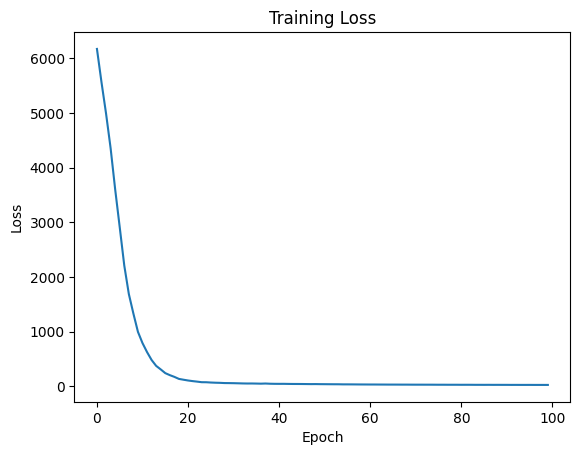

Model saved to models/gcrn_gcn_simulated_dom1.pth
Average Time per Epoch: 3.23s
Average CPU Usage: 78.20%
Average Memory Usage: 11.60%

Sum Time per Epoch: 322.76s
Sum CPU Usage: 78.20%
Sum Memory Usage: 11.60%


In [26]:
# Initialize model
input_dim = 35  
feature_dim = 16
latent_dim = 46
num_rec_layers = 2

model_simulated_dom1 = GCRN_gcn(input_dim, feature_dim, latent_dim, num_rec_layers)
print(model_simulated_dom1)
print(f"Total number of trainable parameters: {model_simulated_dom1.count_parameters()}\n")

# Train model 
train_model(model_simulated_dom1, x_train_domain_1, adj_train_domain_1, num_epochs=100, lr=0.0001, save_path="models/gcrn_gcn_simulated_dom1.pth")

GCRN_gcn(
  (encoder): GCNEncoder(
    (conv1): GCN (16 -> 32)
    (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): GCN (32 -> 46)
    (bn2): BatchNorm1d(46, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (fc_mu): Linear(in_features=46, out_features=46, bias=True)
    (fc_logvar): Linear(in_features=46, out_features=46, bias=True)
  )
  (gru): GRU(46, 46, num_layers=2)
  (decoder): GCNDecoder(
    (fc): Linear(in_features=46, out_features=1610, bias=True)
    (bn0): BatchNorm1d(46, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv1): GCN (46 -> 92)
    (bn1): BatchNorm1d(92, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): GCN (92 -> 70)
    (bn2): BatchNorm1d(70, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): GCN (70 -> 35)
    (bn3): BatchNorm1d(35, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)
Total number o

Epoch 1/100: 100%|██████████| 80/80 [00:01<00:00, 43.54it/s]


Epoch 1, Loss: 6150.559909057617
Time: 1.84s, CPU: 67.70%, Memory: 11.60%



Epoch 2/100: 100%|██████████| 80/80 [00:02<00:00, 35.47it/s]


Epoch 2, Loss: 5559.821859741211
Time: 2.26s, CPU: 79.00%, Memory: 11.60%



Epoch 3/100: 100%|██████████| 80/80 [00:01<00:00, 41.87it/s]


Epoch 3, Loss: 4995.3084915161135
Time: 1.91s, CPU: 76.40%, Memory: 11.70%



Epoch 4/100: 100%|██████████| 80/80 [00:01<00:00, 40.13it/s]


Epoch 4, Loss: 4327.436138916016
Time: 2.00s, CPU: 77.50%, Memory: 11.70%



Epoch 5/100: 100%|██████████| 80/80 [00:12<00:00,  6.24it/s]


Epoch 5, Loss: 3740.9689544677735
Time: 12.82s, CPU: 87.50%, Memory: 11.70%



Epoch 6/100: 100%|██████████| 80/80 [00:02<00:00, 39.88it/s]


Epoch 6, Loss: 3046.7010543823244
Time: 2.01s, CPU: 77.90%, Memory: 11.60%



Epoch 7/100: 100%|██████████| 80/80 [00:01<00:00, 44.38it/s]


Epoch 7, Loss: 2370.205297088623
Time: 1.83s, CPU: 76.00%, Memory: 11.60%



Epoch 8/100: 100%|██████████| 80/80 [00:02<00:00, 37.51it/s]


Epoch 8, Loss: 1879.3231704711914
Time: 2.14s, CPU: 79.80%, Memory: 11.60%



Epoch 9/100: 100%|██████████| 80/80 [00:02<00:00, 38.31it/s]


Epoch 9, Loss: 1374.4012233734131
Time: 2.09s, CPU: 76.90%, Memory: 11.70%



Epoch 10/100: 100%|██████████| 80/80 [00:12<00:00,  6.33it/s]


Epoch 10, Loss: 1041.8757865905761
Time: 12.64s, CPU: 87.80%, Memory: 11.60%



Epoch 11/100: 100%|██████████| 80/80 [00:02<00:00, 35.14it/s]


Epoch 11, Loss: 806.2452377319336
Time: 2.30s, CPU: 79.20%, Memory: 11.60%



Epoch 12/100: 100%|██████████| 80/80 [00:01<00:00, 40.07it/s]


Epoch 12, Loss: 631.5248607635498
Time: 2.00s, CPU: 77.50%, Memory: 11.70%



Epoch 13/100: 100%|██████████| 80/80 [00:02<00:00, 37.25it/s]


Epoch 13, Loss: 489.91569967269896
Time: 2.15s, CPU: 78.40%, Memory: 11.60%



Epoch 14/100: 100%|██████████| 80/80 [00:02<00:00, 38.70it/s]


Epoch 14, Loss: 384.86503505706787
Time: 2.07s, CPU: 77.50%, Memory: 11.60%



Epoch 15/100: 100%|██████████| 80/80 [00:06<00:00, 11.43it/s]


Epoch 15, Loss: 313.57491331100465
Time: 7.00s, CPU: 85.30%, Memory: 11.60%



Epoch 16/100: 100%|██████████| 80/80 [00:08<00:00,  9.12it/s]


Epoch 16, Loss: 251.68683729171752
Time: 8.77s, CPU: 87.20%, Memory: 11.60%



Epoch 17/100: 100%|██████████| 80/80 [00:04<00:00, 16.87it/s]


Epoch 17, Loss: 205.19593367576599
Time: 4.74s, CPU: 84.70%, Memory: 11.70%



Epoch 18/100: 100%|██████████| 80/80 [00:06<00:00, 12.46it/s]


Epoch 18, Loss: 171.94311757087706
Time: 6.43s, CPU: 85.50%, Memory: 11.60%



Epoch 19/100: 100%|██████████| 80/80 [00:12<00:00,  6.27it/s]


Epoch 19, Loss: 142.6717921257019
Time: 12.76s, CPU: 88.30%, Memory: 11.70%



Epoch 20/100: 100%|██████████| 80/80 [00:09<00:00,  8.42it/s]


Epoch 20, Loss: 124.24481544494628
Time: 9.51s, CPU: 87.20%, Memory: 11.60%



Epoch 21/100: 100%|██████████| 80/80 [00:02<00:00, 32.95it/s]


Epoch 21, Loss: 108.86102747917175
Time: 2.43s, CPU: 79.50%, Memory: 11.60%



Epoch 22/100: 100%|██████████| 80/80 [00:04<00:00, 18.52it/s]


Epoch 22, Loss: 93.67732157707215
Time: 4.32s, CPU: 84.50%, Memory: 11.60%



Epoch 23/100: 100%|██████████| 80/80 [00:03<00:00, 22.93it/s]


Epoch 23, Loss: 86.8124531030655
Time: 3.49s, CPU: 82.50%, Memory: 11.60%



Epoch 24/100: 100%|██████████| 80/80 [00:02<00:00, 33.85it/s]


Epoch 24, Loss: 77.7498929977417
Time: 2.37s, CPU: 78.90%, Memory: 11.70%



Epoch 25/100: 100%|██████████| 80/80 [00:02<00:00, 38.40it/s]


Epoch 25, Loss: 74.10534658432007
Time: 2.09s, CPU: 77.70%, Memory: 11.60%



Epoch 26/100: 100%|██████████| 80/80 [00:02<00:00, 35.83it/s]


Epoch 26, Loss: 69.45048084259034
Time: 2.24s, CPU: 79.30%, Memory: 11.70%



Epoch 27/100: 100%|██████████| 80/80 [00:02<00:00, 33.86it/s]


Epoch 27, Loss: 63.53761239051819
Time: 2.37s, CPU: 77.60%, Memory: 11.70%



Epoch 28/100: 100%|██████████| 80/80 [00:05<00:00, 13.78it/s]


Epoch 28, Loss: 62.034969091415405
Time: 5.81s, CPU: 86.10%, Memory: 11.60%



Epoch 29/100: 100%|██████████| 80/80 [00:03<00:00, 25.28it/s]


Epoch 29, Loss: 58.65474550724029
Time: 3.17s, CPU: 80.60%, Memory: 11.60%



Epoch 30/100: 100%|██████████| 80/80 [00:02<00:00, 34.59it/s]


Epoch 30, Loss: 55.99482822418213
Time: 2.32s, CPU: 77.90%, Memory: 11.60%



Epoch 31/100: 100%|██████████| 80/80 [00:03<00:00, 24.04it/s]


Epoch 31, Loss: 53.927778005599976
Time: 3.33s, CPU: 80.20%, Memory: 11.60%



Epoch 32/100: 100%|██████████| 80/80 [00:02<00:00, 39.29it/s]


Epoch 32, Loss: 51.78820517063141
Time: 2.04s, CPU: 77.40%, Memory: 11.60%



Epoch 33/100: 100%|██████████| 80/80 [00:02<00:00, 29.20it/s]


Epoch 33, Loss: 51.40625028610229
Time: 2.74s, CPU: 79.70%, Memory: 11.70%



Epoch 34/100: 100%|██████████| 80/80 [00:02<00:00, 33.85it/s]


Epoch 34, Loss: 50.11953649520874
Time: 2.37s, CPU: 78.60%, Memory: 11.60%



Epoch 35/100: 100%|██████████| 80/80 [00:02<00:00, 34.92it/s]


Epoch 35, Loss: 49.19326965808868
Time: 2.29s, CPU: 77.50%, Memory: 11.60%



Epoch 36/100: 100%|██████████| 80/80 [00:02<00:00, 33.33it/s]


Epoch 36, Loss: 46.74225885868073
Time: 2.40s, CPU: 78.90%, Memory: 11.70%



Epoch 37/100: 100%|██████████| 80/80 [00:01<00:00, 41.13it/s]


Epoch 37, Loss: 45.36988878250122
Time: 1.95s, CPU: 79.10%, Memory: 11.60%



Epoch 38/100: 100%|██████████| 80/80 [00:02<00:00, 27.80it/s]


Epoch 38, Loss: 46.5695387840271
Time: 2.88s, CPU: 79.90%, Memory: 11.60%



Epoch 39/100: 100%|██████████| 80/80 [00:02<00:00, 38.33it/s]


Epoch 39, Loss: 44.06136901378632
Time: 2.09s, CPU: 77.00%, Memory: 11.70%



Epoch 40/100: 100%|██████████| 80/80 [00:02<00:00, 29.64it/s]


Epoch 40, Loss: 42.59772312641144
Time: 2.70s, CPU: 79.80%, Memory: 11.60%



Epoch 41/100: 100%|██████████| 80/80 [00:23<00:00,  3.42it/s]


Epoch 41, Loss: 43.41946394443512
Time: 23.41s, CPU: 88.80%, Memory: 11.60%



Epoch 42/100: 100%|██████████| 80/80 [00:02<00:00, 33.18it/s]


Epoch 42, Loss: 41.409446597099304
Time: 2.41s, CPU: 78.60%, Memory: 11.60%



Epoch 43/100: 100%|██████████| 80/80 [00:14<00:00,  5.55it/s]


Epoch 43, Loss: 41.784525465965274
Time: 14.43s, CPU: 88.40%, Memory: 11.60%



Epoch 44/100: 100%|██████████| 80/80 [00:02<00:00, 33.00it/s]


Epoch 44, Loss: 41.870814895629884
Time: 2.43s, CPU: 80.20%, Memory: 11.60%



Epoch 45/100: 100%|██████████| 80/80 [00:05<00:00, 14.34it/s]


Epoch 45, Loss: 40.65613627433777
Time: 5.58s, CPU: 85.30%, Memory: 11.70%



Epoch 46/100: 100%|██████████| 80/80 [00:02<00:00, 27.97it/s]


Epoch 46, Loss: 40.317950224876405
Time: 2.86s, CPU: 78.20%, Memory: 11.70%



Epoch 47/100: 100%|██████████| 80/80 [00:02<00:00, 35.25it/s]


Epoch 47, Loss: 39.0657383441925
Time: 2.27s, CPU: 78.90%, Memory: 11.70%



Epoch 48/100: 100%|██████████| 80/80 [00:02<00:00, 32.63it/s]


Epoch 48, Loss: 39.570833921432495
Time: 2.45s, CPU: 78.50%, Memory: 11.60%



Epoch 49/100: 100%|██████████| 80/80 [00:02<00:00, 33.17it/s]


Epoch 49, Loss: 38.45104637145996
Time: 2.42s, CPU: 79.10%, Memory: 11.60%



Epoch 50/100: 100%|██████████| 80/80 [00:02<00:00, 31.53it/s]


Epoch 50, Loss: 37.27693808078766
Time: 2.54s, CPU: 79.00%, Memory: 11.70%



Epoch 51/100: 100%|██████████| 80/80 [00:02<00:00, 27.98it/s]


Epoch 51, Loss: 37.26274271011353
Time: 2.86s, CPU: 79.90%, Memory: 11.60%



Epoch 52/100: 100%|██████████| 80/80 [00:02<00:00, 36.32it/s]


Epoch 52, Loss: 36.44800757169723
Time: 2.21s, CPU: 77.30%, Memory: 11.70%



Epoch 53/100: 100%|██████████| 80/80 [00:02<00:00, 29.32it/s]


Epoch 53, Loss: 35.86231368780136
Time: 2.73s, CPU: 80.50%, Memory: 11.60%



Epoch 54/100: 100%|██████████| 80/80 [00:01<00:00, 42.42it/s]


Epoch 54, Loss: 35.73744951486587
Time: 1.89s, CPU: 77.10%, Memory: 11.70%



Epoch 55/100: 100%|██████████| 80/80 [00:02<00:00, 38.42it/s]


Epoch 55, Loss: 34.6352263212204
Time: 2.09s, CPU: 76.70%, Memory: 11.70%



Epoch 56/100: 100%|██████████| 80/80 [00:06<00:00, 12.35it/s]


Epoch 56, Loss: 33.85086961984634
Time: 6.48s, CPU: 85.30%, Memory: 11.60%



Epoch 57/100: 100%|██████████| 80/80 [00:01<00:00, 40.10it/s]


Epoch 57, Loss: 33.31858402490616
Time: 2.00s, CPU: 76.70%, Memory: 11.60%



Epoch 58/100: 100%|██████████| 80/80 [00:19<00:00,  4.02it/s]


Epoch 58, Loss: 32.896998131275176
Time: 19.90s, CPU: 88.40%, Memory: 11.70%



Epoch 59/100: 100%|██████████| 80/80 [00:12<00:00,  6.52it/s]


Epoch 59, Loss: 32.494384825229645
Time: 12.28s, CPU: 87.60%, Memory: 11.60%



Epoch 60/100: 100%|██████████| 80/80 [00:02<00:00, 34.53it/s]


Epoch 60, Loss: 31.562350511550903
Time: 2.32s, CPU: 78.60%, Memory: 11.70%



Epoch 61/100: 100%|██████████| 80/80 [00:01<00:00, 42.79it/s]


Epoch 61, Loss: 30.716129636764528
Time: 1.87s, CPU: 77.00%, Memory: 11.70%



Epoch 62/100: 100%|██████████| 80/80 [00:02<00:00, 27.12it/s]


Epoch 62, Loss: 30.68756228685379
Time: 2.96s, CPU: 80.60%, Memory: 11.60%



Epoch 63/100: 100%|██████████| 80/80 [00:02<00:00, 36.40it/s]


Epoch 63, Loss: 29.836094522476195
Time: 2.20s, CPU: 77.70%, Memory: 11.60%



Epoch 64/100: 100%|██████████| 80/80 [00:09<00:00,  8.86it/s]


Epoch 64, Loss: 29.614612698554993
Time: 9.03s, CPU: 86.50%, Memory: 11.60%



Epoch 65/100: 100%|██████████| 80/80 [00:05<00:00, 14.25it/s]


Epoch 65, Loss: 29.351939022541046
Time: 5.62s, CPU: 84.40%, Memory: 11.60%



Epoch 66/100: 100%|██████████| 80/80 [00:02<00:00, 39.54it/s]


Epoch 66, Loss: 28.793212389945985
Time: 2.03s, CPU: 76.50%, Memory: 11.60%



Epoch 67/100: 100%|██████████| 80/80 [00:02<00:00, 33.38it/s]


Epoch 67, Loss: 28.488579595088957
Time: 2.40s, CPU: 78.50%, Memory: 11.70%



Epoch 68/100: 100%|██████████| 80/80 [00:14<00:00,  5.34it/s]


Epoch 68, Loss: 28.121959221363067
Time: 14.99s, CPU: 88.00%, Memory: 11.70%



Epoch 69/100: 100%|██████████| 80/80 [00:10<00:00,  7.65it/s]


Epoch 69, Loss: 27.676270389556883
Time: 10.46s, CPU: 87.40%, Memory: 11.70%



Epoch 70/100: 100%|██████████| 80/80 [00:02<00:00, 34.78it/s]


Epoch 70, Loss: 27.462378692626952
Time: 2.30s, CPU: 79.10%, Memory: 11.70%



Epoch 71/100: 100%|██████████| 80/80 [00:09<00:00,  8.48it/s]


Epoch 71, Loss: 27.559749519824983
Time: 9.43s, CPU: 87.10%, Memory: 11.60%



Epoch 72/100: 100%|██████████| 80/80 [00:03<00:00, 25.63it/s]


Epoch 72, Loss: 27.065248095989226
Time: 3.13s, CPU: 81.90%, Memory: 11.60%



Epoch 73/100: 100%|██████████| 80/80 [00:09<00:00,  8.01it/s]


Epoch 73, Loss: 26.94437630176544
Time: 10.00s, CPU: 87.50%, Memory: 11.60%



Epoch 74/100: 100%|██████████| 80/80 [00:07<00:00, 10.61it/s]


Epoch 74, Loss: 26.85604647397995
Time: 7.55s, CPU: 86.40%, Memory: 11.60%



Epoch 75/100: 100%|██████████| 80/80 [00:02<00:00, 35.63it/s]


Epoch 75, Loss: 26.617711329460143
Time: 2.25s, CPU: 77.50%, Memory: 11.60%



Epoch 76/100: 100%|██████████| 80/80 [00:02<00:00, 31.87it/s]


Epoch 76, Loss: 26.28729374408722
Time: 2.53s, CPU: 78.50%, Memory: 11.70%



Epoch 77/100: 100%|██████████| 80/80 [00:02<00:00, 36.06it/s]


Epoch 77, Loss: 26.125955986976624
Time: 2.22s, CPU: 77.10%, Memory: 11.60%



Epoch 78/100: 100%|██████████| 80/80 [00:02<00:00, 30.54it/s]


Epoch 78, Loss: 25.694048607349394
Time: 2.62s, CPU: 80.40%, Memory: 11.70%



Epoch 79/100: 100%|██████████| 80/80 [00:02<00:00, 34.98it/s]


Epoch 79, Loss: 25.488594782352447
Time: 2.29s, CPU: 77.40%, Memory: 11.70%



Epoch 80/100: 100%|██████████| 80/80 [00:02<00:00, 26.83it/s]


Epoch 80, Loss: 25.47861909866333
Time: 2.98s, CPU: 81.60%, Memory: 11.70%



Epoch 81/100: 100%|██████████| 80/80 [00:02<00:00, 35.61it/s]


Epoch 81, Loss: 25.270685040950774
Time: 2.25s, CPU: 78.00%, Memory: 11.70%



Epoch 82/100: 100%|██████████| 80/80 [00:02<00:00, 30.28it/s]


Epoch 82, Loss: 25.20665910243988
Time: 2.64s, CPU: 79.10%, Memory: 11.70%



Epoch 83/100: 100%|██████████| 80/80 [00:02<00:00, 36.22it/s]


Epoch 83, Loss: 25.071929371356966
Time: 2.21s, CPU: 78.30%, Memory: 11.70%



Epoch 84/100: 100%|██████████| 80/80 [00:09<00:00,  8.31it/s]


Epoch 84, Loss: 24.99562120437622
Time: 9.64s, CPU: 86.60%, Memory: 11.60%



Epoch 85/100: 100%|██████████| 80/80 [00:02<00:00, 36.67it/s]


Epoch 85, Loss: 25.095078885555267
Time: 2.18s, CPU: 77.40%, Memory: 11.70%



Epoch 86/100: 100%|██████████| 80/80 [00:02<00:00, 29.09it/s]


Epoch 86, Loss: 24.401855766773224
Time: 2.75s, CPU: 79.70%, Memory: 11.70%



Epoch 87/100: 100%|██████████| 80/80 [00:02<00:00, 31.92it/s]


Epoch 87, Loss: 24.53371126651764
Time: 2.51s, CPU: 78.50%, Memory: 11.60%



Epoch 88/100: 100%|██████████| 80/80 [00:03<00:00, 26.28it/s]


Epoch 88, Loss: 24.57441964149475
Time: 3.05s, CPU: 81.40%, Memory: 11.60%



Epoch 89/100: 100%|██████████| 80/80 [00:02<00:00, 31.29it/s]


Epoch 89, Loss: 24.55378201007843
Time: 2.56s, CPU: 77.60%, Memory: 11.70%



Epoch 90/100: 100%|██████████| 80/80 [00:02<00:00, 37.80it/s]


Epoch 90, Loss: 24.12130695581436
Time: 2.12s, CPU: 77.30%, Memory: 11.70%



Epoch 91/100: 100%|██████████| 80/80 [00:13<00:00,  6.12it/s]


Epoch 91, Loss: 24.188244533538818
Time: 13.08s, CPU: 87.90%, Memory: 11.60%



Epoch 92/100: 100%|██████████| 80/80 [00:02<00:00, 39.49it/s]


Epoch 92, Loss: 23.90738718509674
Time: 2.03s, CPU: 77.80%, Memory: 11.60%



Epoch 93/100: 100%|██████████| 80/80 [00:02<00:00, 27.87it/s]


Epoch 93, Loss: 23.94914299249649
Time: 2.88s, CPU: 79.40%, Memory: 11.60%



Epoch 94/100: 100%|██████████| 80/80 [00:02<00:00, 38.69it/s]


Epoch 94, Loss: 23.963472294807435
Time: 2.07s, CPU: 78.00%, Memory: 11.60%



Epoch 95/100: 100%|██████████| 80/80 [00:02<00:00, 37.55it/s]


Epoch 95, Loss: 23.819319188594818
Time: 2.13s, CPU: 77.50%, Memory: 11.60%



Epoch 96/100: 100%|██████████| 80/80 [00:02<00:00, 32.30it/s]


Epoch 96, Loss: 23.641106927394866
Time: 2.48s, CPU: 79.00%, Memory: 11.60%



Epoch 97/100: 100%|██████████| 80/80 [00:02<00:00, 38.03it/s]


Epoch 97, Loss: 23.717845010757447
Time: 2.11s, CPU: 77.80%, Memory: 11.60%



Epoch 98/100: 100%|██████████| 80/80 [00:05<00:00, 13.39it/s]


Epoch 98, Loss: 23.471435809135436
Time: 5.98s, CPU: 83.50%, Memory: 11.60%



Epoch 99/100: 100%|██████████| 80/80 [00:16<00:00,  4.92it/s]


Epoch 99, Loss: 23.51432955265045
Time: 16.25s, CPU: 88.50%, Memory: 11.70%



Epoch 100/100: 100%|██████████| 80/80 [00:02<00:00, 28.07it/s]

Epoch 100, Loss: 23.691587471961974
Time: 2.85s, CPU: 81.10%, Memory: 11.70%



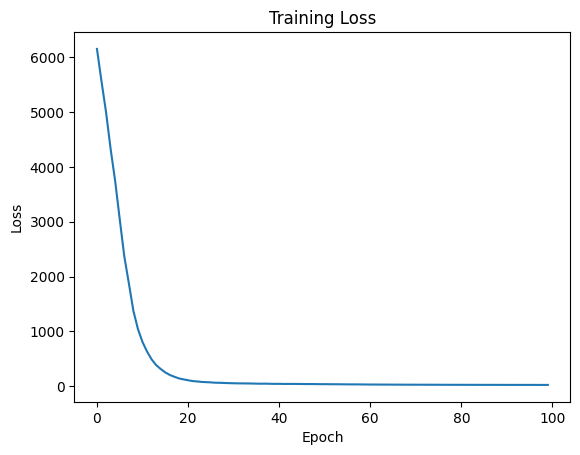

Model saved to models/gcrn_gcn_simulated_dom2.pth
Average Time per Epoch: 4.53s
Average CPU Usage: 81.10%
Average Memory Usage: 11.70%

Sum Time per Epoch: 452.89s
Sum CPU Usage: 81.10%
Sum Memory Usage: 11.70%


In [27]:
# Initialize model
input_dim = 35  
feature_dim = 16
latent_dim = 46
num_rec_layers = 2

model_simulated_dom2 = GCRN_gcn(input_dim, feature_dim, latent_dim, num_rec_layers)
print(model_simulated_dom2)
print(f"Total number of trainable parameters: {model_simulated_dom2.count_parameters()}\n")

# Train model 
train_model(model_simulated_dom2, x_train_domain_2, adj_train_domain_2, num_epochs=100, lr=0.0001, save_path="models/gcrn_gcn_simulated_dom2.pth")

GCRN_gcn(
  (encoder): GCNEncoder(
    (conv1): GCN (16 -> 32)
    (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): GCN (32 -> 46)
    (bn2): BatchNorm1d(46, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (fc_mu): Linear(in_features=46, out_features=46, bias=True)
    (fc_logvar): Linear(in_features=46, out_features=46, bias=True)
  )
  (gru): GRU(46, 46, num_layers=2)
  (decoder): GCNDecoder(
    (fc): Linear(in_features=46, out_features=1610, bias=True)
    (bn0): BatchNorm1d(46, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv1): GCN (46 -> 92)
    (bn1): BatchNorm1d(92, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): GCN (92 -> 70)
    (bn2): BatchNorm1d(70, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): GCN (70 -> 35)
    (bn3): BatchNorm1d(35, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)
Total number o

Epoch 1/100: 100%|██████████| 80/80 [00:07<00:00, 10.18it/s]


Epoch 1, Loss: 6010.626554870605
Time: 7.86s, CPU: 85.00%, Memory: 11.60%



Epoch 2/100: 100%|██████████| 80/80 [00:02<00:00, 39.76it/s]


Epoch 2, Loss: 5432.260475158691
Time: 2.01s, CPU: 77.50%, Memory: 11.60%



Epoch 3/100: 100%|██████████| 80/80 [00:02<00:00, 32.42it/s]


Epoch 3, Loss: 4750.345664978027
Time: 2.47s, CPU: 79.90%, Memory: 11.60%



Epoch 4/100: 100%|██████████| 80/80 [00:01<00:00, 41.97it/s]


Epoch 4, Loss: 4062.914410400391
Time: 1.91s, CPU: 77.30%, Memory: 11.70%



Epoch 5/100: 100%|██████████| 80/80 [00:02<00:00, 33.98it/s]


Epoch 5, Loss: 3253.894900512695
Time: 2.36s, CPU: 79.50%, Memory: 11.70%



Epoch 6/100: 100%|██████████| 80/80 [00:08<00:00,  9.17it/s]


Epoch 6, Loss: 2569.872278594971
Time: 8.73s, CPU: 87.90%, Memory: 11.60%



Epoch 7/100: 100%|██████████| 80/80 [00:05<00:00, 14.28it/s]


Epoch 7, Loss: 1916.880458831787
Time: 5.60s, CPU: 85.30%, Memory: 11.60%



Epoch 8/100: 100%|██████████| 80/80 [00:02<00:00, 31.72it/s]


Epoch 8, Loss: 1442.2941410064698
Time: 2.53s, CPU: 80.60%, Memory: 11.60%



Epoch 9/100: 100%|██████████| 80/80 [00:01<00:00, 40.13it/s]


Epoch 9, Loss: 1074.989821624756
Time: 2.00s, CPU: 77.20%, Memory: 11.70%



Epoch 10/100: 100%|██████████| 80/80 [00:02<00:00, 34.85it/s]


Epoch 10, Loss: 836.1151344299317
Time: 2.30s, CPU: 77.70%, Memory: 11.70%



Epoch 11/100: 100%|██████████| 80/80 [00:02<00:00, 31.39it/s]


Epoch 11, Loss: 631.5605388641358
Time: 2.55s, CPU: 79.10%, Memory: 11.70%



Epoch 12/100: 100%|██████████| 80/80 [00:04<00:00, 18.00it/s]


Epoch 12, Loss: 478.92929859161376
Time: 4.45s, CPU: 86.10%, Memory: 11.60%



Epoch 13/100: 100%|██████████| 80/80 [00:02<00:00, 28.89it/s]


Epoch 13, Loss: 361.0702648162842
Time: 2.77s, CPU: 79.40%, Memory: 11.70%



Epoch 14/100: 100%|██████████| 80/80 [00:02<00:00, 30.62it/s]


Epoch 14, Loss: 282.74961318969724
Time: 2.62s, CPU: 80.30%, Memory: 11.70%



Epoch 15/100: 100%|██████████| 80/80 [00:02<00:00, 32.73it/s]


Epoch 15, Loss: 224.9415554046631
Time: 2.45s, CPU: 78.20%, Memory: 11.70%



Epoch 16/100: 100%|██████████| 80/80 [00:02<00:00, 28.08it/s]


Epoch 16, Loss: 178.57430419921874
Time: 2.85s, CPU: 79.00%, Memory: 11.60%



Epoch 17/100: 100%|██████████| 80/80 [00:02<00:00, 36.24it/s]


Epoch 17, Loss: 153.3078758239746
Time: 2.21s, CPU: 79.00%, Memory: 11.70%



Epoch 18/100: 100%|██████████| 80/80 [00:02<00:00, 27.29it/s]


Epoch 18, Loss: 125.35517065525055
Time: 2.94s, CPU: 80.00%, Memory: 11.60%



Epoch 19/100: 100%|██████████| 80/80 [00:05<00:00, 14.44it/s]


Epoch 19, Loss: 107.16465280055999
Time: 5.54s, CPU: 86.50%, Memory: 11.60%



Epoch 20/100: 100%|██████████| 80/80 [00:02<00:00, 32.39it/s]


Epoch 20, Loss: 98.83680815696717
Time: 2.47s, CPU: 77.50%, Memory: 11.70%



Epoch 21/100: 100%|██████████| 80/80 [00:08<00:00,  9.09it/s]


Epoch 21, Loss: 82.88298931121827
Time: 8.80s, CPU: 87.00%, Memory: 11.80%



Epoch 22/100: 100%|██████████| 80/80 [00:09<00:00,  8.57it/s]


Epoch 22, Loss: 76.86379477977752
Time: 9.34s, CPU: 87.10%, Memory: 11.70%



Epoch 23/100: 100%|██████████| 80/80 [00:02<00:00, 29.10it/s]


Epoch 23, Loss: 70.26567533016205
Time: 2.75s, CPU: 79.20%, Memory: 11.70%



Epoch 24/100: 100%|██████████| 80/80 [00:01<00:00, 41.78it/s]


Epoch 24, Loss: 65.41822254657745
Time: 1.92s, CPU: 77.20%, Memory: 11.70%



Epoch 25/100: 100%|██████████| 80/80 [00:03<00:00, 20.11it/s]


Epoch 25, Loss: 62.9177401304245
Time: 3.98s, CPU: 84.20%, Memory: 11.80%



Epoch 26/100: 100%|██████████| 80/80 [00:07<00:00, 11.22it/s]


Epoch 26, Loss: 58.18225202560425
Time: 7.13s, CPU: 86.30%, Memory: 11.70%



Epoch 27/100: 100%|██████████| 80/80 [00:09<00:00,  8.26it/s]


Epoch 27, Loss: 56.16580650806427
Time: 9.69s, CPU: 86.70%, Memory: 11.60%



Epoch 28/100: 100%|██████████| 80/80 [00:02<00:00, 37.67it/s]


Epoch 28, Loss: 54.04750862121582
Time: 2.13s, CPU: 77.90%, Memory: 11.60%



Epoch 29/100: 100%|██████████| 80/80 [00:02<00:00, 35.64it/s]


Epoch 29, Loss: 51.5284068107605
Time: 2.25s, CPU: 76.80%, Memory: 11.70%



Epoch 30/100: 100%|██████████| 80/80 [00:07<00:00, 10.63it/s]


Epoch 30, Loss: 50.478861570358276
Time: 7.53s, CPU: 86.30%, Memory: 11.60%



Epoch 31/100: 100%|██████████| 80/80 [00:08<00:00,  9.78it/s]


Epoch 31, Loss: 48.835767126083375
Time: 8.18s, CPU: 86.30%, Memory: 11.70%



Epoch 32/100: 100%|██████████| 80/80 [00:02<00:00, 35.33it/s]


Epoch 32, Loss: 47.520534086227414
Time: 2.27s, CPU: 78.10%, Memory: 11.70%



Epoch 33/100: 100%|██████████| 80/80 [00:02<00:00, 39.09it/s]


Epoch 33, Loss: 45.17860698699951
Time: 2.05s, CPU: 77.90%, Memory: 11.70%



Epoch 34/100: 100%|██████████| 80/80 [00:01<00:00, 44.40it/s]


Epoch 34, Loss: 44.29825916290283
Time: 1.81s, CPU: 76.50%, Memory: 11.80%



Epoch 35/100: 100%|██████████| 80/80 [00:02<00:00, 30.34it/s]


Epoch 35, Loss: 43.29043426513672
Time: 2.64s, CPU: 78.50%, Memory: 11.60%



Epoch 36/100: 100%|██████████| 80/80 [00:01<00:00, 44.50it/s]


Epoch 36, Loss: 43.44978494644165
Time: 1.80s, CPU: 76.70%, Memory: 11.70%



Epoch 37/100: 100%|██████████| 80/80 [00:02<00:00, 32.42it/s]


Epoch 37, Loss: 41.21199643611908
Time: 2.47s, CPU: 78.60%, Memory: 11.70%



Epoch 38/100: 100%|██████████| 80/80 [00:02<00:00, 38.19it/s]


Epoch 38, Loss: 40.84698338508606
Time: 2.12s, CPU: 76.50%, Memory: 11.70%



Epoch 39/100: 100%|██████████| 80/80 [00:02<00:00, 38.84it/s]


Epoch 39, Loss: 39.2288813829422
Time: 2.06s, CPU: 76.50%, Memory: 11.70%



Epoch 40/100: 100%|██████████| 80/80 [00:02<00:00, 34.09it/s]


Epoch 40, Loss: 39.25744730234146
Time: 2.35s, CPU: 77.90%, Memory: 11.70%



Epoch 41/100: 100%|██████████| 80/80 [00:16<00:00,  4.97it/s]


Epoch 41, Loss: 38.29843773841858
Time: 16.10s, CPU: 86.50%, Memory: 11.60%



Epoch 42/100: 100%|██████████| 80/80 [00:02<00:00, 34.00it/s]


Epoch 42, Loss: 39.16881101131439
Time: 2.36s, CPU: 78.00%, Memory: 11.60%



Epoch 43/100: 100%|██████████| 80/80 [00:02<00:00, 31.13it/s]


Epoch 43, Loss: 37.36303707361221
Time: 2.57s, CPU: 78.70%, Memory: 11.60%



Epoch 44/100: 100%|██████████| 80/80 [00:09<00:00,  8.77it/s]


Epoch 44, Loss: 36.79075077772141
Time: 9.12s, CPU: 87.40%, Memory: 11.60%



Epoch 45/100: 100%|██████████| 80/80 [00:02<00:00, 29.88it/s]


Epoch 45, Loss: 36.20364646911621
Time: 2.68s, CPU: 80.70%, Memory: 11.70%



Epoch 46/100: 100%|██████████| 80/80 [00:02<00:00, 39.93it/s]


Epoch 46, Loss: 35.673478269577025
Time: 2.01s, CPU: 77.50%, Memory: 11.70%



Epoch 47/100: 100%|██████████| 80/80 [00:01<00:00, 44.15it/s]


Epoch 47, Loss: 39.2062390089035
Time: 1.82s, CPU: 76.00%, Memory: 11.70%



Epoch 48/100: 100%|██████████| 80/80 [00:09<00:00,  8.43it/s]


Epoch 48, Loss: 34.62510161399841
Time: 9.49s, CPU: 87.90%, Memory: 11.60%



Epoch 49/100: 100%|██████████| 80/80 [00:05<00:00, 14.19it/s]


Epoch 49, Loss: 33.82028604745865
Time: 5.64s, CPU: 84.90%, Memory: 11.60%



Epoch 50/100: 100%|██████████| 80/80 [00:02<00:00, 37.09it/s]


Epoch 50, Loss: 33.432864940166475
Time: 2.16s, CPU: 78.40%, Memory: 11.60%



Epoch 51/100: 100%|██████████| 80/80 [00:12<00:00,  6.35it/s]


Epoch 51, Loss: 33.21709142923355
Time: 12.61s, CPU: 87.70%, Memory: 11.70%



Epoch 52/100: 100%|██████████| 80/80 [00:02<00:00, 33.20it/s]


Epoch 52, Loss: 32.7000697851181
Time: 2.42s, CPU: 78.60%, Memory: 11.60%



Epoch 53/100: 100%|██████████| 80/80 [00:02<00:00, 37.42it/s]


Epoch 53, Loss: 32.093271827697755
Time: 2.14s, CPU: 77.20%, Memory: 11.70%



Epoch 54/100: 100%|██████████| 80/80 [00:02<00:00, 28.79it/s]


Epoch 54, Loss: 31.9566229224205
Time: 2.78s, CPU: 81.20%, Memory: 11.70%



Epoch 55/100: 100%|██████████| 80/80 [00:02<00:00, 37.85it/s]


Epoch 55, Loss: 31.144560146331788
Time: 2.12s, CPU: 77.10%, Memory: 11.70%



Epoch 56/100: 100%|██████████| 80/80 [00:02<00:00, 33.06it/s]


Epoch 56, Loss: 31.372775161266325
Time: 2.42s, CPU: 79.60%, Memory: 11.70%



Epoch 57/100: 100%|██████████| 80/80 [00:02<00:00, 34.43it/s]


Epoch 57, Loss: 30.813021087646483
Time: 2.33s, CPU: 77.70%, Memory: 11.70%



Epoch 58/100: 100%|██████████| 80/80 [00:02<00:00, 34.08it/s]


Epoch 58, Loss: 30.557154190540313
Time: 2.35s, CPU: 78.40%, Memory: 11.70%



Epoch 59/100: 100%|██████████| 80/80 [00:09<00:00,  8.07it/s]


Epoch 59, Loss: 30.058684146404268
Time: 9.91s, CPU: 87.40%, Memory: 11.70%



Epoch 60/100: 100%|██████████| 80/80 [00:15<00:00,  5.09it/s]


Epoch 60, Loss: 30.34650424718857
Time: 15.73s, CPU: 87.50%, Memory: 11.70%



Epoch 61/100: 100%|██████████| 80/80 [00:09<00:00,  8.54it/s]


Epoch 61, Loss: 29.997300386428833
Time: 9.37s, CPU: 87.70%, Memory: 11.70%



Epoch 62/100: 100%|██████████| 80/80 [00:02<00:00, 37.20it/s]


Epoch 62, Loss: 29.422308671474457
Time: 2.15s, CPU: 77.10%, Memory: 11.70%



Epoch 63/100: 100%|██████████| 80/80 [00:05<00:00, 13.80it/s]


Epoch 63, Loss: 29.82402319908142
Time: 5.80s, CPU: 85.30%, Memory: 11.70%



Epoch 64/100: 100%|██████████| 80/80 [00:02<00:00, 32.24it/s]


Epoch 64, Loss: 29.18523030281067
Time: 2.48s, CPU: 78.50%, Memory: 11.60%



Epoch 65/100: 100%|██████████| 80/80 [00:02<00:00, 37.98it/s]


Epoch 65, Loss: 28.760985803604125
Time: 2.11s, CPU: 77.50%, Memory: 11.70%



Epoch 66/100: 100%|██████████| 80/80 [00:02<00:00, 29.26it/s]


Epoch 66, Loss: 28.47298550605774
Time: 2.74s, CPU: 81.30%, Memory: 11.70%



Epoch 67/100: 100%|██████████| 80/80 [00:02<00:00, 33.73it/s]


Epoch 67, Loss: 28.286739563941957
Time: 2.38s, CPU: 77.80%, Memory: 11.70%



Epoch 68/100: 100%|██████████| 80/80 [00:02<00:00, 31.74it/s]


Epoch 68, Loss: 28.321875822544097
Time: 2.52s, CPU: 79.50%, Memory: 11.60%



Epoch 69/100: 100%|██████████| 80/80 [00:02<00:00, 33.86it/s]


Epoch 69, Loss: 28.015032958984374
Time: 2.36s, CPU: 78.90%, Memory: 11.70%



Epoch 70/100: 100%|██████████| 80/80 [00:07<00:00, 10.23it/s]


Epoch 70, Loss: 27.70225796699524
Time: 7.82s, CPU: 86.90%, Memory: 11.60%



Epoch 71/100: 100%|██████████| 80/80 [00:03<00:00, 21.09it/s]


Epoch 71, Loss: 28.134252977371215
Time: 3.80s, CPU: 83.00%, Memory: 11.70%



Epoch 72/100: 100%|██████████| 80/80 [00:02<00:00, 39.16it/s]


Epoch 72, Loss: 27.92774964570999
Time: 2.05s, CPU: 77.20%, Memory: 11.70%



Epoch 73/100: 100%|██████████| 80/80 [00:06<00:00, 12.61it/s]


Epoch 73, Loss: 27.479945266246794
Time: 6.35s, CPU: 85.90%, Memory: 11.70%



Epoch 74/100: 100%|██████████| 80/80 [00:09<00:00,  8.88it/s]


Epoch 74, Loss: 26.84834007024765
Time: 9.01s, CPU: 86.40%, Memory: 11.60%



Epoch 75/100: 100%|██████████| 80/80 [00:02<00:00, 38.78it/s]


Epoch 75, Loss: 26.961958873271943
Time: 2.07s, CPU: 77.00%, Memory: 11.60%



Epoch 76/100: 100%|██████████| 80/80 [00:16<00:00,  4.98it/s]


Epoch 76, Loss: 26.829261124134064
Time: 16.07s, CPU: 87.60%, Memory: 11.60%



Epoch 77/100: 100%|██████████| 80/80 [00:02<00:00, 37.06it/s]


Epoch 77, Loss: 26.34921737909317
Time: 2.16s, CPU: 78.40%, Memory: 11.70%



Epoch 78/100: 100%|██████████| 80/80 [00:02<00:00, 27.26it/s]


Epoch 78, Loss: 26.43495272397995
Time: 2.94s, CPU: 80.80%, Memory: 11.70%



Epoch 79/100: 100%|██████████| 80/80 [00:02<00:00, 38.15it/s]


Epoch 79, Loss: 26.097183883190155
Time: 2.10s, CPU: 78.20%, Memory: 11.70%



Epoch 80/100: 100%|██████████| 80/80 [00:02<00:00, 32.50it/s]


Epoch 80, Loss: 26.362572824954988
Time: 2.46s, CPU: 80.00%, Memory: 11.60%



Epoch 81/100: 100%|██████████| 80/80 [00:01<00:00, 41.19it/s]


Epoch 81, Loss: 26.03656439781189
Time: 1.94s, CPU: 76.70%, Memory: 11.60%



Epoch 82/100: 100%|██████████| 80/80 [00:02<00:00, 30.24it/s]


Epoch 82, Loss: 25.55736563205719
Time: 2.65s, CPU: 81.20%, Memory: 11.60%



Epoch 83/100: 100%|██████████| 80/80 [00:02<00:00, 34.09it/s]


Epoch 83, Loss: 25.873061811923982
Time: 2.35s, CPU: 77.70%, Memory: 11.70%



Epoch 84/100: 100%|██████████| 80/80 [00:02<00:00, 37.63it/s]


Epoch 84, Loss: 25.590126192569734
Time: 2.13s, CPU: 77.20%, Memory: 11.70%



Epoch 85/100: 100%|██████████| 80/80 [00:02<00:00, 27.38it/s]


Epoch 85, Loss: 25.287035202980043
Time: 2.93s, CPU: 81.00%, Memory: 11.70%



Epoch 86/100: 100%|██████████| 80/80 [00:02<00:00, 33.66it/s]


Epoch 86, Loss: 25.42354372739792
Time: 2.38s, CPU: 78.50%, Memory: 11.70%



Epoch 87/100: 100%|██████████| 80/80 [00:06<00:00, 12.40it/s]


Epoch 87, Loss: 25.08338121175766
Time: 6.45s, CPU: 85.70%, Memory: 11.70%



Epoch 88/100: 100%|██████████| 80/80 [00:08<00:00,  8.96it/s]


Epoch 88, Loss: 24.866338777542115
Time: 8.93s, CPU: 87.10%, Memory: 11.60%



Epoch 89/100: 100%|██████████| 80/80 [00:02<00:00, 35.80it/s]


Epoch 89, Loss: 24.887865662574768
Time: 2.26s, CPU: 78.60%, Memory: 11.70%



Epoch 90/100: 100%|██████████| 80/80 [00:08<00:00,  9.05it/s]


Epoch 90, Loss: 24.729781794548035
Time: 8.85s, CPU: 86.50%, Memory: 11.60%



Epoch 91/100: 100%|██████████| 80/80 [00:02<00:00, 36.63it/s]


Epoch 91, Loss: 24.68103697299957
Time: 2.19s, CPU: 78.50%, Memory: 11.60%



Epoch 92/100: 100%|██████████| 80/80 [00:01<00:00, 41.35it/s]


Epoch 92, Loss: 24.412193632125856
Time: 1.96s, CPU: 77.00%, Memory: 11.70%



Epoch 93/100: 100%|██████████| 80/80 [00:02<00:00, 33.04it/s]


Epoch 93, Loss: 24.525936579704286
Time: 2.43s, CPU: 77.90%, Memory: 11.70%



Epoch 94/100: 100%|██████████| 80/80 [00:02<00:00, 30.54it/s]


Epoch 94, Loss: 24.43526989221573
Time: 2.62s, CPU: 78.90%, Memory: 11.60%



Epoch 95/100: 100%|██████████| 80/80 [00:01<00:00, 42.66it/s]


Epoch 95, Loss: 24.25130444765091
Time: 1.88s, CPU: 77.00%, Memory: 11.70%



Epoch 96/100: 100%|██████████| 80/80 [00:02<00:00, 28.34it/s]


Epoch 96, Loss: 24.13038436174393
Time: 2.83s, CPU: 80.10%, Memory: 11.70%



Epoch 97/100: 100%|██████████| 80/80 [00:02<00:00, 36.23it/s]


Epoch 97, Loss: 24.248410165309906
Time: 2.21s, CPU: 78.30%, Memory: 11.70%



Epoch 98/100: 100%|██████████| 80/80 [00:02<00:00, 28.75it/s]


Epoch 98, Loss: 23.961870622634887
Time: 2.78s, CPU: 80.70%, Memory: 11.70%



Epoch 99/100: 100%|██████████| 80/80 [00:01<00:00, 45.11it/s]


Epoch 99, Loss: 24.017627596855164
Time: 1.78s, CPU: 76.00%, Memory: 11.70%



Epoch 100/100: 100%|██████████| 80/80 [00:01<00:00, 42.96it/s]


Epoch 100, Loss: 23.80958936214447
Time: 1.87s, CPU: 76.60%, Memory: 11.70%



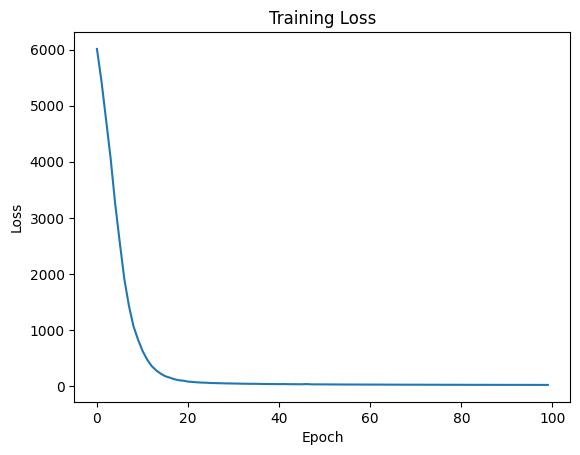

Model saved to models/gcrn_gcn_simulated_dom3.pth
Average Time per Epoch: 4.13s
Average CPU Usage: 76.60%
Average Memory Usage: 11.70%

Sum Time per Epoch: 412.82s
Sum CPU Usage: 76.60%
Sum Memory Usage: 11.70%


In [28]:
# Initialize model
input_dim = 35  
feature_dim = 16
latent_dim = 46
num_rec_layers = 2

model_simulated_dom3 = GCRN_gcn(input_dim, feature_dim, latent_dim, num_rec_layers)
print(model_simulated_dom3)
print(f"Total number of trainable parameters: {model_simulated_dom3.count_parameters()}\n")

# Train model 
train_model(model_simulated_dom3, x_train_domain_3, adj_train_domain_3, num_epochs=100, lr=0.0001, save_path="models/gcrn_gcn_simulated_dom3.pth")

GCRN_gcn(
  (encoder): GCNEncoder(
    (conv1): GCN (16 -> 32)
    (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): GCN (32 -> 46)
    (bn2): BatchNorm1d(46, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (fc_mu): Linear(in_features=46, out_features=46, bias=True)
    (fc_logvar): Linear(in_features=46, out_features=46, bias=True)
  )
  (gru): GRU(46, 46, num_layers=2)
  (decoder): GCNDecoder(
    (fc): Linear(in_features=46, out_features=1610, bias=True)
    (bn0): BatchNorm1d(46, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv1): GCN (46 -> 92)
    (bn1): BatchNorm1d(92, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): GCN (92 -> 70)
    (bn2): BatchNorm1d(70, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): GCN (70 -> 35)
    (bn3): BatchNorm1d(35, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)
Total number o

Epoch 1/100: 100%|██████████| 80/80 [00:02<00:00, 37.85it/s]


Epoch 1, Loss: 6169.460821533203
Time: 2.12s, CPU: 70.90%, Memory: 11.70%



Epoch 2/100: 100%|██████████| 80/80 [00:02<00:00, 35.63it/s]


Epoch 2, Loss: 5684.835502624512
Time: 2.25s, CPU: 77.90%, Memory: 11.70%



Epoch 3/100: 100%|██████████| 80/80 [00:02<00:00, 29.48it/s]


Epoch 3, Loss: 5164.884518432617
Time: 2.72s, CPU: 80.30%, Memory: 11.70%



Epoch 4/100: 100%|██████████| 80/80 [00:02<00:00, 37.36it/s]


Epoch 4, Loss: 4590.339739990234
Time: 2.15s, CPU: 79.20%, Memory: 11.70%



Epoch 5/100: 100%|██████████| 80/80 [00:06<00:00, 11.43it/s]


Epoch 5, Loss: 4091.208137512207
Time: 7.00s, CPU: 86.00%, Memory: 11.70%



Epoch 6/100: 100%|██████████| 80/80 [00:18<00:00,  4.39it/s]


Epoch 6, Loss: 3505.8339309692383
Time: 18.24s, CPU: 88.10%, Memory: 11.70%



Epoch 7/100: 100%|██████████| 80/80 [00:02<00:00, 34.44it/s]


Epoch 7, Loss: 2939.7309562683104
Time: 2.33s, CPU: 78.80%, Memory: 11.70%



Epoch 8/100: 100%|██████████| 80/80 [00:01<00:00, 40.66it/s]


Epoch 8, Loss: 2353.1200462341308
Time: 1.97s, CPU: 77.10%, Memory: 11.70%



Epoch 9/100: 100%|██████████| 80/80 [00:08<00:00,  9.09it/s]


Epoch 9, Loss: 1875.182248687744
Time: 8.80s, CPU: 86.70%, Memory: 11.60%



Epoch 10/100: 100%|██████████| 80/80 [00:02<00:00, 39.40it/s]


Epoch 10, Loss: 1420.9905185699463
Time: 2.03s, CPU: 77.20%, Memory: 11.70%



Epoch 11/100: 100%|██████████| 80/80 [00:02<00:00, 28.59it/s]


Epoch 11, Loss: 1099.2752277374268
Time: 2.80s, CPU: 79.20%, Memory: 11.70%



Epoch 12/100: 100%|██████████| 80/80 [00:01<00:00, 41.77it/s]


Epoch 12, Loss: 849.3272390365601
Time: 1.92s, CPU: 78.60%, Memory: 11.70%



Epoch 13/100: 100%|██████████| 80/80 [00:02<00:00, 34.85it/s]


Epoch 13, Loss: 646.6088781356812
Time: 2.30s, CPU: 78.50%, Memory: 11.70%



Epoch 14/100: 100%|██████████| 80/80 [00:01<00:00, 42.86it/s]


Epoch 14, Loss: 498.1111011505127
Time: 1.87s, CPU: 76.70%, Memory: 11.70%



Epoch 15/100: 100%|██████████| 80/80 [00:09<00:00,  8.43it/s]


Epoch 15, Loss: 394.99153594970704
Time: 9.49s, CPU: 86.60%, Memory: 11.60%



Epoch 16/100: 100%|██████████| 80/80 [00:02<00:00, 39.73it/s]


Epoch 16, Loss: 317.2815035820007
Time: 2.02s, CPU: 77.00%, Memory: 11.70%



Epoch 17/100: 100%|██████████| 80/80 [00:02<00:00, 33.62it/s]


Epoch 17, Loss: 240.04508476257325
Time: 2.38s, CPU: 78.10%, Memory: 11.60%



Epoch 18/100: 100%|██████████| 80/80 [00:02<00:00, 37.81it/s]


Epoch 18, Loss: 210.55750064849855
Time: 2.12s, CPU: 78.70%, Memory: 11.70%



Epoch 19/100: 100%|██████████| 80/80 [00:01<00:00, 41.28it/s]


Epoch 19, Loss: 169.38874950408936
Time: 1.94s, CPU: 77.20%, Memory: 11.70%



Epoch 20/100: 100%|██████████| 80/80 [00:02<00:00, 30.48it/s]


Epoch 20, Loss: 148.90749287605286
Time: 2.63s, CPU: 80.00%, Memory: 11.70%



Epoch 21/100: 100%|██████████| 80/80 [00:01<00:00, 41.66it/s]


Epoch 21, Loss: 124.0872498512268
Time: 1.92s, CPU: 77.30%, Memory: 11.70%



Epoch 22/100: 100%|██████████| 80/80 [00:01<00:00, 41.17it/s]


Epoch 22, Loss: 106.40538823604584
Time: 1.95s, CPU: 77.50%, Memory: 11.70%



Epoch 23/100: 100%|██████████| 80/80 [00:02<00:00, 39.81it/s]


Epoch 23, Loss: 92.25151093006134
Time: 2.01s, CPU: 78.60%, Memory: 11.70%



Epoch 24/100: 100%|██████████| 80/80 [00:12<00:00,  6.37it/s]


Epoch 24, Loss: 88.97397944927215
Time: 12.58s, CPU: 87.40%, Memory: 11.70%



Epoch 25/100: 100%|██████████| 80/80 [00:02<00:00, 39.23it/s]


Epoch 25, Loss: 80.5272720336914
Time: 2.04s, CPU: 77.50%, Memory: 11.70%



Epoch 26/100: 100%|██████████| 80/80 [00:13<00:00,  6.08it/s]


Epoch 26, Loss: 78.25779483318328
Time: 13.16s, CPU: 87.60%, Memory: 11.60%



Epoch 27/100: 100%|██████████| 80/80 [00:01<00:00, 40.19it/s]


Epoch 27, Loss: 66.46436338424682
Time: 2.00s, CPU: 77.20%, Memory: 11.70%



Epoch 28/100: 100%|██████████| 80/80 [00:02<00:00, 34.44it/s]


Epoch 28, Loss: 68.16661484241486
Time: 2.32s, CPU: 78.20%, Memory: 11.60%



Epoch 29/100: 100%|██████████| 80/80 [00:02<00:00, 33.32it/s]


Epoch 29, Loss: 60.98666589260101
Time: 2.40s, CPU: 79.10%, Memory: 11.70%



Epoch 30/100: 100%|██████████| 80/80 [00:09<00:00,  8.65it/s]


Epoch 30, Loss: 59.65026326179505
Time: 9.25s, CPU: 87.70%, Memory: 11.70%



Epoch 31/100: 100%|██████████| 80/80 [00:02<00:00, 30.24it/s]


Epoch 31, Loss: 57.82340347766876
Time: 2.65s, CPU: 79.60%, Memory: 11.70%



Epoch 32/100: 100%|██████████| 80/80 [00:02<00:00, 36.96it/s]


Epoch 32, Loss: 54.51654016971588
Time: 2.17s, CPU: 77.00%, Memory: 11.70%



Epoch 33/100: 100%|██████████| 80/80 [00:02<00:00, 31.94it/s]


Epoch 33, Loss: 53.56769065856933
Time: 2.51s, CPU: 80.00%, Memory: 11.70%



Epoch 34/100: 100%|██████████| 80/80 [00:02<00:00, 37.14it/s]


Epoch 34, Loss: 51.12333216667175
Time: 2.16s, CPU: 77.40%, Memory: 11.70%



Epoch 35/100: 100%|██████████| 80/80 [00:02<00:00, 30.98it/s]


Epoch 35, Loss: 48.92625689506531
Time: 2.58s, CPU: 78.90%, Memory: 11.70%



Epoch 36/100: 100%|██████████| 80/80 [00:02<00:00, 30.67it/s]


Epoch 36, Loss: 49.6653192281723
Time: 2.61s, CPU: 78.90%, Memory: 11.70%



Epoch 37/100: 100%|██████████| 80/80 [00:02<00:00, 29.09it/s]


Epoch 37, Loss: 47.87142691612244
Time: 2.75s, CPU: 80.30%, Memory: 11.60%



Epoch 38/100: 100%|██████████| 80/80 [00:19<00:00,  4.04it/s]


Epoch 38, Loss: 47.62949655056
Time: 19.79s, CPU: 88.90%, Memory: 11.70%



Epoch 39/100: 100%|██████████| 80/80 [00:12<00:00,  6.28it/s]


Epoch 39, Loss: 45.2327675819397
Time: 12.75s, CPU: 88.10%, Memory: 11.70%



Epoch 40/100: 100%|██████████| 80/80 [00:02<00:00, 35.34it/s]


Epoch 40, Loss: 45.22377057075501
Time: 2.27s, CPU: 77.20%, Memory: 11.70%



Epoch 41/100: 100%|██████████| 80/80 [00:05<00:00, 13.42it/s]


Epoch 41, Loss: 43.959842109680174
Time: 5.97s, CPU: 85.50%, Memory: 11.70%



Epoch 42/100: 100%|██████████| 80/80 [00:02<00:00, 28.49it/s]


Epoch 42, Loss: 43.10046603679657
Time: 2.81s, CPU: 80.40%, Memory: 11.60%



Epoch 43/100: 100%|██████████| 80/80 [00:02<00:00, 36.65it/s]


Epoch 43, Loss: 43.175421023368834
Time: 2.19s, CPU: 77.50%, Memory: 11.60%



Epoch 44/100: 100%|██████████| 80/80 [00:09<00:00,  8.38it/s]


Epoch 44, Loss: 41.54598484039307
Time: 9.55s, CPU: 87.30%, Memory: 11.70%



Epoch 45/100: 100%|██████████| 80/80 [00:08<00:00,  9.93it/s]


Epoch 45, Loss: 40.86781051158905
Time: 8.06s, CPU: 86.80%, Memory: 11.70%



Epoch 46/100: 100%|██████████| 80/80 [00:03<00:00, 22.16it/s]


Epoch 46, Loss: 39.87276484966278
Time: 3.61s, CPU: 83.00%, Memory: 11.70%



Epoch 47/100: 100%|██████████| 80/80 [00:02<00:00, 33.11it/s]


Epoch 47, Loss: 39.36000802516937
Time: 2.42s, CPU: 78.60%, Memory: 11.70%



Epoch 48/100: 100%|██████████| 80/80 [00:02<00:00, 36.73it/s]


Epoch 48, Loss: 39.05812232494354
Time: 2.18s, CPU: 77.90%, Memory: 11.70%



Epoch 49/100: 100%|██████████| 80/80 [00:09<00:00,  8.43it/s]


Epoch 49, Loss: 38.491242456436154
Time: 9.49s, CPU: 87.20%, Memory: 11.70%



Epoch 50/100: 100%|██████████| 80/80 [00:02<00:00, 39.66it/s]


Epoch 50, Loss: 37.953619635105134
Time: 2.02s, CPU: 77.90%, Memory: 11.70%



Epoch 51/100: 100%|██████████| 80/80 [00:02<00:00, 27.89it/s]


Epoch 51, Loss: 36.86560279130936
Time: 2.87s, CPU: 80.00%, Memory: 11.70%



Epoch 52/100: 100%|██████████| 80/80 [00:02<00:00, 36.83it/s]


Epoch 52, Loss: 37.0229226231575
Time: 2.17s, CPU: 77.80%, Memory: 11.70%



Epoch 53/100: 100%|██████████| 80/80 [00:02<00:00, 37.68it/s]


Epoch 53, Loss: 35.995635461807254
Time: 2.13s, CPU: 77.90%, Memory: 11.70%



Epoch 54/100: 100%|██████████| 80/80 [00:02<00:00, 32.32it/s]


Epoch 54, Loss: 35.52332265377045
Time: 2.48s, CPU: 79.00%, Memory: 11.70%



Epoch 55/100: 100%|██████████| 80/80 [00:02<00:00, 37.61it/s]


Epoch 55, Loss: 35.05319224596023
Time: 2.13s, CPU: 77.40%, Memory: 11.70%



Epoch 56/100: 100%|██████████| 80/80 [00:02<00:00, 28.80it/s]


Epoch 56, Loss: 34.63427404165268
Time: 2.78s, CPU: 79.70%, Memory: 11.70%



Epoch 57/100: 100%|██████████| 80/80 [00:02<00:00, 36.77it/s]


Epoch 57, Loss: 34.12401721477509
Time: 2.18s, CPU: 77.90%, Memory: 11.60%



Epoch 58/100: 100%|██████████| 80/80 [00:02<00:00, 31.35it/s]


Epoch 58, Loss: 33.93805537223816
Time: 2.56s, CPU: 80.20%, Memory: 11.70%



Epoch 59/100: 100%|██████████| 80/80 [00:02<00:00, 33.36it/s]


Epoch 59, Loss: 33.334745264053346
Time: 2.40s, CPU: 78.50%, Memory: 11.70%



Epoch 60/100: 100%|██████████| 80/80 [00:23<00:00,  3.44it/s]


Epoch 60, Loss: 32.71954618692398
Time: 23.26s, CPU: 88.90%, Memory: 11.60%



Epoch 61/100: 100%|██████████| 80/80 [00:05<00:00, 13.77it/s]


Epoch 61, Loss: 32.57092901468277
Time: 5.81s, CPU: 85.70%, Memory: 11.70%



Epoch 62/100: 100%|██████████| 80/80 [00:16<00:00,  4.93it/s]


Epoch 62, Loss: 32.533525907993315
Time: 16.22s, CPU: 88.20%, Memory: 11.70%



Epoch 63/100: 100%|██████████| 80/80 [00:09<00:00,  8.51it/s]


Epoch 63, Loss: 32.07150392532348
Time: 9.41s, CPU: 86.80%, Memory: 11.70%



Epoch 64/100: 100%|██████████| 80/80 [00:02<00:00, 32.60it/s]


Epoch 64, Loss: 31.716139125823975
Time: 2.46s, CPU: 78.20%, Memory: 11.70%



Epoch 65/100: 100%|██████████| 80/80 [00:05<00:00, 14.53it/s]


Epoch 65, Loss: 31.10755076408386
Time: 5.51s, CPU: 84.30%, Memory: 11.70%



Epoch 66/100: 100%|██████████| 80/80 [00:02<00:00, 30.87it/s]


Epoch 66, Loss: 30.487775409221648
Time: 2.59s, CPU: 78.50%, Memory: 11.70%



Epoch 67/100: 100%|██████████| 80/80 [00:02<00:00, 37.44it/s]


Epoch 67, Loss: 30.30175188779831
Time: 2.14s, CPU: 77.10%, Memory: 11.70%



Epoch 68/100: 100%|██████████| 80/80 [00:02<00:00, 35.22it/s]


Epoch 68, Loss: 30.122247529029845
Time: 2.27s, CPU: 77.40%, Memory: 11.70%



Epoch 69/100: 100%|██████████| 80/80 [00:02<00:00, 33.17it/s]


Epoch 69, Loss: 29.49906177520752
Time: 2.42s, CPU: 79.50%, Memory: 11.70%



Epoch 70/100: 100%|██████████| 80/80 [00:01<00:00, 42.36it/s]


Epoch 70, Loss: 29.24226553440094
Time: 1.89s, CPU: 76.80%, Memory: 11.70%



Epoch 71/100: 100%|██████████| 80/80 [00:19<00:00,  4.07it/s]


Epoch 71, Loss: 29.209046947956086
Time: 19.65s, CPU: 88.30%, Memory: 11.60%



Epoch 72/100: 100%|██████████| 80/80 [00:02<00:00, 39.26it/s]


Epoch 72, Loss: 28.80889872312546
Time: 2.04s, CPU: 78.20%, Memory: 11.60%



Epoch 73/100: 100%|██████████| 80/80 [00:14<00:00,  5.38it/s]


Epoch 73, Loss: 28.633344066143035
Time: 14.87s, CPU: 87.80%, Memory: 11.70%



Epoch 74/100: 100%|██████████| 80/80 [00:03<00:00, 24.95it/s]


Epoch 74, Loss: 28.39352705478668
Time: 3.21s, CPU: 82.10%, Memory: 11.70%



Epoch 75/100: 100%|██████████| 80/80 [00:06<00:00, 11.95it/s]


Epoch 75, Loss: 28.109349644184114
Time: 6.70s, CPU: 85.70%, Memory: 11.60%



Epoch 76/100: 100%|██████████| 80/80 [00:01<00:00, 40.59it/s]


Epoch 76, Loss: 28.36074892282486
Time: 1.97s, CPU: 77.20%, Memory: 11.70%



Epoch 77/100: 100%|██████████| 80/80 [00:01<00:00, 40.17it/s]


Epoch 77, Loss: 28.12145667076111
Time: 2.00s, CPU: 77.00%, Memory: 11.70%



Epoch 78/100: 100%|██████████| 80/80 [00:02<00:00, 34.75it/s]


Epoch 78, Loss: 27.807952547073363
Time: 2.31s, CPU: 78.50%, Memory: 11.70%



Epoch 79/100: 100%|██████████| 80/80 [00:19<00:00,  4.05it/s]


Epoch 79, Loss: 27.46243259906769
Time: 19.77s, CPU: 88.70%, Memory: 11.70%



Epoch 80/100: 100%|██████████| 80/80 [00:09<00:00,  8.59it/s]


Epoch 80, Loss: 27.583658456802368
Time: 9.31s, CPU: 87.00%, Memory: 11.70%



Epoch 81/100: 100%|██████████| 80/80 [00:01<00:00, 40.09it/s]


Epoch 81, Loss: 27.42444806098938
Time: 2.00s, CPU: 77.50%, Memory: 11.70%



Epoch 82/100: 100%|██████████| 80/80 [00:02<00:00, 29.08it/s]


Epoch 82, Loss: 27.46018022298813
Time: 2.75s, CPU: 80.10%, Memory: 11.70%



Epoch 83/100: 100%|██████████| 80/80 [00:30<00:00,  2.59it/s]


Epoch 83, Loss: 26.878103244304658
Time: 30.86s, CPU: 89.00%, Memory: 11.60%



Epoch 84/100: 100%|██████████| 80/80 [00:02<00:00, 36.23it/s]


Epoch 84, Loss: 26.760062777996062
Time: 2.21s, CPU: 78.50%, Memory: 11.60%



Epoch 85/100: 100%|██████████| 80/80 [00:06<00:00, 13.05it/s]


Epoch 85, Loss: 26.462637531757355
Time: 6.13s, CPU: 85.90%, Memory: 11.60%



Epoch 86/100: 100%|██████████| 80/80 [00:02<00:00, 36.40it/s]


Epoch 86, Loss: 26.579067397117615
Time: 2.20s, CPU: 77.80%, Memory: 11.70%



Epoch 87/100: 100%|██████████| 80/80 [00:10<00:00,  7.69it/s]


Epoch 87, Loss: 26.29621891975403
Time: 10.40s, CPU: 87.00%, Memory: 11.60%



Epoch 88/100: 100%|██████████| 80/80 [00:02<00:00, 29.95it/s]


Epoch 88, Loss: 26.13641836643219
Time: 2.67s, CPU: 77.10%, Memory: 11.60%



Epoch 89/100: 100%|██████████| 80/80 [00:02<00:00, 28.75it/s]


Epoch 89, Loss: 25.848483943939208
Time: 2.78s, CPU: 80.20%, Memory: 11.70%



Epoch 90/100: 100%|██████████| 80/80 [00:02<00:00, 30.28it/s]


Epoch 90, Loss: 25.97481347322464
Time: 2.64s, CPU: 79.40%, Memory: 11.70%



Epoch 91/100: 100%|██████████| 80/80 [00:02<00:00, 35.19it/s]


Epoch 91, Loss: 25.74640824794769
Time: 2.28s, CPU: 77.70%, Memory: 11.70%



Epoch 92/100: 100%|██████████| 80/80 [00:06<00:00, 12.76it/s]


Epoch 92, Loss: 25.51005177497864
Time: 6.27s, CPU: 85.80%, Memory: 11.70%



Epoch 93/100: 100%|██████████| 80/80 [00:02<00:00, 35.94it/s]


Epoch 93, Loss: 25.393401777744295
Time: 2.23s, CPU: 78.20%, Memory: 11.70%



Epoch 94/100: 100%|██████████| 80/80 [00:02<00:00, 35.49it/s]


Epoch 94, Loss: 25.05940988063812
Time: 2.26s, CPU: 77.30%, Memory: 11.70%



Epoch 95/100: 100%|██████████| 80/80 [00:17<00:00,  4.64it/s]


Epoch 95, Loss: 25.05154014825821
Time: 17.25s, CPU: 88.40%, Memory: 11.60%



Epoch 96/100: 100%|██████████| 80/80 [00:02<00:00, 35.21it/s]


Epoch 96, Loss: 25.03950455188751
Time: 2.28s, CPU: 79.30%, Memory: 11.70%



Epoch 97/100: 100%|██████████| 80/80 [00:02<00:00, 36.48it/s]


Epoch 97, Loss: 24.896577072143554
Time: 2.20s, CPU: 77.30%, Memory: 11.70%



Epoch 98/100: 100%|██████████| 80/80 [00:02<00:00, 32.26it/s]


Epoch 98, Loss: 24.60758889913559
Time: 2.48s, CPU: 78.70%, Memory: 11.70%



Epoch 99/100: 100%|██████████| 80/80 [00:02<00:00, 36.38it/s]


Epoch 99, Loss: 24.415291571617125
Time: 2.20s, CPU: 77.70%, Memory: 11.70%



Epoch 100/100: 100%|██████████| 80/80 [00:09<00:00,  8.22it/s]


Epoch 100, Loss: 24.632356452941895
Time: 9.73s, CPU: 87.30%, Memory: 11.60%



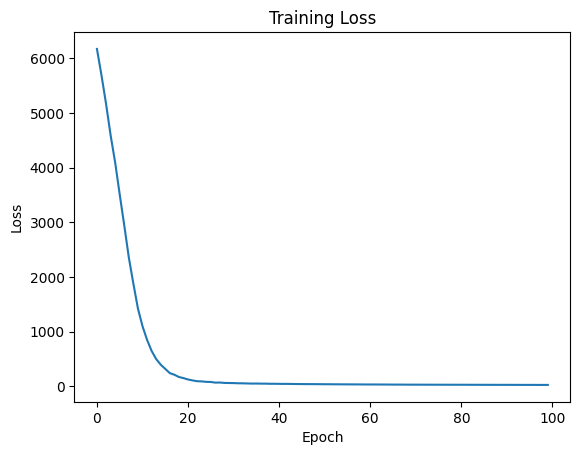

Model saved to models/gcrn_gcn_simulated_dom4.pth
Average Time per Epoch: 5.21s
Average CPU Usage: 87.30%
Average Memory Usage: 11.60%

Sum Time per Epoch: 520.61s
Sum CPU Usage: 87.30%
Sum Memory Usage: 11.60%


In [29]:
# Initialize model
input_dim = 35  
feature_dim = 16
latent_dim = 46
num_rec_layers = 2

model_simulated_dom4 = GCRN_gcn(input_dim, feature_dim, latent_dim, num_rec_layers)
print(model_simulated_dom4)
print(f"Total number of trainable parameters: {model_simulated_dom4.count_parameters()}\n")

# Train model 
train_model(model_simulated_dom4, x_train_domain_4, adj_train_domain_4, num_epochs=100, lr=0.0001, save_path="models/gcrn_gcn_simulated_dom4.pth")

#### SLIM Dataset

GCRN_gcn(
  (encoder): GCNEncoder(
    (conv1): GCN (32 -> 64)
    (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): GCN (64 -> 60)
    (bn2): BatchNorm1d(60, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (fc_mu): Linear(in_features=60, out_features=60, bias=True)
    (fc_logvar): Linear(in_features=60, out_features=60, bias=True)
  )
  (gru): GRU(60, 60, num_layers=2)
  (decoder): GCNDecoder(
    (fc): Linear(in_features=60, out_features=9600, bias=True)
    (bn0): BatchNorm1d(60, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv1): GCN (60 -> 120)
    (bn1): BatchNorm1d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): GCN (120 -> 320)
    (bn2): BatchNorm1d(320, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): GCN (320 -> 160)
    (bn3): BatchNorm1d(160, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)
Total 

Epoch 1/100: 100%|██████████| 96/96 [00:04<00:00, 22.57it/s]


Epoch 1, Loss: 287907.2736816406
Time: 4.26s, CPU: 75.60%, Memory: 11.70%



Epoch 2/100: 100%|██████████| 96/96 [00:15<00:00,  6.05it/s]


Epoch 2, Loss: 9412.820747375488
Time: 15.87s, CPU: 88.10%, Memory: 11.80%



Epoch 3/100: 100%|██████████| 96/96 [00:03<00:00, 24.06it/s]


Epoch 3, Loss: 1389.1985861460369
Time: 3.99s, CPU: 77.80%, Memory: 11.80%



Epoch 4/100: 100%|██████████| 96/96 [00:18<00:00,  5.21it/s]


Epoch 4, Loss: 480.55888414382935
Time: 18.42s, CPU: 87.50%, Memory: 11.80%



Epoch 5/100: 100%|██████████| 96/96 [00:03<00:00, 25.62it/s]


Epoch 5, Loss: 310.84285521507263
Time: 3.75s, CPU: 77.20%, Memory: 11.80%



Epoch 6/100: 100%|██████████| 96/96 [00:03<00:00, 25.50it/s]


Epoch 6, Loss: 313.49817395210266
Time: 3.77s, CPU: 78.40%, Memory: 11.80%



Epoch 7/100: 100%|██████████| 96/96 [00:03<00:00, 24.40it/s]


Epoch 7, Loss: 275.8733120759328
Time: 3.94s, CPU: 78.10%, Memory: 11.80%



Epoch 8/100: 100%|██████████| 96/96 [00:04<00:00, 22.58it/s]


Epoch 8, Loss: 263.4157799084981
Time: 4.25s, CPU: 78.80%, Memory: 11.80%



Epoch 9/100: 100%|██████████| 96/96 [00:04<00:00, 23.74it/s]


Epoch 9, Loss: 280.25115450223285
Time: 4.05s, CPU: 77.80%, Memory: 11.80%



Epoch 10/100: 100%|██████████| 96/96 [00:04<00:00, 23.26it/s]


Epoch 10, Loss: 354.5003490447998
Time: 4.13s, CPU: 78.30%, Memory: 11.80%



Epoch 11/100: 100%|██████████| 96/96 [00:07<00:00, 13.51it/s]


Epoch 11, Loss: 261.053120692571
Time: 7.11s, CPU: 83.20%, Memory: 11.80%



Epoch 12/100: 100%|██████████| 96/96 [00:29<00:00,  3.30it/s]


Epoch 12, Loss: 242.97561085224152
Time: 29.06s, CPU: 87.90%, Memory: 11.80%



Epoch 13/100: 100%|██████████| 96/96 [00:03<00:00, 26.68it/s]


Epoch 13, Loss: 243.19921656449637
Time: 3.60s, CPU: 77.40%, Memory: 11.80%



Epoch 14/100: 100%|██████████| 96/96 [00:11<00:00,  8.63it/s]


Epoch 14, Loss: 235.92387660344443
Time: 11.13s, CPU: 85.60%, Memory: 11.80%



Epoch 15/100: 100%|██████████| 96/96 [00:08<00:00, 11.64it/s]


Epoch 15, Loss: 234.5705489317576
Time: 8.25s, CPU: 83.70%, Memory: 11.80%



Epoch 16/100: 100%|██████████| 96/96 [00:03<00:00, 25.27it/s]


Epoch 16, Loss: 227.5468235015869
Time: 3.80s, CPU: 77.50%, Memory: 11.80%



Epoch 17/100: 100%|██████████| 96/96 [00:04<00:00, 20.43it/s]


Epoch 17, Loss: 224.13414374987283
Time: 4.70s, CPU: 80.00%, Memory: 11.80%



Epoch 18/100: 100%|██████████| 96/96 [00:04<00:00, 22.35it/s]


Epoch 18, Loss: 222.81879365444183
Time: 4.30s, CPU: 78.70%, Memory: 11.80%



Epoch 19/100: 100%|██████████| 96/96 [00:04<00:00, 21.85it/s]


Epoch 19, Loss: 220.87003326416016
Time: 4.40s, CPU: 78.50%, Memory: 11.80%



Epoch 20/100: 100%|██████████| 96/96 [00:03<00:00, 25.23it/s]


Epoch 20, Loss: 220.59741441408792
Time: 3.81s, CPU: 77.00%, Memory: 11.80%



Epoch 21/100: 100%|██████████| 96/96 [00:04<00:00, 22.80it/s]


Epoch 21, Loss: 207.65292445818582
Time: 4.21s, CPU: 78.40%, Memory: 11.80%



Epoch 22/100: 100%|██████████| 96/96 [00:11<00:00,  8.34it/s]


Epoch 22, Loss: 207.14158169428507
Time: 11.52s, CPU: 85.50%, Memory: 11.80%



Epoch 23/100: 100%|██████████| 96/96 [00:03<00:00, 24.46it/s]


Epoch 23, Loss: 203.06646736462912
Time: 3.93s, CPU: 78.40%, Memory: 11.80%



Epoch 24/100: 100%|██████████| 96/96 [00:04<00:00, 23.73it/s]


Epoch 24, Loss: 203.44062495231628
Time: 4.07s, CPU: 77.60%, Memory: 11.80%



Epoch 25/100: 100%|██████████| 96/96 [00:04<00:00, 23.87it/s]


Epoch 25, Loss: 198.2432200908661
Time: 4.02s, CPU: 78.40%, Memory: 11.80%



Epoch 26/100: 100%|██████████| 96/96 [00:04<00:00, 23.69it/s]


Epoch 26, Loss: 194.98995892206827
Time: 4.05s, CPU: 77.60%, Memory: 11.80%



Epoch 27/100: 100%|██████████| 96/96 [00:04<00:00, 21.65it/s]


Epoch 27, Loss: 194.67842853069305
Time: 4.44s, CPU: 79.40%, Memory: 11.80%



Epoch 28/100: 100%|██████████| 96/96 [00:04<00:00, 23.55it/s]


Epoch 28, Loss: 192.5722449620565
Time: 4.08s, CPU: 78.10%, Memory: 11.80%



Epoch 29/100: 100%|██████████| 96/96 [00:04<00:00, 21.01it/s]


Epoch 29, Loss: 196.7788111368815
Time: 4.57s, CPU: 79.60%, Memory: 11.80%



Epoch 30/100: 100%|██████████| 96/96 [00:04<00:00, 21.73it/s]


Epoch 30, Loss: 190.85808690388998
Time: 4.42s, CPU: 78.30%, Memory: 11.80%



Epoch 31/100: 100%|██████████| 96/96 [00:19<00:00,  5.00it/s]


Epoch 31, Loss: 187.80866718292236
Time: 19.19s, CPU: 87.20%, Memory: 11.80%



Epoch 32/100: 100%|██████████| 96/96 [00:07<00:00, 12.73it/s]


Epoch 32, Loss: 186.61281808217367
Time: 7.54s, CPU: 83.30%, Memory: 11.80%



Epoch 33/100: 100%|██████████| 96/96 [00:07<00:00, 12.86it/s]


Epoch 33, Loss: 185.92273290952048
Time: 7.47s, CPU: 83.90%, Memory: 11.80%



Epoch 34/100: 100%|██████████| 96/96 [00:20<00:00,  4.72it/s]


Epoch 34, Loss: 184.62749417622885
Time: 20.33s, CPU: 87.50%, Memory: 11.80%



Epoch 35/100: 100%|██████████| 96/96 [00:06<00:00, 15.93it/s]


Epoch 35, Loss: 195.32883222897848
Time: 6.03s, CPU: 81.60%, Memory: 11.80%



Epoch 36/100: 100%|██████████| 96/96 [00:04<00:00, 21.47it/s]


Epoch 36, Loss: 183.7266707420349
Time: 4.50s, CPU: 79.20%, Memory: 11.80%



Epoch 37/100: 100%|██████████| 96/96 [00:04<00:00, 20.71it/s]


Epoch 37, Loss: 183.64942495028177
Time: 4.64s, CPU: 79.60%, Memory: 11.80%



Epoch 38/100: 100%|██████████| 96/96 [00:03<00:00, 24.07it/s]


Epoch 38, Loss: 182.80879481633505
Time: 3.99s, CPU: 77.70%, Memory: 11.80%



Epoch 39/100: 100%|██████████| 96/96 [00:04<00:00, 21.00it/s]


Epoch 39, Loss: 180.7983454068502
Time: 4.57s, CPU: 79.30%, Memory: 11.80%



Epoch 40/100: 100%|██████████| 96/96 [00:04<00:00, 22.27it/s]


Epoch 40, Loss: 178.50761477152506
Time: 4.31s, CPU: 78.30%, Memory: 11.80%



Epoch 41/100: 100%|██████████| 96/96 [00:04<00:00, 22.76it/s]


Epoch 41, Loss: 178.55839371681213
Time: 4.22s, CPU: 79.20%, Memory: 11.80%



Epoch 42/100: 100%|██████████| 96/96 [00:04<00:00, 23.26it/s]


Epoch 42, Loss: 177.17701721191406
Time: 4.13s, CPU: 79.00%, Memory: 11.80%



Epoch 43/100: 100%|██████████| 96/96 [00:07<00:00, 13.00it/s]


Epoch 43, Loss: 176.54723604520163
Time: 7.39s, CPU: 83.80%, Memory: 11.80%



Epoch 44/100: 100%|██████████| 96/96 [00:11<00:00,  8.04it/s]


Epoch 44, Loss: 177.29582937558493
Time: 11.95s, CPU: 85.70%, Memory: 11.80%



Epoch 45/100: 100%|██████████| 96/96 [00:19<00:00,  4.87it/s]


Epoch 45, Loss: 177.61357192198435
Time: 19.70s, CPU: 87.40%, Memory: 11.80%



Epoch 46/100: 100%|██████████| 96/96 [00:09<00:00, 10.64it/s]


Epoch 46, Loss: 175.57957915465036
Time: 9.03s, CPU: 85.20%, Memory: 11.80%



Epoch 47/100: 100%|██████████| 96/96 [00:16<00:00,  5.82it/s]


Epoch 47, Loss: 175.02896749973297
Time: 16.50s, CPU: 86.50%, Memory: 11.80%



Epoch 48/100: 100%|██████████| 96/96 [00:03<00:00, 24.55it/s]


Epoch 48, Loss: 174.9492457707723
Time: 3.91s, CPU: 78.40%, Memory: 11.80%



Epoch 49/100: 100%|██████████| 96/96 [00:14<00:00,  6.78it/s]


Epoch 49, Loss: 177.17762279510498
Time: 14.15s, CPU: 86.50%, Memory: 11.80%



Epoch 50/100: 100%|██████████| 96/96 [00:04<00:00, 21.23it/s]


Epoch 50, Loss: 177.39300092061362
Time: 4.53s, CPU: 79.90%, Memory: 11.80%



Epoch 51/100: 100%|██████████| 96/96 [00:04<00:00, 22.29it/s]


Epoch 51, Loss: 174.99845254421234
Time: 4.31s, CPU: 78.70%, Memory: 11.80%



Epoch 52/100: 100%|██████████| 96/96 [00:13<00:00,  7.23it/s]


Epoch 52, Loss: 173.67723651727042
Time: 13.27s, CPU: 85.70%, Memory: 11.80%



Epoch 53/100: 100%|██████████| 96/96 [00:26<00:00,  3.60it/s]


Epoch 53, Loss: 172.65728255112967
Time: 26.67s, CPU: 87.70%, Memory: 11.80%



Epoch 54/100: 100%|██████████| 96/96 [00:04<00:00, 21.59it/s]


Epoch 54, Loss: 174.00504235426584
Time: 4.45s, CPU: 79.50%, Memory: 11.80%



Epoch 55/100: 100%|██████████| 96/96 [00:08<00:00, 11.99it/s]


Epoch 55, Loss: 173.39139930407205
Time: 8.01s, CPU: 83.40%, Memory: 11.80%



Epoch 56/100: 100%|██████████| 96/96 [00:08<00:00, 11.70it/s]


Epoch 56, Loss: 174.1492597659429
Time: 8.21s, CPU: 83.90%, Memory: 11.80%



Epoch 57/100: 100%|██████████| 96/96 [00:10<00:00,  9.49it/s]


Epoch 57, Loss: 172.1830088297526
Time: 10.12s, CPU: 84.60%, Memory: 11.80%



Epoch 58/100: 100%|██████████| 96/96 [00:19<00:00,  5.04it/s]


Epoch 58, Loss: 173.50274169445038
Time: 19.07s, CPU: 87.40%, Memory: 11.70%



Epoch 59/100: 100%|██████████| 96/96 [00:04<00:00, 22.40it/s]


Epoch 59, Loss: 174.038228114446
Time: 4.29s, CPU: 78.60%, Memory: 11.80%



Epoch 60/100: 100%|██████████| 96/96 [00:25<00:00,  3.77it/s]


Epoch 60, Loss: 170.6446330944697
Time: 25.48s, CPU: 88.00%, Memory: 11.80%



Epoch 61/100: 100%|██████████| 96/96 [00:04<00:00, 21.18it/s]


Epoch 61, Loss: 173.5091543594996
Time: 4.54s, CPU: 79.10%, Memory: 11.80%



Epoch 62/100: 100%|██████████| 96/96 [00:04<00:00, 21.06it/s]


Epoch 62, Loss: 171.2080778280894
Time: 4.56s, CPU: 78.10%, Memory: 11.80%



Epoch 63/100: 100%|██████████| 96/96 [00:04<00:00, 20.38it/s]


Epoch 63, Loss: 169.05491308371225
Time: 4.71s, CPU: 79.10%, Memory: 11.80%



Epoch 64/100: 100%|██████████| 96/96 [00:25<00:00,  3.80it/s]


Epoch 64, Loss: 169.31117502848306
Time: 25.27s, CPU: 88.20%, Memory: 11.80%



Epoch 65/100: 100%|██████████| 96/96 [00:24<00:00,  3.85it/s]


Epoch 65, Loss: 169.66049965222678
Time: 24.92s, CPU: 88.10%, Memory: 11.80%



Epoch 66/100: 100%|██████████| 96/96 [00:11<00:00,  8.29it/s]


Epoch 66, Loss: 169.20851782957712
Time: 11.58s, CPU: 85.80%, Memory: 11.80%



Epoch 67/100: 100%|██████████| 96/96 [00:08<00:00, 11.98it/s]


Epoch 67, Loss: 168.743916730086
Time: 8.02s, CPU: 83.90%, Memory: 11.80%



Epoch 68/100: 100%|██████████| 96/96 [00:04<00:00, 23.47it/s]


Epoch 68, Loss: 170.60658657550812
Time: 4.09s, CPU: 78.10%, Memory: 11.80%



Epoch 69/100: 100%|██████████| 96/96 [00:04<00:00, 23.34it/s]


Epoch 69, Loss: 170.46164667606354
Time: 4.11s, CPU: 78.30%, Memory: 11.80%



Epoch 70/100: 100%|██████████| 96/96 [00:04<00:00, 21.50it/s]


Epoch 70, Loss: 169.27129431565604
Time: 4.47s, CPU: 79.30%, Memory: 11.80%



Epoch 71/100: 100%|██████████| 96/96 [00:07<00:00, 12.29it/s]


Epoch 71, Loss: 169.75619872411093
Time: 7.81s, CPU: 83.00%, Memory: 11.80%



Epoch 72/100: 100%|██████████| 96/96 [00:08<00:00, 10.68it/s]


Epoch 72, Loss: 170.49383421738943
Time: 8.99s, CPU: 85.30%, Memory: 11.70%



Epoch 73/100: 100%|██████████| 96/96 [00:04<00:00, 21.80it/s]


Epoch 73, Loss: 169.6484842300415
Time: 4.41s, CPU: 79.30%, Memory: 11.80%



Epoch 74/100: 100%|██████████| 96/96 [00:22<00:00,  4.36it/s]


Epoch 74, Loss: 170.45532774925232
Time: 22.01s, CPU: 87.30%, Memory: 11.80%



Epoch 75/100: 100%|██████████| 96/96 [00:04<00:00, 22.89it/s]


Epoch 75, Loss: 169.65913116931915
Time: 4.20s, CPU: 78.40%, Memory: 11.80%



Epoch 76/100: 100%|██████████| 96/96 [00:04<00:00, 21.37it/s]


Epoch 76, Loss: 168.15599250793457
Time: 4.49s, CPU: 78.70%, Memory: 11.80%



Epoch 77/100: 100%|██████████| 96/96 [00:04<00:00, 22.86it/s]


Epoch 77, Loss: 170.36653848489127
Time: 4.20s, CPU: 78.00%, Memory: 11.80%



Epoch 78/100: 100%|██████████| 96/96 [00:04<00:00, 22.20it/s]


Epoch 78, Loss: 170.41739010810852
Time: 4.33s, CPU: 78.10%, Memory: 11.80%



Epoch 79/100: 100%|██████████| 96/96 [00:03<00:00, 24.68it/s]


Epoch 79, Loss: 169.30503578980765
Time: 3.89s, CPU: 77.60%, Memory: 11.80%



Epoch 80/100: 100%|██████████| 96/96 [00:04<00:00, 22.23it/s]


Epoch 80, Loss: 170.7034828265508
Time: 4.32s, CPU: 78.30%, Memory: 11.80%



Epoch 81/100: 100%|██████████| 96/96 [00:03<00:00, 24.45it/s]


Epoch 81, Loss: 170.12984708944956
Time: 3.93s, CPU: 78.40%, Memory: 11.80%



Epoch 82/100: 100%|██████████| 96/96 [00:04<00:00, 21.33it/s]


Epoch 82, Loss: 169.84954718748727
Time: 4.50s, CPU: 79.20%, Memory: 11.70%



Epoch 83/100: 100%|██████████| 96/96 [00:11<00:00,  8.64it/s]


Epoch 83, Loss: 169.22544948259988
Time: 11.12s, CPU: 85.80%, Memory: 11.80%



Epoch 84/100: 100%|██████████| 96/96 [00:03<00:00, 26.17it/s]


Epoch 84, Loss: 169.93303537368774
Time: 3.67s, CPU: 77.50%, Memory: 11.80%



Epoch 85/100: 100%|██████████| 96/96 [00:04<00:00, 19.97it/s]


Epoch 85, Loss: 170.48100566864014
Time: 4.81s, CPU: 79.00%, Memory: 11.80%



Epoch 86/100: 100%|██████████| 96/96 [00:10<00:00,  9.00it/s]


Epoch 86, Loss: 169.13192729155222
Time: 10.67s, CPU: 85.40%, Memory: 11.70%



Epoch 87/100: 100%|██████████| 96/96 [00:04<00:00, 20.86it/s]


Epoch 87, Loss: 169.56151672204336
Time: 4.61s, CPU: 79.90%, Memory: 11.80%



Epoch 88/100: 100%|██████████| 96/96 [00:10<00:00,  8.96it/s]


Epoch 88, Loss: 169.4547498424848
Time: 10.71s, CPU: 84.80%, Memory: 11.70%



Epoch 89/100: 100%|██████████| 96/96 [00:03<00:00, 25.84it/s]


Epoch 89, Loss: 169.61204703648886
Time: 3.72s, CPU: 77.00%, Memory: 11.80%



Epoch 90/100: 100%|██████████| 96/96 [00:07<00:00, 12.52it/s]


Epoch 90, Loss: 168.53741176923117
Time: 7.67s, CPU: 84.00%, Memory: 11.80%



Epoch 91/100: 100%|██████████| 96/96 [00:04<00:00, 20.21it/s]


Epoch 91, Loss: 169.70744093259177
Time: 4.75s, CPU: 79.70%, Memory: 11.80%



Epoch 92/100: 100%|██████████| 96/96 [00:03<00:00, 24.01it/s]


Epoch 92, Loss: 168.8318776289622
Time: 4.00s, CPU: 77.80%, Memory: 11.80%



Epoch 93/100: 100%|██████████| 96/96 [00:04<00:00, 22.90it/s]


Epoch 93, Loss: 169.59986213843027
Time: 4.20s, CPU: 79.30%, Memory: 11.80%



Epoch 94/100: 100%|██████████| 96/96 [00:08<00:00, 11.12it/s]


Epoch 94, Loss: 218.6608530084292
Time: 8.64s, CPU: 83.80%, Memory: 11.70%



Epoch 95/100: 100%|██████████| 96/96 [00:03<00:00, 24.94it/s]


Epoch 95, Loss: 195.71150783697763
Time: 3.85s, CPU: 78.10%, Memory: 11.80%



Epoch 96/100: 100%|██████████| 96/96 [00:04<00:00, 23.09it/s]


Epoch 96, Loss: 185.31429088115692
Time: 4.16s, CPU: 78.40%, Memory: 11.80%



Epoch 97/100: 100%|██████████| 96/96 [00:04<00:00, 21.31it/s]


Epoch 97, Loss: 186.63395591576895
Time: 4.51s, CPU: 79.20%, Memory: 11.80%



Epoch 98/100: 100%|██████████| 96/96 [00:04<00:00, 23.35it/s]


Epoch 98, Loss: 185.60772097110748
Time: 4.11s, CPU: 78.50%, Memory: 11.80%



Epoch 99/100: 100%|██████████| 96/96 [00:03<00:00, 26.05it/s]


Epoch 99, Loss: 185.34512305259705
Time: 3.69s, CPU: 76.90%, Memory: 11.80%



Epoch 100/100: 100%|██████████| 96/96 [00:04<00:00, 21.72it/s]


Epoch 100, Loss: 183.32073060671487
Time: 4.42s, CPU: 78.60%, Memory: 11.90%



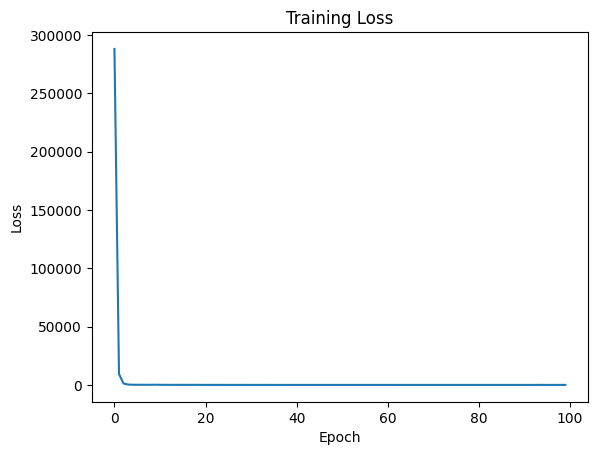

Model saved to models/gcrn_gcn_slim160.pth
Average Time per Epoch: 7.75s
Average CPU Usage: 78.60%
Average Memory Usage: 11.90%

Sum Time per Epoch: 774.53s
Sum CPU Usage: 78.60%
Sum Memory Usage: 11.90%


In [30]:
# Initialize model
input_dim = 160  
feature_dim = 32
latent_dim = 60
num_rec_layers = 2

model_slim160 = GCRN_gcn(input_dim, feature_dim, latent_dim, num_rec_layers)
print(model_slim160)
print(f"Total number of trainable parameters: {model_slim160.count_parameters()}\n")

# Train model 
train_model(model_slim160, x_train_slim160, adj_train_slim160, num_epochs=100, lr=0.0005, save_path="models/gcrn_gcn_slim160.pth")


GCRN_gcn(
  (encoder): GCNEncoder(
    (conv1): GCN (32 -> 64)
    (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): GCN (64 -> 60)
    (bn2): BatchNorm1d(60, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (fc_mu): Linear(in_features=60, out_features=60, bias=True)
    (fc_logvar): Linear(in_features=60, out_features=60, bias=True)
  )
  (gru): GRU(60, 60, num_layers=2)
  (decoder): GCNDecoder(
    (fc): Linear(in_features=60, out_features=16080, bias=True)
    (bn0): BatchNorm1d(60, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv1): GCN (60 -> 120)
    (bn1): BatchNorm1d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): GCN (120 -> 536)
    (bn2): BatchNorm1d(536, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): GCN (536 -> 268)
    (bn3): BatchNorm1d(268, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)
Total

Epoch 1/100:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 1/100: 100%|██████████| 96/96 [00:18<00:00,  5.14it/s]


Epoch 1, Loss: 1045496.0915527344
Time: 18.69s, CPU: 14.10%, Memory: 12.50%



Epoch 2/100: 100%|██████████| 96/96 [00:09<00:00, 10.61it/s]


Epoch 2, Loss: 29791.659301757812
Time: 9.05s, CPU: 82.80%, Memory: 12.60%



Epoch 3/100: 100%|██████████| 96/96 [00:05<00:00, 16.70it/s]


Epoch 3, Loss: 4788.939504623413
Time: 5.75s, CPU: 78.50%, Memory: 12.60%



Epoch 4/100: 100%|██████████| 96/96 [00:05<00:00, 18.14it/s]


Epoch 4, Loss: 1314.0047849019368
Time: 5.30s, CPU: 78.20%, Memory: 12.60%



Epoch 5/100: 100%|██████████| 96/96 [00:05<00:00, 18.84it/s]


Epoch 5, Loss: 681.5002187093099
Time: 5.10s, CPU: 77.90%, Memory: 12.60%



Epoch 6/100: 100%|██████████| 96/96 [00:18<00:00,  5.11it/s]


Epoch 6, Loss: 514.2659341494242
Time: 18.78s, CPU: 86.70%, Memory: 12.60%



Epoch 7/100: 100%|██████████| 96/96 [00:34<00:00,  2.80it/s]


Epoch 7, Loss: 512.5095750490824
Time: 34.33s, CPU: 88.10%, Memory: 12.60%



Epoch 8/100: 100%|██████████| 96/96 [00:09<00:00, 10.55it/s]


Epoch 8, Loss: 434.423214673996
Time: 9.10s, CPU: 82.70%, Memory: 12.60%



Epoch 9/100: 100%|██████████| 96/96 [00:05<00:00, 16.69it/s]


Epoch 9, Loss: 1660.8384653727214
Time: 5.76s, CPU: 78.50%, Memory: 12.60%



Epoch 10/100: 100%|██████████| 96/96 [00:05<00:00, 16.06it/s]


Epoch 10, Loss: 436.3232952753703
Time: 5.98s, CPU: 78.30%, Memory: 12.60%



Epoch 11/100: 100%|██████████| 96/96 [00:05<00:00, 16.42it/s]


Epoch 11, Loss: 411.7826582590739
Time: 5.85s, CPU: 78.80%, Memory: 12.60%



Epoch 12/100: 100%|██████████| 96/96 [00:05<00:00, 17.33it/s]


Epoch 12, Loss: 408.7630654176076
Time: 5.54s, CPU: 78.00%, Memory: 12.60%



Epoch 13/100: 100%|██████████| 96/96 [00:09<00:00, 10.21it/s]


Epoch 13, Loss: 397.48537341753644
Time: 9.40s, CPU: 82.90%, Memory: 12.60%



Epoch 14/100: 100%|██████████| 96/96 [00:16<00:00,  5.80it/s]


Epoch 14, Loss: 393.1584612528483
Time: 16.55s, CPU: 85.90%, Memory: 12.60%



Epoch 15/100: 100%|██████████| 96/96 [00:09<00:00, 10.46it/s]


Epoch 15, Loss: 398.893240292867
Time: 9.18s, CPU: 82.90%, Memory: 12.60%



Epoch 16/100: 100%|██████████| 96/96 [00:06<00:00, 15.45it/s]


Epoch 16, Loss: 389.85217062632245
Time: 6.22s, CPU: 78.40%, Memory: 12.70%



Epoch 17/100: 100%|██████████| 96/96 [00:12<00:00,  7.87it/s]


Epoch 17, Loss: 386.35917377471924
Time: 12.20s, CPU: 83.70%, Memory: 12.60%



Epoch 18/100: 100%|██████████| 96/96 [00:05<00:00, 17.16it/s]


Epoch 18, Loss: 383.8489893277486
Time: 5.60s, CPU: 78.50%, Memory: 12.70%



Epoch 19/100: 100%|██████████| 96/96 [00:05<00:00, 16.04it/s]


Epoch 19, Loss: 382.4053273200989
Time: 5.99s, CPU: 79.50%, Memory: 12.70%



Epoch 20/100: 100%|██████████| 96/96 [00:16<00:00,  5.83it/s]


Epoch 20, Loss: 372.5524853865306
Time: 16.47s, CPU: 85.40%, Memory: 12.60%



Epoch 21/100: 100%|██████████| 96/96 [00:09<00:00, 10.21it/s]


Epoch 21, Loss: 379.7610050837199
Time: 9.41s, CPU: 82.70%, Memory: 12.70%



Epoch 22/100: 100%|██████████| 96/96 [00:05<00:00, 16.23it/s]


Epoch 22, Loss: 423.7254150708516
Time: 5.92s, CPU: 79.10%, Memory: 12.70%



Epoch 23/100: 100%|██████████| 96/96 [00:05<00:00, 16.97it/s]


Epoch 23, Loss: 360.0314588546753
Time: 5.66s, CPU: 78.30%, Memory: 12.70%



Epoch 24/100: 100%|██████████| 96/96 [00:05<00:00, 18.03it/s]


Epoch 24, Loss: 368.79238780339557
Time: 5.33s, CPU: 77.70%, Memory: 12.70%



Epoch 25/100: 100%|██████████| 96/96 [00:17<00:00,  5.46it/s]


Epoch 25, Loss: 359.12038437525433
Time: 17.58s, CPU: 85.50%, Memory: 12.60%



Epoch 26/100: 100%|██████████| 96/96 [00:07<00:00, 13.62it/s]


Epoch 26, Loss: 350.8730947971344
Time: 7.05s, CPU: 81.00%, Memory: 12.60%



Epoch 27/100: 100%|██████████| 96/96 [00:05<00:00, 17.95it/s]


Epoch 27, Loss: 345.6154967546463
Time: 5.35s, CPU: 77.90%, Memory: 12.60%



Epoch 28/100: 100%|██████████| 96/96 [00:05<00:00, 16.75it/s]


Epoch 28, Loss: 358.09876481692
Time: 5.73s, CPU: 78.60%, Memory: 12.60%



Epoch 29/100: 100%|██████████| 96/96 [00:05<00:00, 16.11it/s]


Epoch 29, Loss: 335.2506987253825
Time: 5.96s, CPU: 78.70%, Memory: 12.70%



Epoch 30/100: 100%|██████████| 96/96 [00:09<00:00, 10.62it/s]


Epoch 30, Loss: 328.40071694056195
Time: 9.04s, CPU: 82.80%, Memory: 12.70%



Epoch 31/100: 100%|██████████| 96/96 [00:16<00:00,  5.97it/s]


Epoch 31, Loss: 320.4092125097911
Time: 16.07s, CPU: 85.40%, Memory: 12.60%



Epoch 32/100: 100%|██████████| 96/96 [00:15<00:00,  6.04it/s]


Epoch 32, Loss: 312.7226552963257
Time: 15.91s, CPU: 84.40%, Memory: 12.70%



Epoch 33/100: 100%|██████████| 96/96 [00:19<00:00,  4.91it/s]


Epoch 33, Loss: 307.9322777589162
Time: 19.54s, CPU: 86.20%, Memory: 12.60%



Epoch 34/100: 100%|██████████| 96/96 [00:12<00:00,  7.52it/s]


Epoch 34, Loss: 309.1440015633901
Time: 12.77s, CPU: 83.90%, Memory: 12.70%



Epoch 35/100: 100%|██████████| 96/96 [00:08<00:00, 11.02it/s]


Epoch 35, Loss: 302.18502442042035
Time: 8.71s, CPU: 82.50%, Memory: 12.70%



Epoch 36/100: 100%|██████████| 96/96 [00:05<00:00, 17.92it/s]


Epoch 36, Loss: 299.4811195532481
Time: 5.36s, CPU: 78.40%, Memory: 12.60%



Epoch 37/100: 100%|██████████| 96/96 [00:05<00:00, 16.03it/s]


Epoch 37, Loss: 295.463444630305
Time: 5.99s, CPU: 78.90%, Memory: 12.70%



Epoch 38/100: 100%|██████████| 96/96 [00:05<00:00, 16.57it/s]


Epoch 38, Loss: 292.9299572308858
Time: 5.80s, CPU: 78.50%, Memory: 12.70%



Epoch 39/100: 100%|██████████| 96/96 [00:05<00:00, 16.54it/s]


Epoch 39, Loss: 288.9266901810964
Time: 5.81s, CPU: 78.40%, Memory: 12.70%



Epoch 40/100: 100%|██████████| 96/96 [00:06<00:00, 15.77it/s]


Epoch 40, Loss: 290.0271162192027
Time: 6.09s, CPU: 79.00%, Memory: 12.60%



Epoch 41/100: 100%|██████████| 96/96 [00:16<00:00,  5.81it/s]


Epoch 41, Loss: 293.50719316800433
Time: 16.52s, CPU: 86.10%, Memory: 12.60%



Epoch 42/100: 100%|██████████| 96/96 [00:05<00:00, 17.44it/s]


Epoch 42, Loss: 281.13441650072735
Time: 5.51s, CPU: 78.10%, Memory: 12.70%



Epoch 43/100: 100%|██████████| 96/96 [00:12<00:00,  7.62it/s]


Epoch 43, Loss: 284.64547181129456
Time: 12.60s, CPU: 84.60%, Memory: 12.60%



Epoch 44/100: 100%|██████████| 96/96 [00:12<00:00,  7.67it/s]


Epoch 44, Loss: 280.7185179392497
Time: 12.52s, CPU: 84.80%, Memory: 12.70%



Epoch 45/100: 100%|██████████| 96/96 [00:12<00:00,  7.45it/s]


Epoch 45, Loss: 280.92500853538513
Time: 12.89s, CPU: 84.40%, Memory: 12.60%



Epoch 46/100: 100%|██████████| 96/96 [00:13<00:00,  7.35it/s]


Epoch 46, Loss: 290.7844293117523
Time: 13.07s, CPU: 84.60%, Memory: 12.70%



Epoch 47/100: 100%|██████████| 96/96 [00:12<00:00,  7.43it/s]


Epoch 47, Loss: 282.72226015726727
Time: 12.92s, CPU: 84.90%, Memory: 12.70%



Epoch 48/100: 100%|██████████| 96/96 [00:05<00:00, 17.07it/s]


Epoch 48, Loss: 278.9809259573619
Time: 5.63s, CPU: 78.80%, Memory: 12.70%



Epoch 49/100: 100%|██████████| 96/96 [00:09<00:00, 10.50it/s]


Epoch 49, Loss: 272.67532499631244
Time: 9.15s, CPU: 82.60%, Memory: 12.60%



Epoch 50/100: 100%|██████████| 96/96 [00:19<00:00,  4.88it/s]


Epoch 50, Loss: 273.65212845802307
Time: 19.69s, CPU: 86.30%, Memory: 12.60%



Epoch 51/100: 100%|██████████| 96/96 [00:06<00:00, 15.89it/s]


Epoch 51, Loss: 269.1596381664276
Time: 6.05s, CPU: 79.70%, Memory: 12.60%



Epoch 52/100: 100%|██████████| 96/96 [00:05<00:00, 16.67it/s]


Epoch 52, Loss: 266.7347382704417
Time: 5.76s, CPU: 78.40%, Memory: 12.70%



Epoch 53/100: 100%|██████████| 96/96 [00:09<00:00, 10.64it/s]


Epoch 53, Loss: 268.2385353247325
Time: 9.03s, CPU: 83.30%, Memory: 12.60%



Epoch 54/100: 100%|██████████| 96/96 [00:06<00:00, 15.91it/s]


Epoch 54, Loss: 265.0443317890167
Time: 6.04s, CPU: 78.50%, Memory: 12.70%



Epoch 55/100: 100%|██████████| 96/96 [00:05<00:00, 16.98it/s]


Epoch 55, Loss: 265.0322941144307
Time: 5.66s, CPU: 78.00%, Memory: 12.60%



Epoch 56/100: 100%|██████████| 96/96 [00:18<00:00,  5.11it/s]


Epoch 56, Loss: 263.1481146812439
Time: 18.79s, CPU: 86.60%, Memory: 12.60%



Epoch 57/100: 100%|██████████| 96/96 [00:08<00:00, 11.04it/s]


Epoch 57, Loss: 269.2375678221385
Time: 8.70s, CPU: 81.80%, Memory: 12.60%



Epoch 58/100: 100%|██████████| 96/96 [00:05<00:00, 16.81it/s]


Epoch 58, Loss: 277.899865547816
Time: 5.72s, CPU: 79.10%, Memory: 12.60%



Epoch 59/100: 100%|██████████| 96/96 [00:05<00:00, 18.11it/s]


Epoch 59, Loss: 271.79731639226276
Time: 5.30s, CPU: 77.60%, Memory: 12.70%



Epoch 60/100: 100%|██████████| 96/96 [00:05<00:00, 17.22it/s]


Epoch 60, Loss: 267.16743683815
Time: 5.58s, CPU: 78.10%, Memory: 12.70%



Epoch 61/100: 100%|██████████| 96/96 [00:05<00:00, 18.37it/s]


Epoch 61, Loss: 264.600200176239
Time: 5.23s, CPU: 78.20%, Memory: 12.70%



Epoch 62/100: 100%|██████████| 96/96 [00:22<00:00,  4.20it/s]


Epoch 62, Loss: 258.8867112795512
Time: 22.84s, CPU: 86.90%, Memory: 12.60%



Epoch 63/100: 100%|██████████| 96/96 [00:05<00:00, 18.08it/s]


Epoch 63, Loss: 260.2635501225789
Time: 5.31s, CPU: 77.40%, Memory: 12.60%



Epoch 64/100: 100%|██████████| 96/96 [00:12<00:00,  7.66it/s]


Epoch 64, Loss: 266.49311327934265
Time: 12.54s, CPU: 84.70%, Memory: 12.60%



Epoch 65/100: 100%|██████████| 96/96 [00:19<00:00,  4.93it/s]


Epoch 65, Loss: 257.99157945315045
Time: 19.46s, CPU: 85.80%, Memory: 12.70%



Epoch 66/100: 100%|██████████| 96/96 [00:20<00:00,  4.59it/s]


Epoch 66, Loss: 264.15993150075275
Time: 20.92s, CPU: 86.50%, Memory: 12.60%



Epoch 67/100: 100%|██████████| 96/96 [00:12<00:00,  7.55it/s]


Epoch 67, Loss: 257.45541373888653
Time: 12.72s, CPU: 83.90%, Memory: 12.60%



Epoch 68/100: 100%|██████████| 96/96 [00:12<00:00,  7.56it/s]


Epoch 68, Loss: 256.39598556359607
Time: 12.69s, CPU: 84.40%, Memory: 12.60%



Epoch 69/100: 100%|██████████| 96/96 [00:23<00:00,  4.14it/s]


Epoch 69, Loss: 264.0665094057719
Time: 23.17s, CPU: 87.00%, Memory: 12.60%



Epoch 70/100: 100%|██████████| 96/96 [00:09<00:00, 10.33it/s]


Epoch 70, Loss: 260.660847345988
Time: 9.30s, CPU: 82.70%, Memory: 12.60%



Epoch 71/100: 100%|██████████| 96/96 [00:06<00:00, 14.29it/s]


Epoch 71, Loss: 257.8802129427592
Time: 6.72s, CPU: 80.80%, Memory: 12.70%



Epoch 72/100: 100%|██████████| 96/96 [00:05<00:00, 16.77it/s]


Epoch 72, Loss: 258.2104533116023
Time: 5.73s, CPU: 78.70%, Memory: 12.70%



Epoch 73/100: 100%|██████████| 96/96 [00:05<00:00, 16.30it/s]


Epoch 73, Loss: 257.1001277764638
Time: 5.89s, CPU: 78.60%, Memory: 12.60%



Epoch 74/100: 100%|██████████| 96/96 [00:05<00:00, 16.30it/s]


Epoch 74, Loss: 257.586088180542
Time: 5.89s, CPU: 78.00%, Memory: 12.70%



Epoch 75/100: 100%|██████████| 96/96 [00:05<00:00, 17.41it/s]


Epoch 75, Loss: 256.1202088197072
Time: 5.52s, CPU: 78.40%, Memory: 12.70%



Epoch 76/100: 100%|██████████| 96/96 [00:05<00:00, 16.11it/s]


Epoch 76, Loss: 258.98852880795795
Time: 5.96s, CPU: 78.40%, Memory: 12.60%



Epoch 77/100: 100%|██████████| 96/96 [00:05<00:00, 16.58it/s]


Epoch 77, Loss: 257.14890726407367
Time: 5.79s, CPU: 78.40%, Memory: 12.70%



Epoch 78/100: 100%|██████████| 96/96 [00:20<00:00,  4.64it/s]


Epoch 78, Loss: 256.18610350290936
Time: 20.69s, CPU: 87.10%, Memory: 12.60%



Epoch 79/100: 100%|██████████| 96/96 [00:05<00:00, 17.52it/s]


Epoch 79, Loss: 257.73359926541644
Time: 5.48s, CPU: 78.20%, Memory: 12.60%



Epoch 80/100: 100%|██████████| 96/96 [00:09<00:00,  9.97it/s]


Epoch 80, Loss: 259.4570885499318
Time: 9.63s, CPU: 83.40%, Memory: 12.70%



Epoch 81/100: 100%|██████████| 96/96 [00:22<00:00,  4.34it/s]


Epoch 81, Loss: 262.63227494557697
Time: 22.14s, CPU: 87.30%, Memory: 12.70%



Epoch 82/100: 100%|██████████| 96/96 [00:06<00:00, 15.64it/s]


Epoch 82, Loss: 410.4094362010558
Time: 6.14s, CPU: 79.30%, Memory: 12.60%



Epoch 83/100: 100%|██████████| 96/96 [00:05<00:00, 17.10it/s]


Epoch 83, Loss: 343.2035503387451
Time: 5.62s, CPU: 78.60%, Memory: 12.70%



Epoch 84/100: 100%|██████████| 96/96 [00:12<00:00,  7.43it/s]


Epoch 84, Loss: 324.7817614078522
Time: 12.92s, CPU: 84.60%, Memory: 12.60%



Epoch 85/100: 100%|██████████| 96/96 [00:36<00:00,  2.66it/s]


Epoch 85, Loss: 319.3739456335704
Time: 36.07s, CPU: 87.90%, Memory: 12.60%



Epoch 86/100: 100%|██████████| 96/96 [00:16<00:00,  5.96it/s]


Epoch 86, Loss: 311.14161761601764
Time: 16.10s, CPU: 85.70%, Memory: 12.60%



Epoch 87/100: 100%|██████████| 96/96 [00:15<00:00,  6.14it/s]


Epoch 87, Loss: 316.20817653338116
Time: 15.64s, CPU: 85.30%, Memory: 12.60%



Epoch 88/100: 100%|██████████| 96/96 [00:15<00:00,  6.01it/s]


Epoch 88, Loss: 311.0378360748291
Time: 15.99s, CPU: 85.50%, Memory: 12.60%



Epoch 89/100: 100%|██████████| 96/96 [00:05<00:00, 17.66it/s]


Epoch 89, Loss: 306.03956151008606
Time: 5.44s, CPU: 77.60%, Memory: 12.70%



Epoch 90/100: 100%|██████████| 96/96 [00:05<00:00, 16.79it/s]


Epoch 90, Loss: 304.0292236804962
Time: 5.72s, CPU: 79.00%, Memory: 12.70%



Epoch 91/100: 100%|██████████| 96/96 [00:09<00:00, 10.34it/s]


Epoch 91, Loss: 303.2069350878398
Time: 9.28s, CPU: 82.30%, Memory: 12.70%



Epoch 92/100: 100%|██████████| 96/96 [00:12<00:00,  7.55it/s]


Epoch 92, Loss: 299.6436598400275
Time: 12.71s, CPU: 84.80%, Memory: 12.70%



Epoch 93/100: 100%|██████████| 96/96 [00:05<00:00, 16.83it/s]


Epoch 93, Loss: 301.39781014124554
Time: 5.71s, CPU: 78.90%, Memory: 12.70%



Epoch 94/100: 100%|██████████| 96/96 [00:06<00:00, 15.84it/s]


Epoch 94, Loss: 302.8088521162669
Time: 6.06s, CPU: 78.80%, Memory: 12.70%



Epoch 95/100: 100%|██████████| 96/96 [00:05<00:00, 16.23it/s]


Epoch 95, Loss: 302.48216621081036
Time: 5.92s, CPU: 78.80%, Memory: 12.70%



Epoch 96/100: 100%|██████████| 96/96 [00:19<00:00,  5.03it/s]


Epoch 96, Loss: 301.1091311772664
Time: 19.08s, CPU: 86.50%, Memory: 12.70%



Epoch 97/100: 100%|██████████| 96/96 [00:06<00:00, 15.63it/s]


Epoch 97, Loss: 299.72604060173035
Time: 6.14s, CPU: 79.60%, Memory: 12.60%



Epoch 98/100: 100%|██████████| 96/96 [00:09<00:00,  9.90it/s]


Epoch 98, Loss: 298.05312355359393
Time: 9.70s, CPU: 83.20%, Memory: 12.60%



Epoch 99/100: 100%|██████████| 96/96 [00:12<00:00,  7.56it/s]


Epoch 99, Loss: 298.1134165128072
Time: 12.71s, CPU: 85.20%, Memory: 12.70%



Epoch 100/100: 100%|██████████| 96/96 [00:05<00:00, 16.89it/s]


Epoch 100, Loss: 296.6322414080302
Time: 5.69s, CPU: 78.90%, Memory: 12.70%



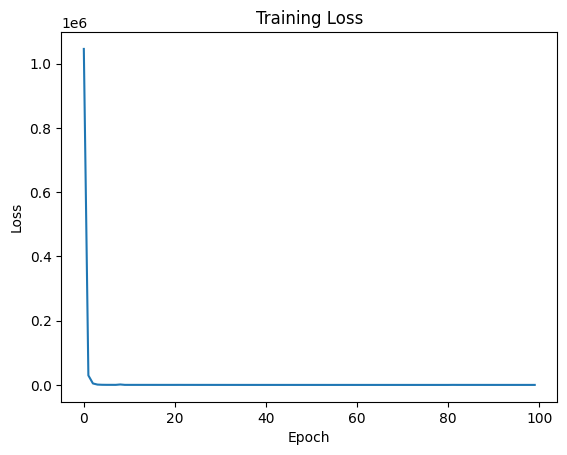

Model saved to models/gcrn_gcn_slim268.pth
Average Time per Epoch: 10.43s
Average CPU Usage: 78.90%
Average Memory Usage: 12.70%

Sum Time per Epoch: 1043.29s
Sum CPU Usage: 78.90%
Sum Memory Usage: 12.70%


In [59]:
# Initialize model
input_dim = 268  
feature_dim = 32
latent_dim = 60
num_rec_layers = 2

model_slim268 = GCRN_gcn(input_dim, feature_dim, latent_dim, num_rec_layers)
print(model_slim268)
print(f"Total number of trainable parameters: {model_slim268.count_parameters()}\n")

# Train model 
train_model(model_slim268, x_train_slim268, adj_train_slim268, num_epochs=100, lr=0.0005, save_path="models/gcrn_gcn_slim268.pth")


### Training with Gradient Analysis

In [29]:
import matplotlib.pyplot as plt
from PIL import Image
import torch.optim as optim
import tempfile
import os
import gc
from concurrent.futures import ThreadPoolExecutor

def plot_grad_flow(named_parameters, step, tmp_dir):
    ave_grads = []
    max_grads = []
    layers = []
    for n, p in named_parameters:
        if p.requires_grad and "bias" not in n:
            layers.append(n)
            ave_grads.append(p.grad.abs().mean().cpu())  # Move to CPU
            max_grads.append(p.grad.abs().max().cpu())   # Move to CPU
    
    plt.plot(ave_grads, alpha=0.3, color="b")
    plt.plot(max_grads, alpha=0.3, color="r")
    plt.hlines(0, 0, len(ave_grads) + 1, linewidth=1, color="k")
    plt.xticks(range(0, len(ave_grads), 1), layers, rotation="vertical")
    plt.xlim(xmin=0, xmax=len(ave_grads))
    plt.xlabel("Layers")
    plt.ylabel("average gradient")
    plt.title(f"Gradient flow, step {step}")
    plt.grid(True)
    plt.tight_layout()
    
    # Save the plot as an image file in the temporary directory
    filename = os.path.join(tmp_dir, f"grad_flow_{step}.png")
    plt.savefig(filename)
    plt.close()


def create_gif_grad(image_folder, gif_name):
    images = []
    for file_name in sorted(os.listdir(image_folder)):
        if file_name.startswith('grad_flow_') and file_name.endswith('.png'):
            file_path = os.path.join(image_folder, file_name)
            images.append(Image.open(file_path))
    images[0].save(gif_name, save_all=True, append_images=images[1:], duration=500, loop=0)


def plot_grad_flow_async(named_parameters, step, tmp_dir):
    with ThreadPoolExecutor() as executor:
        future = executor.submit(plot_grad_flow, named_parameters, step, tmp_dir)
        return future


def train_model_with_gradient_analysis(model, train_features, train_adj, model_path, gif_path, num_epochs=100, lr=0.001, plot_interval=10):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    training_loss = []

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    
    with tempfile.TemporaryDirectory() as tmp_dir:
        step = 0
        for epoch in range(num_epochs):
            model.train()
            epoch_loss = 0
            batch_counter = 0

            for i in range(train_features.size(0)):
                for t in range(train_features.size(1) - 1):  # Loop over time points
                    optimizer.zero_grad()
                    
                    # Extract current and next time point data
                    x_t = train_features[i, t].to(device)  # Current time point node features
                    adj_t = train_adj[i, t].to(device)     # Current time point adjacency matrix
                    adj_t_next = train_adj[i, t+1].to(device)  # Next time point adjacency matrix (ground truth)
                    
                    # Forward pass
                    recon_adj, mu, logvar = model(x_t, adj_t)
                    # Compute loss
                    loss = loss_function(recon_adj, adj_t_next, mu, logvar)
                    
                    # Backward pass and optimization
                    loss.backward()
                    
                    # Plot gradient flow asynchronously every plot_interval steps
                    if step % plot_interval == 0:
                        plot_grad_flow_async(model.named_parameters(), step, tmp_dir)

                    optimizer.step()
                    
                    epoch_loss += loss.item()
                    batch_counter += 1
                    step += 1

                    torch.cuda.empty_cache()
                    gc.collect()

            epoch_loss /= (train_features.size(0) * (train_features.size(1) - 1))
            training_loss.append(epoch_loss)
            
            print(f'Epoch {epoch + 1}, Loss: {epoch_loss}')

        # Plot the training loss
        plt.plot(training_loss)
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training Loss')
        plt.show()

        # Save the trained model
        torch.save(model.state_dict(), model_path)
        print(f'Model saved to {model_path}')

        # Create gif of gradient flow
        gif_path = f"{os.path.dirname(gif_path)}/gradient_flow.gif"
        create_gif_grad(tmp_dir, gif_path)
        print(f"Gradient flow saved as {gif_path}")


In [ ]:
# Train model with gradient analyis
train_model_with_gradient_analysis(model_gcn, x_train, adj_train,model_path="models/gcrn_gcn_dom1.pth", gif_path="gradient_analysis/",  num_epochs=60, lr=0.0001)

# Inference

In [33]:
# Define plot_heatmaps function if not already defined
def plot_heatmaps_each_timepoint(input_adj, ground_truth_adj, reconstructed_adj, residual_adj, time_point):
    fig, ax = plt.subplots(1, 4, figsize=(20, 5))

    ax[0].imshow(input_adj.cpu().detach().numpy(), cmap='YlGnBu', interpolation='nearest')
    ax[0].set_title(f'Input Graph at Time {time_point}')

    ax[1].imshow(ground_truth_adj.cpu().detach().numpy(), cmap='YlGnBu', interpolation='nearest')
    ax[1].set_title(f'Ground Truth Graph at Time {time_point+1}')

    ax[2].imshow(reconstructed_adj.cpu().detach().numpy(), cmap='YlGnBu', interpolation='nearest')
    ax[2].set_title(f'Generated Graph at Time {time_point+1}')

    ax[3].imshow(residual_adj.cpu().detach().numpy(), cmap='YlGnBu', interpolation='nearest')
    ax[3].set_title(f'Residual Graph at Time {time_point+1}')

    plt.show()

def plot_heatmaps_across_timepoints(input_adj, ground_truth_adj, reconstructed_adj, time_point):
    fig, ax = plt.subplots(1, 3, figsize=(18, 5))

    cax0 = ax[0].imshow(input_adj.cpu().detach().numpy(), cmap='YlGnBu', interpolation='nearest')
    ax[0].set_title(f'Generated Graph at Time {time_point}')
    fig.colorbar(cax0, ax=ax[0])

    cax1 = ax[1].imshow(ground_truth_adj.cpu().detach().numpy(), cmap='YlGnBu', interpolation='nearest')
    ax[1].set_title(f'Generated Graph at Time {time_point+1}')
    fig.colorbar(cax1, ax=ax[1])

    cax2 = ax[2].imshow(reconstructed_adj.cpu().detach().numpy(), cmap='YlGnBu', interpolation='nearest')
    ax[2].set_title(f'Residual Graph between Time {time_point} and {time_point+1}')
    fig.colorbar(cax2, ax=ax[2])

    plt.show()

def inference_model(model, model_path, x, adj, sample_idx=0):
    # Load the saved model
    model.load_state_dict(torch.load(model_path))
    model.eval()

    # Perform inference
    with torch.no_grad():
        # Generate graph at time point 1 given graph at time point 0
        recon_adj_1, mu, logvar, _ = model(x[sample_idx, 0], adj[sample_idx, 0])
        residual_adj_1 = recon_adj_1 - adj[sample_idx, 1]
        plot_heatmaps_each_timepoint(adj[sample_idx, 0], adj[sample_idx, 1], recon_adj_1, residual_adj_1, 0)

        # Generate graph at time point 2 given graph at time point 1
        recon_adj_2, mu, logvar, _ = model(x[sample_idx, 1], adj[sample_idx, 1])
        residual_adj_2 = recon_adj_2 - adj[sample_idx, 2]
        plot_heatmaps_each_timepoint(adj[sample_idx, 1], adj[sample_idx, 2], recon_adj_2, residual_adj_2, 1)

        # Plot residual graph between the output of the first time point and the second time point
        residual_between_outputs = recon_adj_2 - recon_adj_1
        mse_residual_between_outputs = np.mean(np.square(residual_between_outputs.cpu().detach().numpy()))
        print("Mean Squared Error between graphs: ", mse_residual_between_outputs)
        plot_heatmaps_across_timepoints(recon_adj_1, recon_adj_2, residual_between_outputs, 1)

In [34]:
# Select a sample
sample_idx = 0

### Simulated Dataset

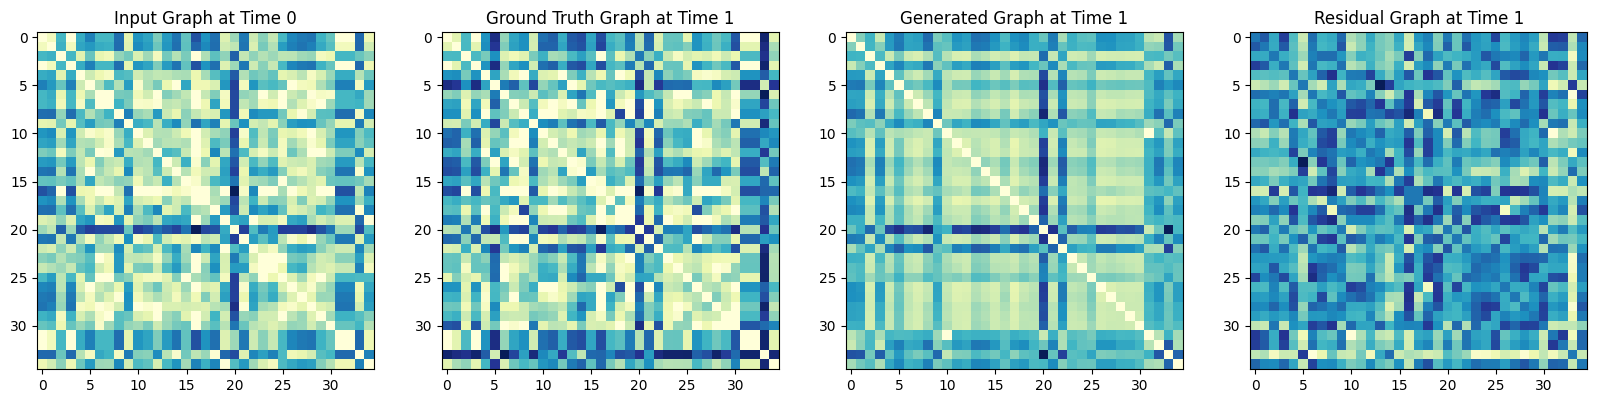

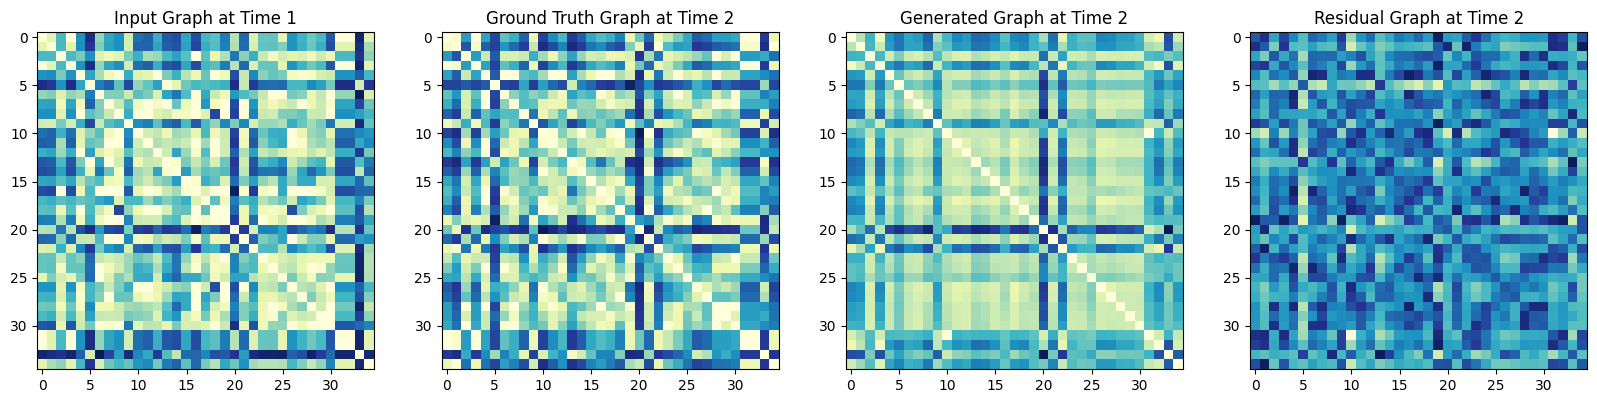

Mean Squared Error between graphs:  2.2880922e-06


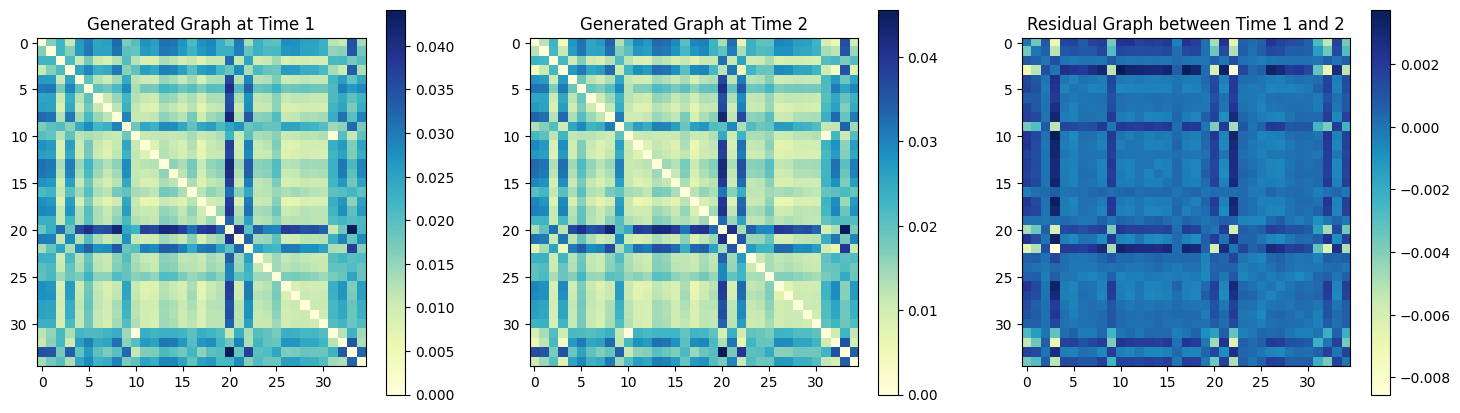

In [51]:
# Initialize model
input_dim = 35  
feature_dim = 16
latent_dim = 46
num_rec_layers = 2

# Load the saved model
model_simulated_dom1 = GCRN_gcn(input_dim, feature_dim, latent_dim, num_rec_layers)
model_simulated_dom1_path = 'models/gcrn_gcn_simulated_dom1.pth'
inference_model(model_simulated_dom1, model_simulated_dom1_path, x_test_domain_1, adj_test_domain_1, sample_idx)

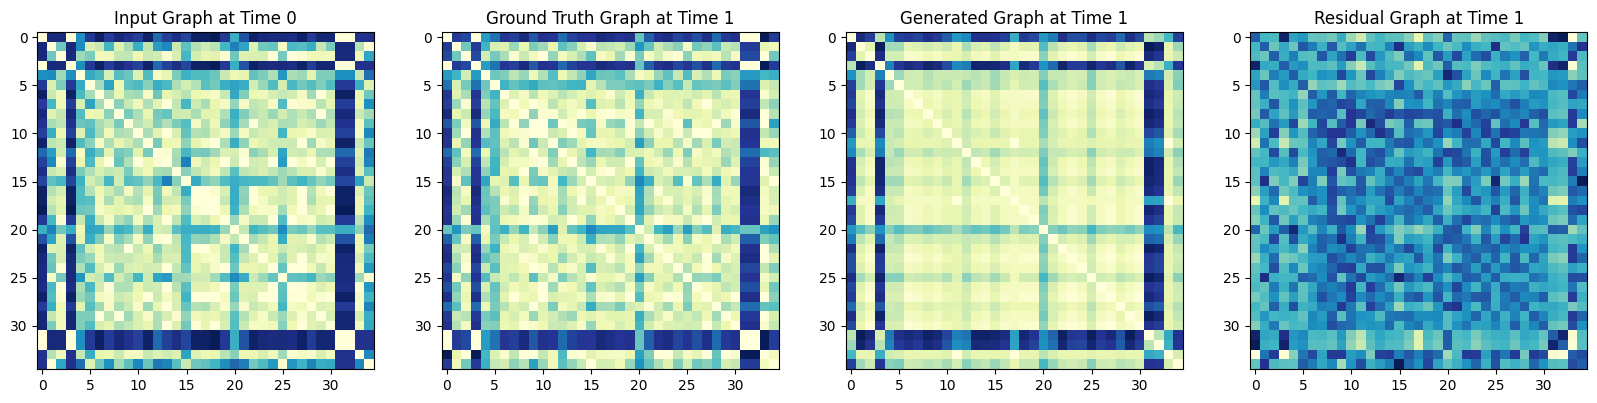

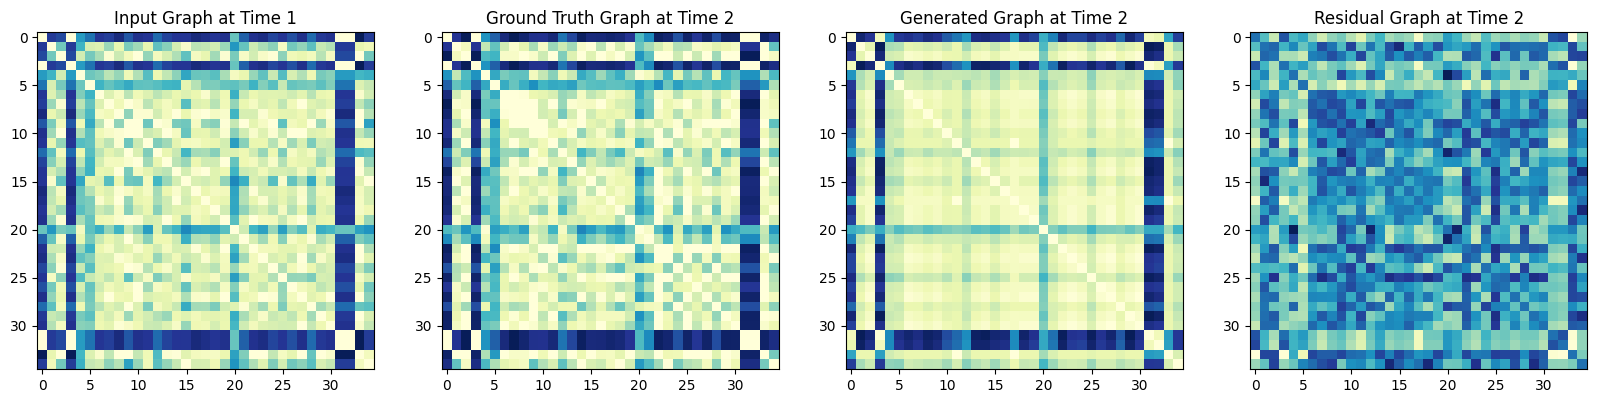

Mean Squared Error between graphs:  3.4475672e-06


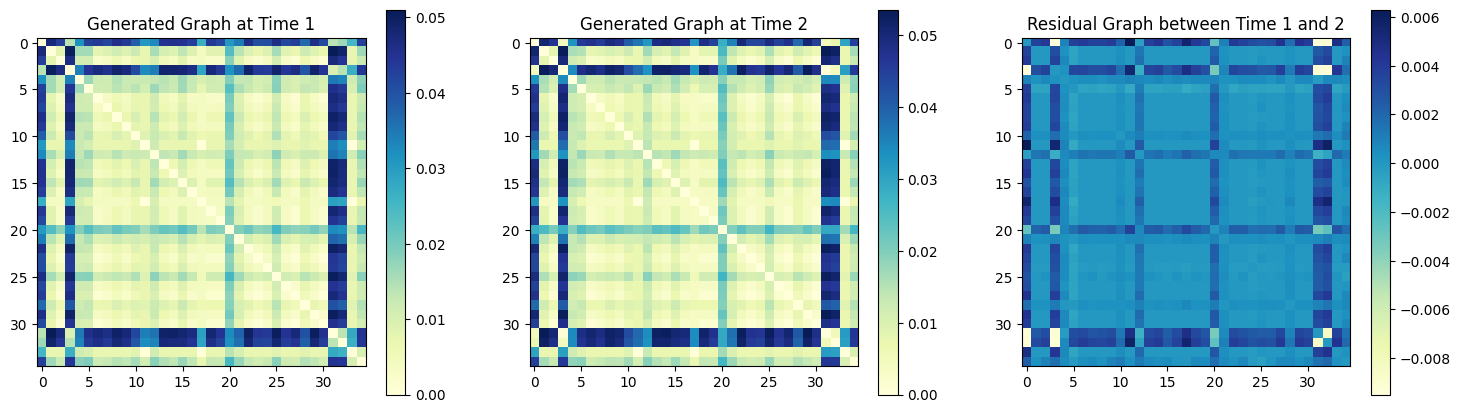

In [52]:
# Initialize model
input_dim = 35  
feature_dim = 16
latent_dim = 46
num_rec_layers = 2

# Load the saved model
model_simulated_dom2 = GCRN_gcn(input_dim, feature_dim, latent_dim, num_rec_layers)
model_simulated_dom2_path = 'models/gcrn_gcn_simulated_dom2.pth'
inference_model(model_simulated_dom2, model_simulated_dom2_path, x_test_domain_2, adj_test_domain_2, sample_idx)

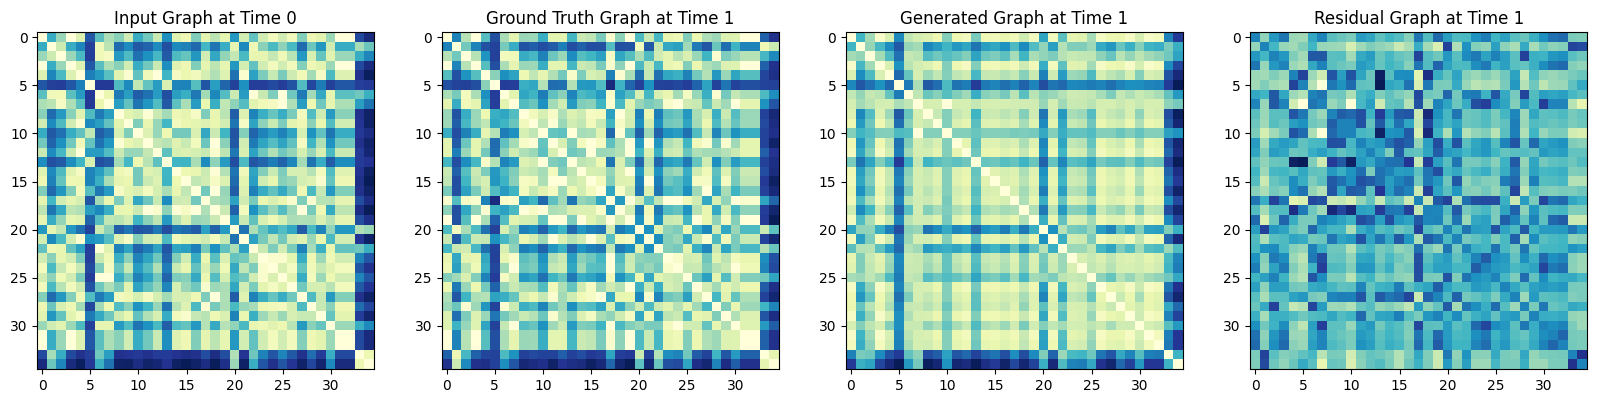

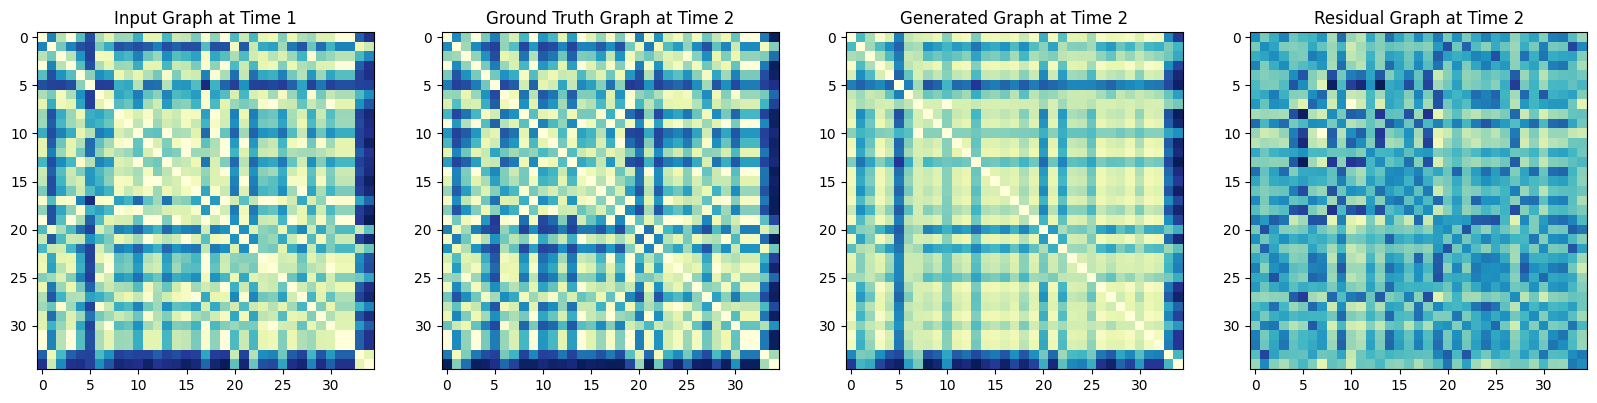

Mean Squared Error between graphs:  2.3636494e-07


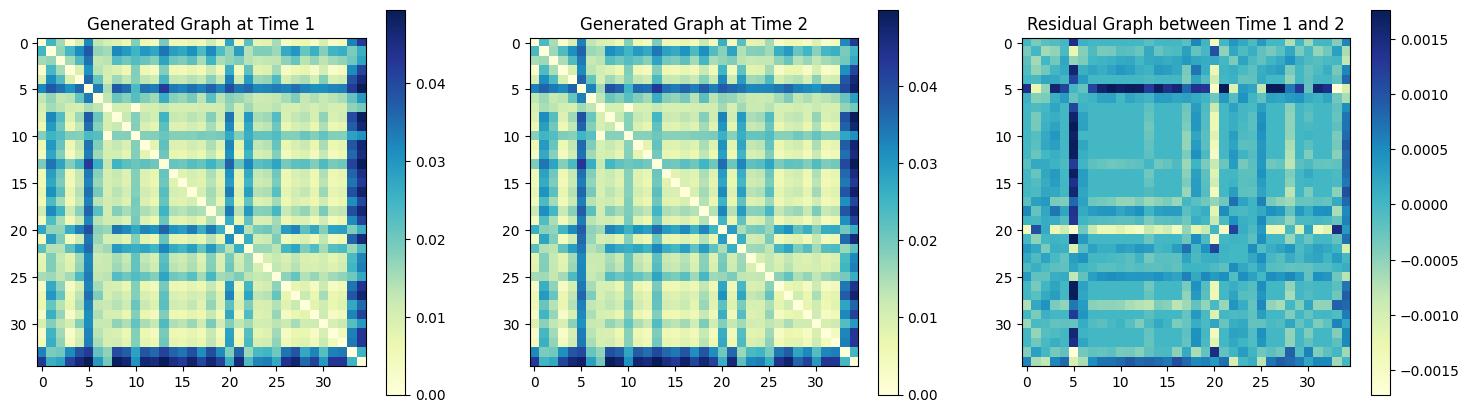

In [53]:
# Initialize model
input_dim = 35  
feature_dim = 16
latent_dim = 46
num_rec_layers = 2

# Load the saved model
model_simulated_dom3 = GCRN_gcn(input_dim, feature_dim, latent_dim, num_rec_layers)
model_simulated_dom3_path = 'models/gcrn_gcn_simulated_dom3.pth'
inference_model(model_simulated_dom3, model_simulated_dom3_path, x_test_domain_3, adj_test_domain_3, sample_idx)

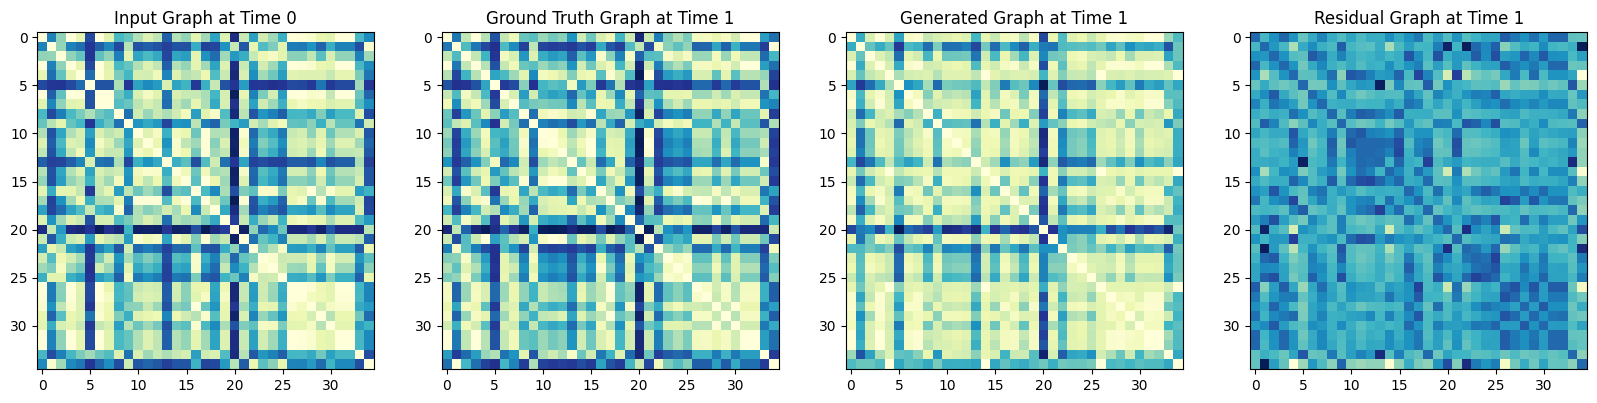

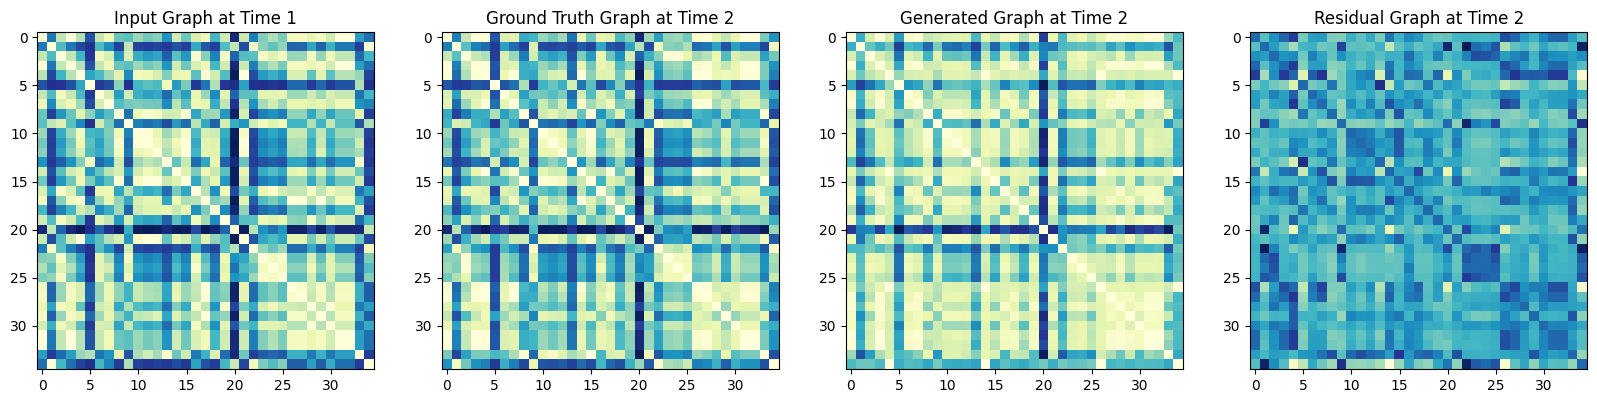

Mean Squared Error between graphs:  3.8572676e-07


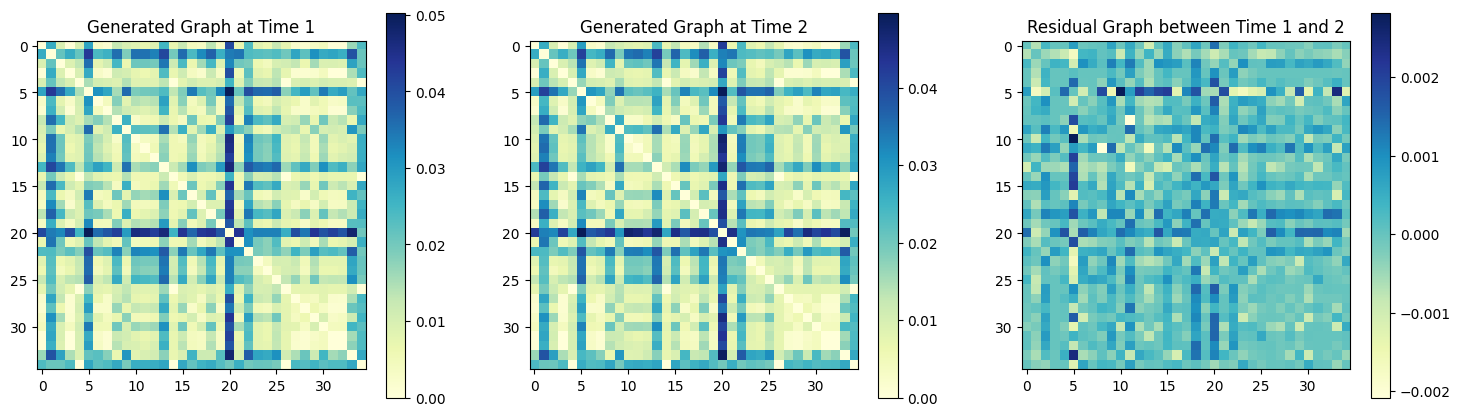

In [54]:
# Initialize model
input_dim = 35  
feature_dim = 16
latent_dim = 46
num_rec_layers = 2

# Load the saved model
model_simulated_dom4 = GCRN_gcn(input_dim, feature_dim, latent_dim, num_rec_layers)
model_simulated_dom4_path = 'models/gcrn_gcn_simulated_dom4.pth'
inference_model(model_simulated_dom4, model_simulated_dom4_path, x_test_domain_4, adj_test_domain_4, sample_idx)

### SLIM Dataset

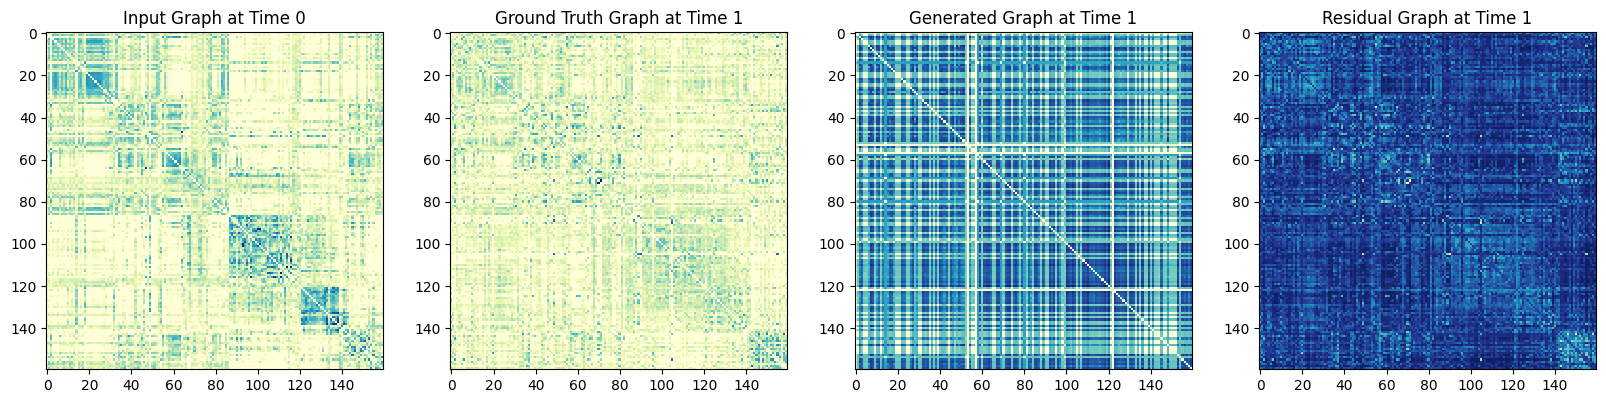

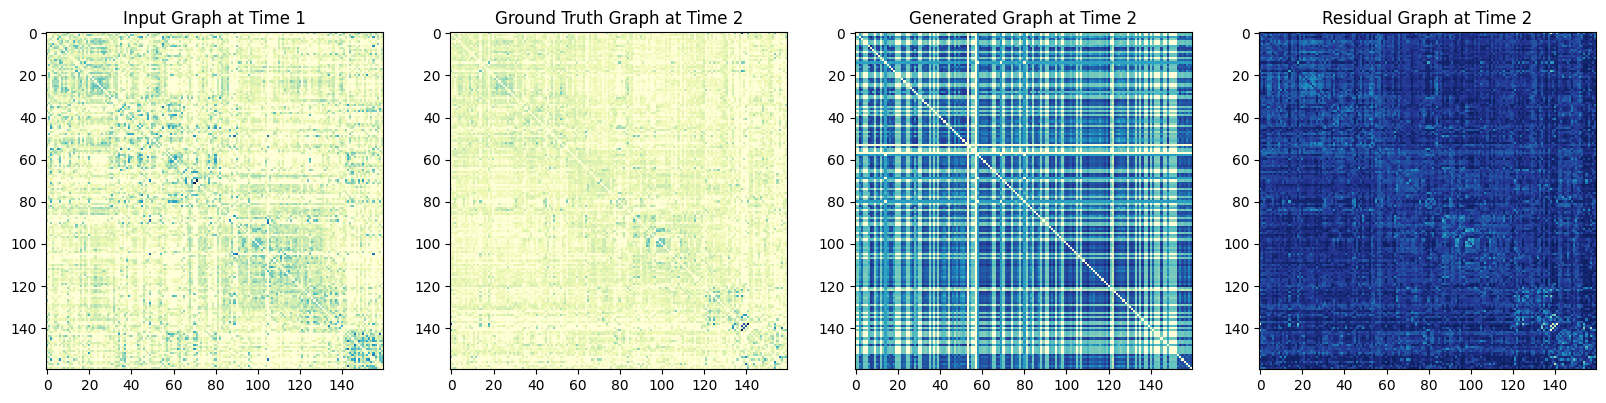

Mean Squared Error between graphs:  4.1947482e-07


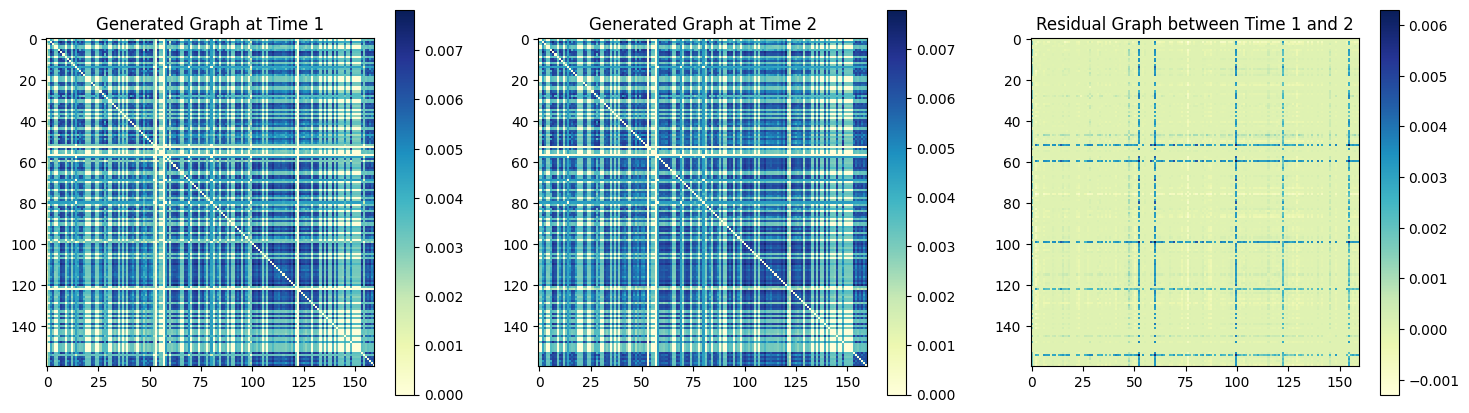

In [55]:
# Initialize model
input_dim = 160  
feature_dim = 32
latent_dim = 60
num_rec_layers = 2

# Load the saved model
model_slim160 = GCRN_gcn(input_dim, feature_dim, latent_dim, num_rec_layers)
model_slim160_path = 'models/gcrn_gcn_slim160.pth'
inference_model(model_slim160, model_slim160_path, x_test_slim160, adj_test_slim160, sample_idx)

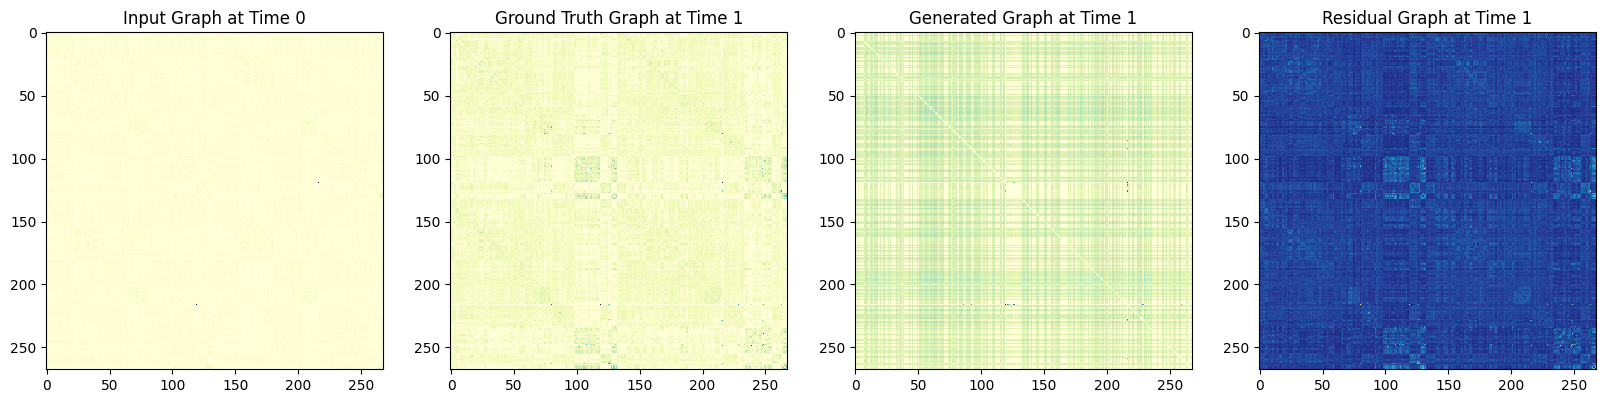

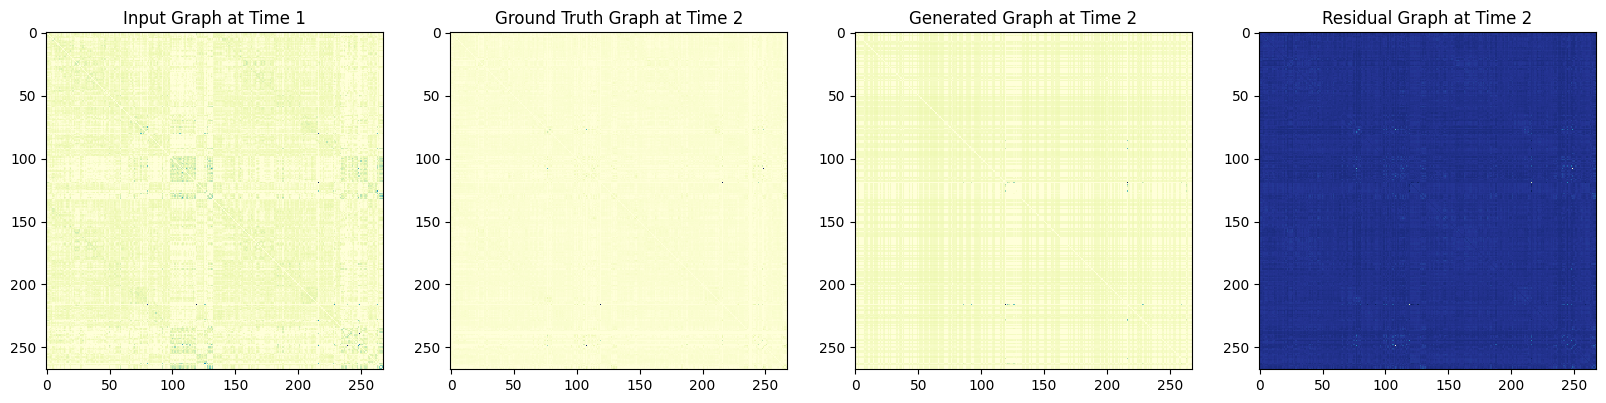

Mean Squared Error between graphs:  6.5793685e-08


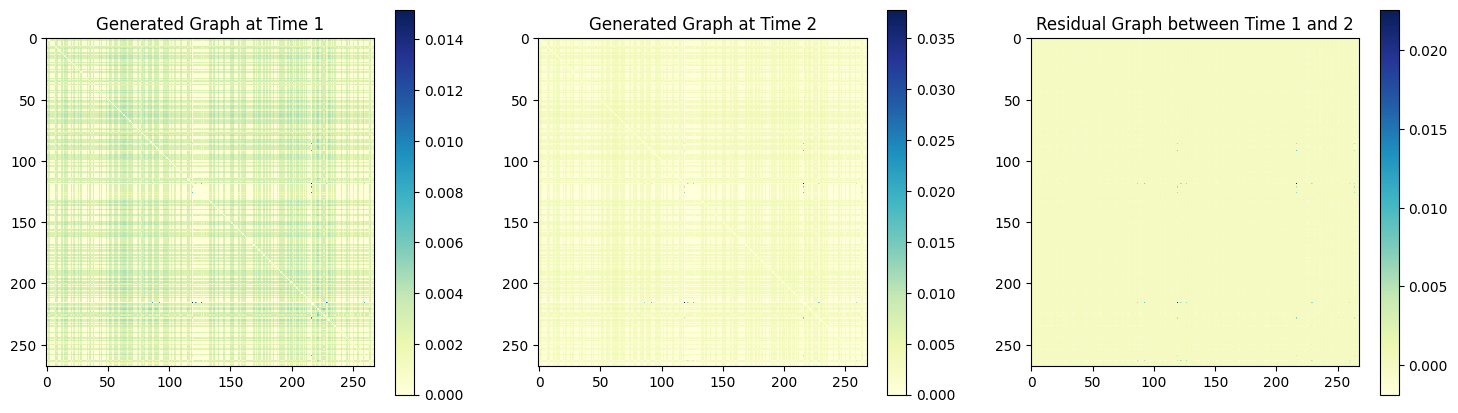

In [60]:
# Initialize model
input_dim = 268  
feature_dim = 32
latent_dim = 60
num_rec_layers = 2

# Load the saved model
model_slim268 = GCRN_gcn(input_dim, feature_dim, latent_dim, num_rec_layers)
model_slim268_path = 'models/gcrn_gcn_slim268.pth'
inference_model(model_slim268, model_slim268_path, x_test_slim268, adj_test_slim268, sample_idx)

# Evaluation

In [40]:
import networkx as nx
from sklearn.metrics import mean_absolute_error
from scipy.stats import pearsonr
from scipy.spatial.distance import jensenshannon

def evaluate_model(model, x_test, adj_test):
    num_test_samples = x_test.shape[0]
    num_roi = adj_test.shape[2]

    # Initialize lists to store MAEs for each centrality measure
    mae_bc = []
    mae_ec = []
    mae_pc = []

    pred_1d_list = []
    gt_1d_list = []

    pred_matrices_all = []
    gt_matrices_all = []

    with torch.no_grad():
        for i in range(num_test_samples):
            for t in range(1, x_test.shape[1]):
                x_t = x_test[i, t-1]  # Node features at time point t-1
                adj_t = adj_test[i, t-1]  # Adjacency matrix at time point t-1
                
                # Predict adjacency matrix at time point t
                recon_adj_t, _, _, _ = model(x_t, adj_t)
                pred_matrices_all.append(recon_adj_t.cpu().numpy())
                
                adj_t_gt = adj_test[i, t]  # Ground truth adjacency matrix at time point t
                gt_matrices_all.append(adj_t_gt.cpu().numpy())

                # Convert adjacency matrices to NetworkX graphs
                pred_graph = nx.from_numpy_array(recon_adj_t.cpu().numpy(), edge_attr="weight")
                gt_graph = nx.from_numpy_array(adj_t_gt.cpu().numpy(), edge_attr="weight")

                # Compute centrality measures
                pred_bc = nx.betweenness_centrality(pred_graph, weight="weight")
                pred_ec = nx.eigenvector_centrality(pred_graph, weight="weight")
                pred_pc = nx.pagerank(pred_graph, weight="weight")

                gt_bc = nx.betweenness_centrality(gt_graph, weight="weight")
                gt_ec = nx.eigenvector_centrality(gt_graph, weight="weight")
                gt_pc = nx.pagerank(gt_graph, weight="weight")

                # Convert centrality dictionaries to lists
                pred_bc_values = list(pred_bc.values())
                pred_ec_values = list(pred_ec.values())
                pred_pc_values = list(pred_pc.values())

                gt_bc_values = list(gt_bc.values())
                gt_ec_values = list(gt_ec.values())
                gt_pc_values = list(gt_pc.values())

                # Compute MAEs
                mae_bc.append(mean_absolute_error(pred_bc_values, gt_bc_values))
                mae_ec.append(mean_absolute_error(pred_ec_values, gt_ec_values))
                mae_pc.append(mean_absolute_error(pred_pc_values, gt_pc_values))

                # Vectorize matrices
                pred_1d_list.append(vectorize(recon_adj_t.cpu().numpy()))
                gt_1d_list.append(vectorize(adj_t_gt.cpu().numpy()))

    # Compute average MAEs
    avg_mae_bc = sum(mae_bc) / len(mae_bc)
    avg_mae_ec = sum(mae_ec) / len(mae_ec)
    avg_mae_pc = sum(mae_pc) / len(mae_pc)

    # Concatenate flattened matrices
    pred_1d = np.concatenate(pred_1d_list)
    gt_1d = np.concatenate(gt_1d_list)

    # Compute metrics
    mae = mean_absolute_error(pred_1d, gt_1d)
    pcc = pearsonr(pred_1d, gt_1d)[0]
    js_dis = jensenshannon(pred_1d, gt_1d)

    print("MAE: ", mae)
    print("PCC: ", pcc)
    print("Jensen-Shannon Distance: ", js_dis)
    print("Average MAE betweenness centrality:", avg_mae_bc)
    print("Average MAE eigenvector centrality:", avg_mae_ec)
    print("Average MAE PageRank centrality:", avg_mae_pc)

    return mae, pcc, js_dis, avg_mae_bc, avg_mae_ec, avg_mae_pc

### Simulated Dataset

In [41]:
model_simulated_dom1.eval()
# Evaluate the model
mae, pcc, js_dis, avg_mae_bc, avg_mae_ec, avg_mae_pc = evaluate_model(model_simulated_dom1, x_test_domain_1, adj_test_domain_1)


MAE:  0.013209749
PCC:  0.741671715422605
Jensen-Shannon Distance:  0.18901887264206738
Average MAE betweenness centrality: 0.06985994397759104
Average MAE eigenvector centrality: 0.014093870848184243
Average MAE PageRank centrality: 0.0024668315806073934


In [42]:
model_simulated_dom2.eval()
# Evaluate the model
mae, pcc, js_dis, avg_mae_bc, avg_mae_ec, avg_mae_pc = evaluate_model(model_simulated_dom2, x_test_domain_2, adj_test_domain_2)

MAE:  0.012595637
PCC:  0.8799100609916207
Jensen-Shannon Distance:  0.19396130475726148
Average MAE betweenness centrality: 0.07697311544938833
Average MAE eigenvector centrality: 0.01604326823453494
Average MAE PageRank centrality: 0.003559318332188257


In [43]:
model_simulated_dom3.eval()
# Evaluate the model
mae, pcc, js_dis, avg_mae_bc, avg_mae_ec, avg_mae_pc = evaluate_model(model_simulated_dom3, x_test_domain_3, adj_test_domain_3)

MAE:  0.012661471
PCC:  0.7909626051287917
Jensen-Shannon Distance:  0.17129584835099407
Average MAE betweenness centrality: 0.08677887601321518
Average MAE eigenvector centrality: 0.013210707270810806
Average MAE PageRank centrality: 0.0022271531989038447


In [44]:
model_simulated_dom4.eval()
# Evaluate the model
mae, pcc, js_dis, avg_mae_bc, avg_mae_ec, avg_mae_pc = evaluate_model(model_simulated_dom4, x_test_domain_4, adj_test_domain_4)

MAE:  0.013137711
PCC:  0.8345247907610257
Jensen-Shannon Distance:  0.16122437389921807
Average MAE betweenness centrality: 0.08900539003480182
Average MAE eigenvector centrality: 0.01790485097293188
Average MAE PageRank centrality: 0.003102715746114396


### SLIM Dataset

In [50]:
model_slim160.eval()
# Evaluate the model
mae, pcc, js_dis, avg_mae_bc, avg_mae_ec, avg_mae_pc = evaluate_model(model_slim160, x_test_slim160, adj_test_slim160)

MAE:  0.005250925
PCC:  0.0330029751603266
Jensen-Shannon Distance:  0.48498416864964755
Average MAE betweenness centrality: 0.02307654085603816
Average MAE eigenvector centrality: 0.020645411755115504
Average MAE PageRank centrality: 0.0016452796580374179


In [64]:
model_slim268.eval()
# Evaluate the model
mae, pcc, js_dis, avg_mae_bc, avg_mae_ec, avg_mae_pc = evaluate_model(model_slim268, x_test_slim268, adj_test_slim268)

MAE:  0.0026498474
PCC:  0.10477267350433381
Jensen-Shannon Distance:  0.465336482375993
Average MAE betweenness centrality: 0.01706212958187856
Average MAE eigenvector centrality: 0.017068873787352116
Average MAE PageRank centrality: 0.0012546468688271503
